In [29]:
import myData
import numpy as np

#for pytorch docker image
#!pip install matplotlib

randomSeed = 12345
myData.rng = np.random.default_rng(randomSeed)

#dataPath = 'D:\\MyWorks\\data'  # dataPeak and dataBase
dataPath  = 'data' # for the school server
onlyRead = True

# 0.025 <= peakMinHeight< 0.15
if not onlyRead:
    dataPeak, dataBase = myData.genData(dataPath, 200000, lenSignal=512, baseOrder=7,
                                        peakCount=(5, 15), peakMinHeight=0.05, peakWidth=(5,21))

# X: Paek Y: Baseline Z: X+Y

gNoiseMax = 0.01
gBaseMin = 0.1
gBaseMax = 0.8

# X: Paek Y: Baseline Z: X + Y*rand([baseRatioMin, baseRatioMax])
trainX, trainY, testZZ, testXX, testYY = myData.prepareData(dataPath,readValidData=onlyRead, noiseMax=gNoiseMax, 
                                                baseRatioMin=gBaseMin, baseRatioMax=gBaseMax, onlyPeak=False, trainRatio=0.8)
#trainX, trainY, testZZ, testXX, testYY = myData.prepareData(dataPath,readValidData=False, noiseMax=gNoiseMax, 
#                                                baseRatioMin=gBaseMin, baseRatioMax=gBaseMax, onlyPeak=False, trainRatio=0.8)

dataWidth = len(trainX.T)
trainSize = len(trainX)
testSize = len(testXX)
print(f'trainSize : {trainSize}, testSize: {testSize}, dataWidth : {dataWidth}')


reading data from files..
reading done..
(160000, 512) (160000, 512)
(40000, 512) (40000, 512) (40000, 512)
reading validation data from files..
All data are prepared.. (40000, 512), (40000, 512), (40000, 512)
trainSize : 160000, testSize: 40000, dataWidth : 512


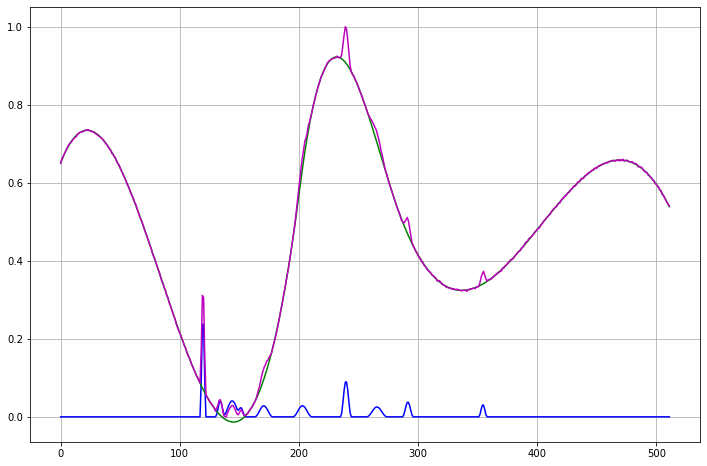

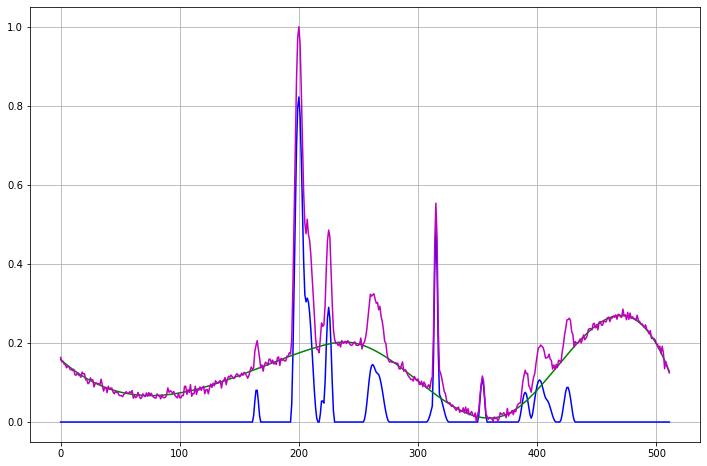

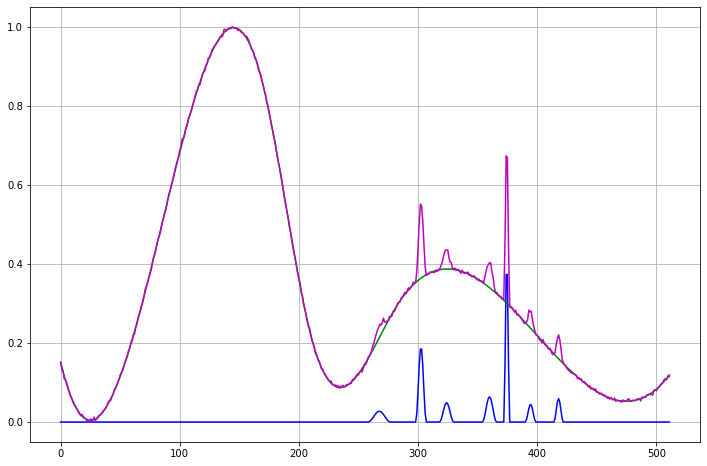

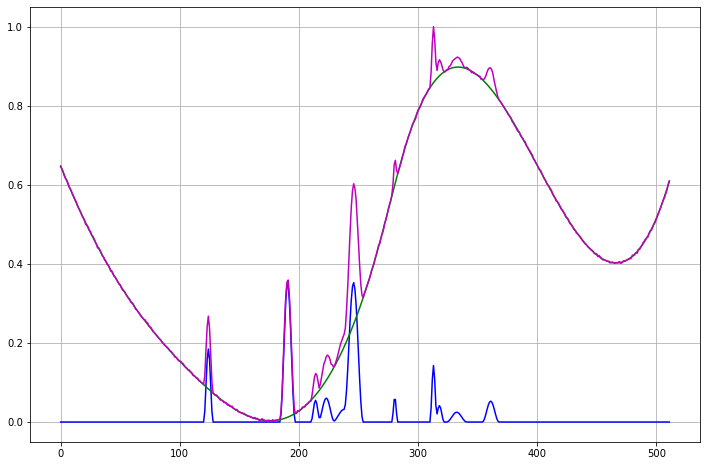

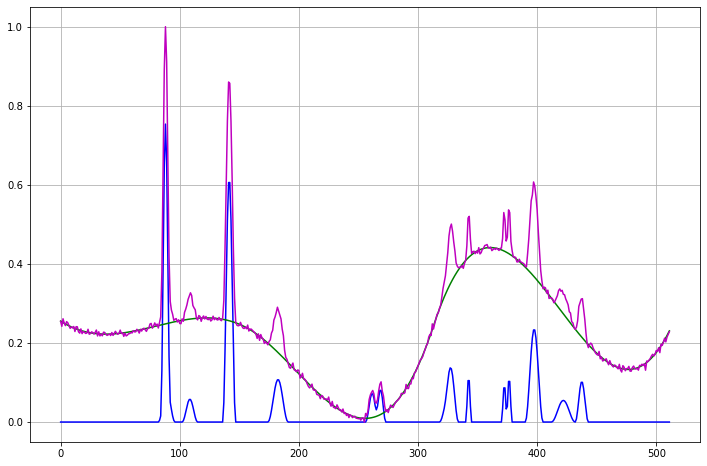

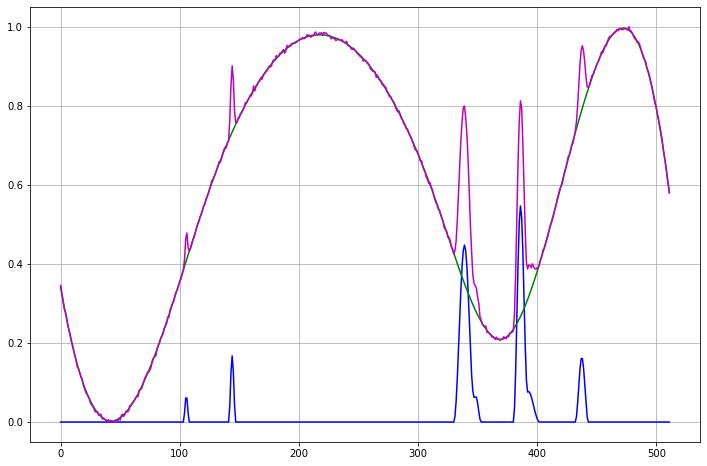

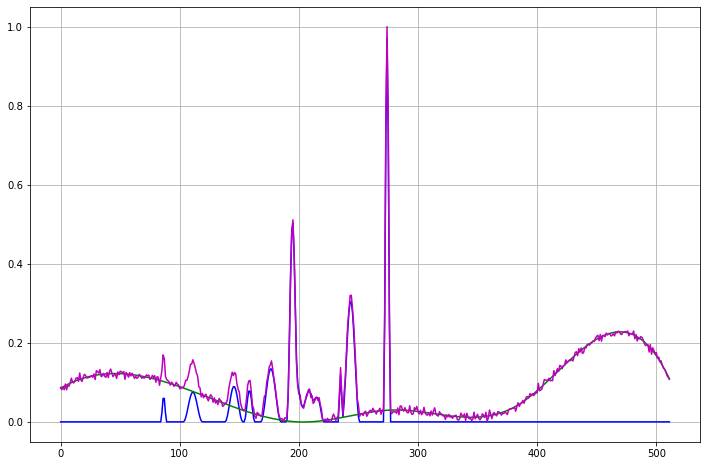

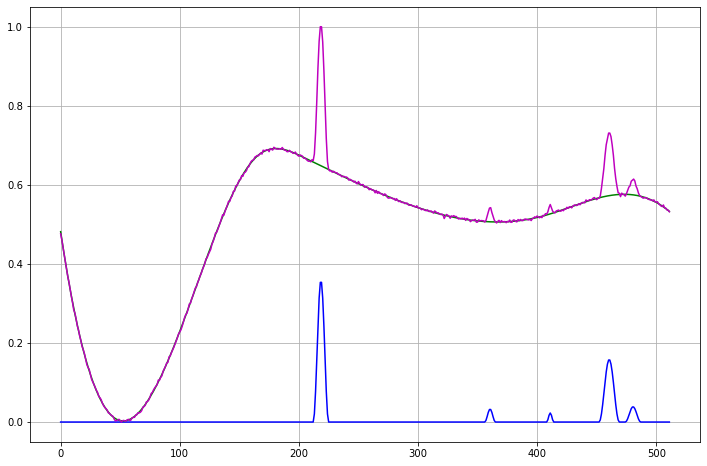

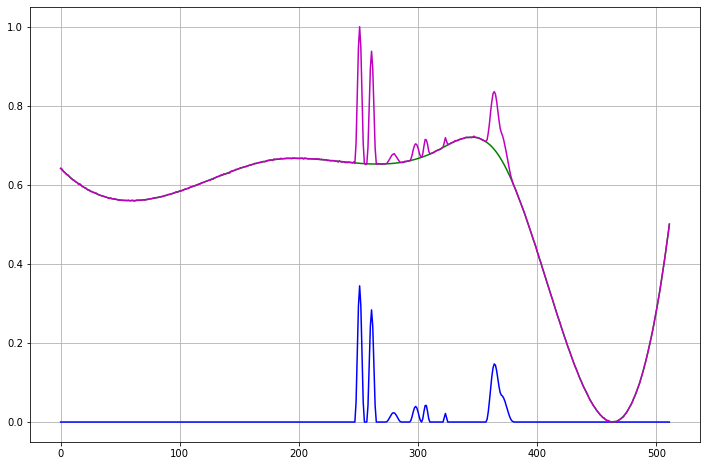

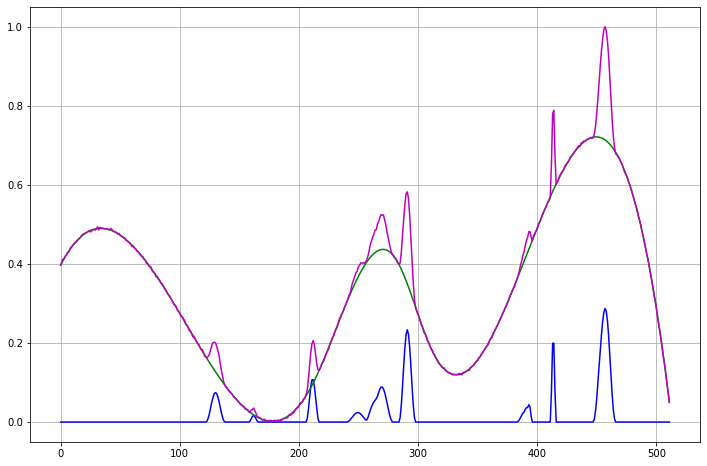

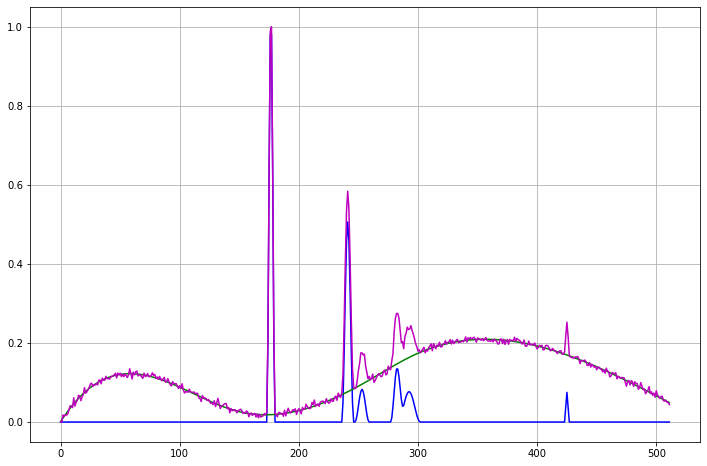

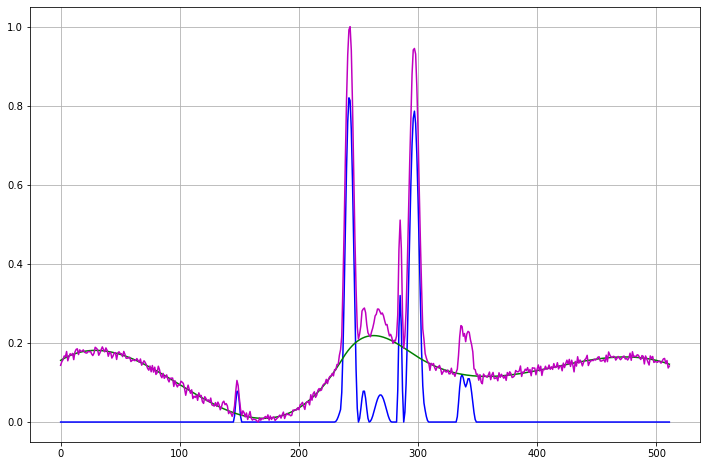

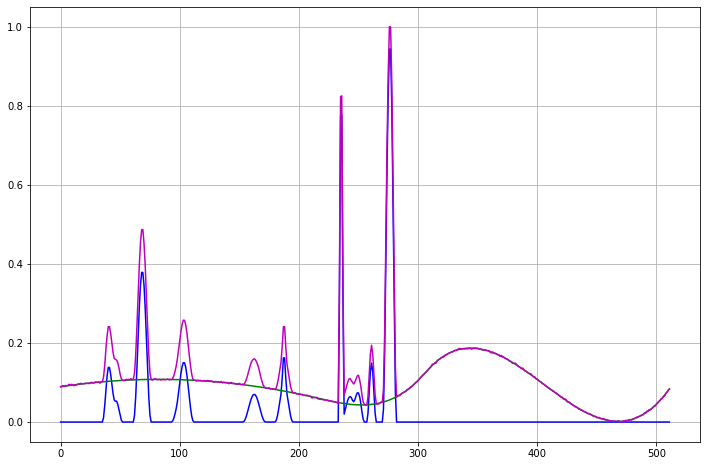

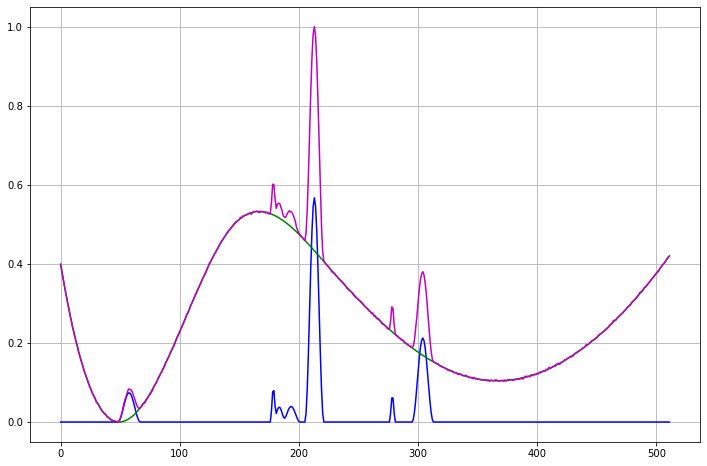

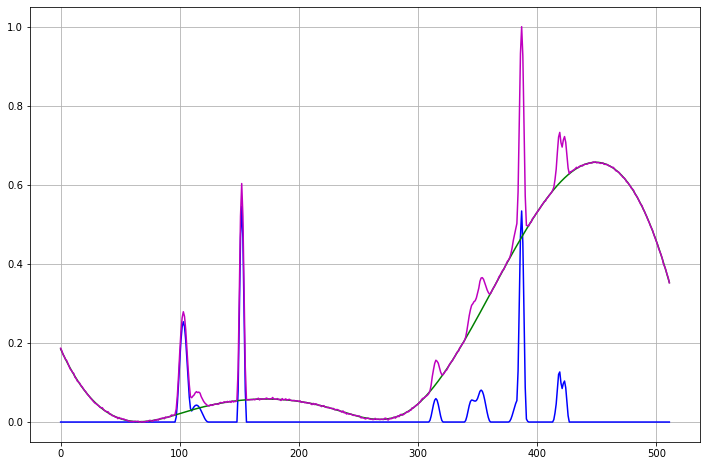

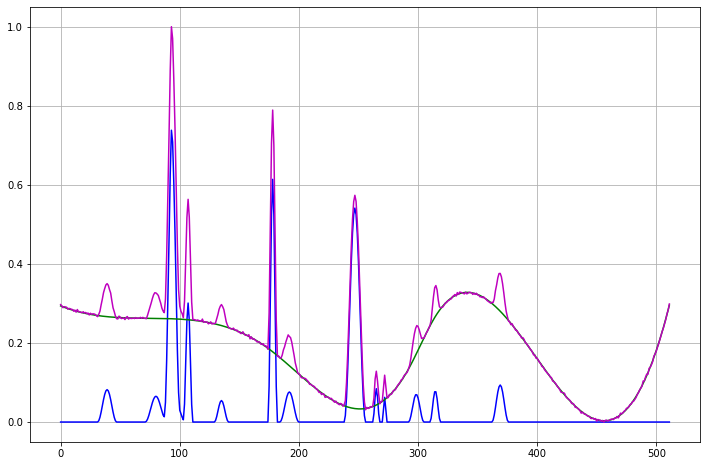

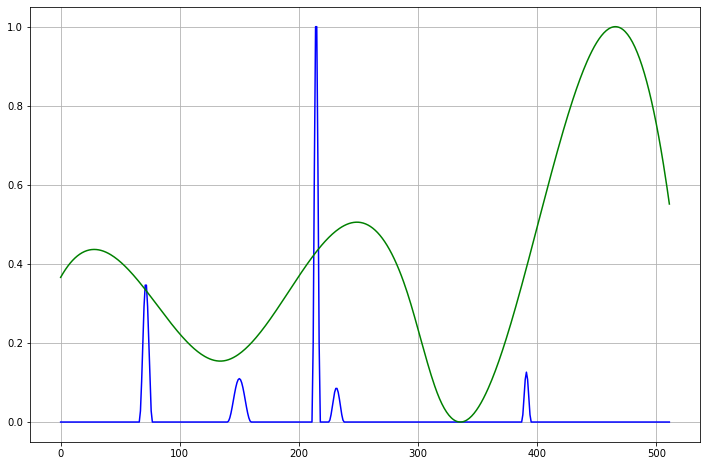

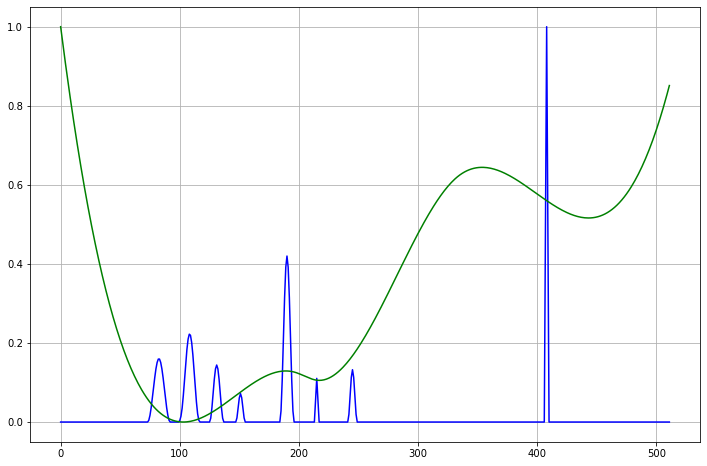

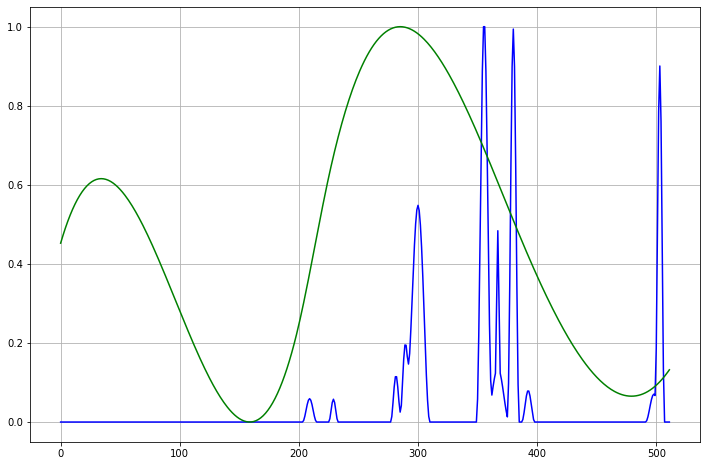

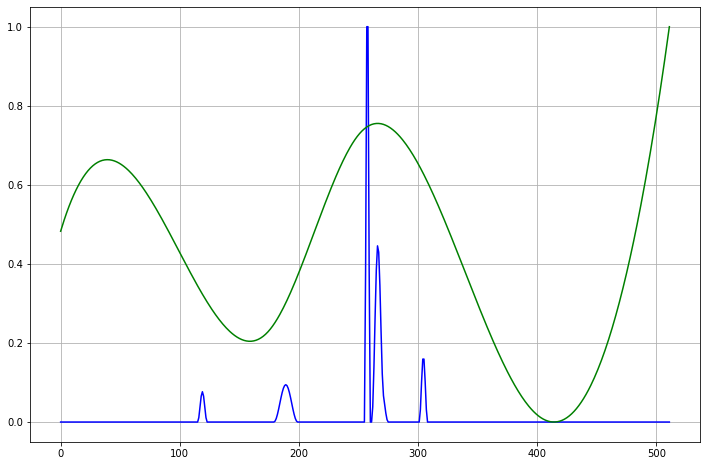

In [2]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(0,testSize,testSize//15):
    plt.figure(figsize=(12,8))
    plt.plot(testXX[i],'b',testYY[i],'g',testZZ[i],'m')
    plt.grid(True)
    
for i in range(0,trainSize,trainSize//4):
    plt.figure(figsize=(12,8))
    plt.plot(trainX[i],'b',trainY[i],'g')
    #plt.plot(dataPeak[i],'b',dataBase[i],'g')
    plt.grid(True)    

In [50]:
#!/usr/bin/env python
# coding: utf-8

#from myUtils import * # getVersion(), myTorch.getVersion()
#from myUtils import myTorch # myTorch.getVersion()
#import myUtils  # myUtils.getVersion(), myUtils.myTorch.getVersion()

#from typing import List
from typing import *  # List, Set, Tuple, Dict, Union, Final, Optional, Callable

import numpy as np

'''
from numpy.random import default_rng
rng = default_rng(12345)

noiseSigma = rng.random((dataSize,1))*globalNoiseMax
noiseData = np.random.normal(trainData, scale=noiseSigma,size=(dataSize,dataWidth))

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(allData[1200],'m')
plt.grid(True)

# logScale : ex) 8 -> 16 -> 32 -> 64 
layerWidth = np.round(np.logspace(np.log2(8),np.log2(64),4,base=2)).astype(int)
'''

import sys

def getVersion(printInfo = True):
    if printInfo:
        print('Python  version:', sys.version)
        print('Numpy   version:', np.__version__)
    return sys.version, np.__version__

def checkIterable(testObject):
    try:
      iter(testObject)
      return True
    except TypeError:
      return False

import time
from datetime import timedelta

# use perf_time() for code execution time + pending time + io time
# myTimer = myUtils.MyTimer()
# print(myUtils.myTimer())
class MyTimer:
    def __init__(self, elapsedTime=0):
        self.elapsedTime = elapsedTime
        self.timeOrigin = time.process_time()
                
    def reset(self, elapsedTime=0):
        self.elapsedTime = elapsedTime
        self.timeOrigin = time.process_time()
    
    def __call__(self, inSeconds=True):
        elapsedTime = time.process_time() - self.timeOrigin + self.elapsedTime
        if inSeconds: elapsedTime = int(elapsedTime)
        return str(timedelta(seconds=elapsedTime))            
    
    def elapsedSeconds(self):
        elapsedSecs = time.process_time() - self.timeOrigin + self.elapsedTime
        return int(elapsedSecs)

#try:
#    print('Start training..')
#    trainLog, testLog = myTrainer(trainLoader, testLoader, epochMax=1200)
#except KeyboardInterrupt:
#    myTrainer.saveModel()
#    print('Training interrupted..')
#    myUtils.stopExecution()  or raise myUtils.StopException() 
class StopException(Exception):
    def __init__(self, errMessage='StopException is raised..'):
        if errMessage is not None: print(errMessage)
        self.errMessage=errMessage
            
    def _render_traceback_(self):
        pass
    
    def __str__(self):
        return self.errMessage

def stopExecution(errMessage='stopExecution is called..'):    
    raise StopException(errMessage)

def importPackage(packageName, onlyMessage=False):
    import importlib
    packageSpec = importlib.util.find_spec(packageName)
    if packageSpec == None:
        if onlyMessage:
            print('The package, {packageName}, is not installed. Install {packageName} first..')
            raise StopException
        else:            
            print('The package, {packageName}, is not installed. Installing {packageName}..')
            import subprocess
            import sys
            subprocess.check_call([sys.executable, "-m", "pip", "install", packageName])

importPackage('torch', onlyMessage=True)

def normalize(x, axis=1):
    xmin = x.min(axis, keepdims=True)
    xmax = x.max(axis, keepdims=True)
    return x/(xmax - xmin)

import torch
import torch.nn as nn
import torch.nn.functional as F

class myTorch:
    # class variable
    _actUnit = nn.ReLU()
    _useNorm = False
    _preAct = True
    
    @staticmethod
    def actUnit(actUnit:str, inplace:bool=False):
        return  nn.ModuleDict([
            ['relu', nn.ReLU(inplace=inplace)],
            ['relu6', nn.ReLU6(inplace=inplace)],
            ['leakyrelu', nn.LeakyReLU(negative_slope=0.01, inplace=inplace)],
            ['gelu', nn.GELU()],
            ['selu', nn.SELU(inplace=inplace)],
            ['silu', nn.SiLU(inplace=inplace)],
            ['swish', nn.Hardswish(inplace=inplace)],
            ['elu', nn.ELU(inplace=inplace)],
            ['sigmoid', nn.Sigmoid()],
            ['tanh', nn.Tanh()],
            ['softsign', nn.Softsign()],
            ['softplus', nn.Softplus()],
            ['silu', nn.SiLU(inplace=inplace)],
            ['identity', nn.Identity()]
        ])[actUnit.lower()]
    
    @staticmethod
    def setActUnit(actUnit:str='ReLU'):
        myTorch._actUnit = myTorch.actUnit(actUnit)
        
    @staticmethod
    def getActUnit():
        return myTorch._actUnit

    @staticmethod
    def setUseNorm(useNorm:bool = False):
        myTorch._useNorm = useNorm

    @staticmethod
    def getUseNorm(useNorm:bool = False):
        return myTorch._useNorm
        
    @staticmethod        
    def setPreAct(preAct:bool = False):
        myTorch._preAct= preAct

    @staticmethod        
    def getPreAct(preAct:bool = False):
        return myTorch._preAct
        
    @staticmethod
    def standardize(x, mean, std):
        return (x - mean)/std

    @staticmethod
    def standardize_(x, mean, std):
        x.sub_(mean).div_(std)
    
    @staticmethod
    def normalize(x):
        xmin, _ = x.min(1, keepdims=True)
        x = x - xmin
        return x/x.max(1, keepdims=True).values        
    
    @staticmethod
    def normalize_(x):
        xmin, _ = x.min(1, keepdims=True)
        x.sub_(xmin)
        xdelta, _ = x.max(1, keepdims=True)
        x.div_(xdelta)
    
    @staticmethod
    def normalizeXY(x, y):
        xmin, _ = x.min(1, keepdims=True)
        x = x - xmin
        y = y - xmin
        xdelta, _ = x.max(1, keepdims=True)
        return x/xdelta, y/xdelta
    
    @staticmethod
    def normalizeXY_(x, y):
        xmin, _ = x.min(1, keepdims=True)
        x.sub_(xmin)
        y.sub_(xmin)
        xdelta, _ = x.max(1, keepdims=True)
        x.div_(xdelta)
        y.div_(xdelta)

    @staticmethod
    def getVersion(printInfo:bool=True):
        if printInfo: print('Pytorch version:', torch.__version__ )
        return torch.__version__

    # usage: torchVariable.to(myDevice)   
    @staticmethod
    def getGPU(deviceNo:int = 0, clearCache:bool = False, printInfo:bool = True):
        useGPU = torch.cuda.is_available()
        if useGPU:
            myDevice=torch.device(f'cuda:{deviceNo}') # torch.device('cuda:0') == torch.device('cuda')
            torch.cuda.set_device(myDevice)
            if printInfo:
                print(f'# of GPU : {torch.cuda.device_count()}')
                deviceNo=torch.cuda.current_device()
                print(f'GPU: {torch.cuda.get_device_name(deviceNo)}, GPU No: {deviceNo}')
                print(f'CUDA capability: {torch.cuda.get_device_capability(myDevice)}')
            if clearCache: torch.cuda.empty_cache()
        else:
            myDevice=torch.device('cpu')
            if printInfo:  print(f'Pytorch will run on CPU')
                
        return myDevice, useGPU
    
    @staticmethod
    def freezeUpdate(myModel, freezeFlag:bool=True):
        assert isinstance(myModel, nn.Module), 'myModel must inherit nn.Module'
        for param in myModel.parameters():
            param.requires_grad = not freezeFlag
        
    # conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)
    # conv1k1 = partial(Conv2dAuto, kernel_size=1, bias=False)
    class Conv1dAuto(nn.Conv1d):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.padding =  self.kernel_size // 2 # dynamic padding according to the kernel_size

    """
    Usage:
    
    from collections import deque
    
    myNet = MyLinear(modelName=myModelName, channelList=[512, 256, 512], layerRepeats=[1, 2, 2], # dataShrink=dataShrink, 
                     preSizeK=0, preAct='ReLU', upType=0, resType=0, useNorm=False)

class MyLinear(torch.nn.Module):
    def __init__(self, modelName='MyPeakX', channelList=[512, 512, 512, 512], layerRepeats=[2, 2, 3, 3], 
                 preSizeK=0, preAct='ReLU', upType=0, resType=0, useNorm=False):
        super().__init__()        
        self.modelName = modelName
        self.upType = upType
        self.preNet = True if preSizeK else False

        # preSize==0 means that preLayer do nothing
        self.preLayer = myTorch.preLinear(channelList, preSizeK, resType, useNorm, actUnit=preAct)
        inSize = channelList[-1] if upType == 0 else channelList[0]
        self.outLayer = myTorch.outLinear(inSize = inSize, outSize = dataWidth)
        
        self.layerA = myTorch.downNetLinear(channelList, layerRepeats, preSizeK, resType, useNorm, actUnit='ReLU')

        ###
        inChannel, lastChannel = channelList[0], channelList[-1]
        self.midLayer = nn.Sequential(
            nn.Linear(lastChannel, dataShrink, bias=True),
            #self.nonLinear,
            nn.Linear(dataShrink, lastChannel, bias=True)
        )
        ###

        if upType <= 0 : return
        
        self.layerB = myTorch.upNetLinear(channelList, layerRepeats, upType, resType, useNorm, actUnit='ReLU')
        
    def forward(self, x):
        x = self.preLayer(x)

        # only forward path
        if self.upType == 0:
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)

        # just forward + backward path
        elif self.upType == 1:
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)

            for layerL in self.layerB:
                x = layerL(x)

        # UNet case
        else:            
            z = deque()
            endA = len(self.layerA)-1
            for k, layerL in enumerate(self.layerA):
                x = layerL(x, self.preLayer()) if k and self.preNet else layerL(x)
                if k != endA: z.append(x)
            
            for layerL in self.layerB:
                x = layerL(x, z.pop())

        return self.outLayer(x)
        
    """    
    class preLinear(nn.Module):
        def __init__(self, channelList, preSizeK=0, resType=0, useNorm=False, actUnit='ReLU'):
            super().__init__()
           
            preNet = True if preSizeK else False            
            if not preNet: # do nothing if preSizeK == 0
                self.preLayer = nn.ModuleList( [nn.Identity()] )
                self.normLayer = nn.ModuleList( [nn.Identity()] ) if useNorm else None
                self.actUnit = myTorch.actUnit('Identity')
                return
            
            self.actUnit = myTorch.actUnit(actUnit)
            
            assert preSizeK in {0, 1, 2, 4}, 'preNet shoud be in {0, 1, 2, 4}'
            
            dataWidth = channelList[0]
            preDepth = len(channelList) if preNet else 0

            if preNet: self.preChannel = [ channelWidth//preSizeK for channelWidth in channelList ]
            
            self.preLayer = nn.ModuleList( [nn.Identity()] )
            
            self.preLayer.extend( [ nn.Linear(dataWidth, self.preChannel[k] ) for k in range(1,preDepth) ] )                
                
            self.normLayer = nn.ModuleList( [nn.Identity()] ) if useNorm else None
            
            if self.normLayer!=None and preDepth > 1: 
                self.normLayer.extend( [ nn.BatchNorm1d(self.preChannel[k]) for k in range(1, preDepth) ] )
            
        def forward(self, x=None):
            if x!=None:
                if x.ndim == 1: x = x.view(1, -1)
                self.saveX = x
                self.saveK = 0
            else:
                x = self.saveX
                self.saveK += 1
                
            k = self.saveK
            x = self.preLayer[k](x)
            
            if self.normLayer!=None:  x = self.normLayer[k](x)
            
            x = self.actUnit(x)
            
            return x
        
    @staticmethod
    def outLinear(inSize, outSize):
        return nn.Sequential( nn.Flatten(), nn.Linear(inSize, outSize) )

    class BlockLinear(nn.Module):
        def __init__(self, inSize, outSize, numRepeats, preSizeK, resType, useNorm, actUnit='ReLU', initFlag=False):
            super().__init__()
                                        
            self.numRepeats = numRepeats
            # resType == -1 -> -2 when numRepeats == 1
            self.resType = -2 if numRepeats == 1 and resType == -1 else resType
            
            self.linearA = nn.ModuleList()
            self.linearB = nn.ModuleList()
            self.outLayer = nn.ModuleList()
            
            auzSize = outSize//preSizeK if preSizeK else 0
            
            if resType != 0:
                self.shortCut = nn.Linear(inSize, outSize) if inSize != outSize else nn.Identity()
                                
            linearA  = [ nn.Linear(inSize, outSize) ]
            if useNorm: linearA.append( nn.BatchNorm1d(outSize) )
            linearA.append( myTorch.actUnit(actUnit) )
            
            linearB = nn.Linear(outSize + auzSize, outSize)
            
            outLayer = [ nn.BatchNorm1d(outSize) if useNorm else nn.Identity() ]
            outLayer.append( myTorch.actUnit(actUnit) )

            self.linearA.append(nn.Sequential(*linearA))
            self.linearB.append(linearB)
            self.outLayer.append(nn.Sequential(*outLayer))
            
            for _ in range(1, numRepeats):
                
                linearA  = [ nn.Linear(outSize, outSize) ]
                if useNorm: linearA.append( nn.BatchNorm1d(outSize) )
                linearA.append( myTorch.actUnit(actUnit) )

                linearB = nn.Linear(outSize, outSize)

                outLayer = [ nn.BatchNorm1d(outSize) if useNorm else nn.Identity() ]
                outLayer.append( myTorch.actUnit(actUnit) )

                self.linearA.append(nn.Sequential(*linearA))
                self.linearB.append(linearB)
                self.outLayer.append(nn.Sequential(*outLayer))
                
        def forward(self, x, z = None):
            y = self.linearA[0](x)
            z = y if z == None else torch.cat((y, z), dim=1)
            
            if self.resType !=0: shortX = self.shortCut(x)                
            x = self.linearB[0](z) + shortX if self.resType not in {0, -1} else self.linearB[0](z)
            
            x = self.outLayer[0](x)
            if self.numRepeats ==1: return x
            
            for linearA, linearB, outLayer in zip(self.linearA[1:], self.linearB[1:], self.outLayer[1:]):                
                y = linearA(x) + y if self.resType > 1 else linearA(x)
                if self.resNet >= 0:
                    x = linearB(y) + x if self.resType > 0 else linearB(y)
                else:
                    x = linearB(y) + shortX if linearB==self.linearB[-1] else linearB(y)
                    
                x = outLayer(x)
            
            return x
        
    # preSizeK is currently not used
    @staticmethod
    def downNetLinear(channelList, layerRepeats=2, preSizeK=0, resType=0, useNorm=False, actUnit='ReLU'):
        assert isinstance(channelList, (list, tuple)), 'channelList should be list or tuple'        
        layerDepth = len(channelList)
        
        if isinstance(layerRepeats, int): layerRepeats = [layerRepeats]*layerDepth
            
        # usePreNet except for the first layer    
        layerA = nn.ModuleList( [myTorch.BlockLinear(channelList[0], channelList[0], layerRepeats[0], 
                                                     preSizeK=0, resType=resType, useNorm=useNorm, actUnit=actUnit)] )
        for k in range(1,layerDepth):
            layerA.append( myTorch.BlockLinear(channelList[k-1], channelList[k], layerRepeats[k], preSizeK, resType, useNorm, actUnit) )
        return layerA
        
    @staticmethod        
    def upNetLinear(channelList, layerRepeats=2, upType=0, resType=0, useNorm=False, actUnit='ReLU'):
        assert isinstance(channelList, (list, tuple)), 'channelList should be list or tuple'
        layerDepth = len(channelList)
        
        if isinstance(layerRepeats, int): layerRepeats = [layerRepeats]*layerDepth

        preSizeK   = 1 if upType >= 2 else 0            
        channelList, layerRepeats = channelList[::-1], layerRepeats[-2::-1]        
        return nn.ModuleList([myTorch.BlockLinear(channelList[k], channelList[k+1], layerRepeats[k], preSizeK, 
                                                  resType, useNorm, actUnit) for k in range(layerDepth-1)])
   
    """
    Usage:

    # preNet : 0(no preNet), 1(reduce the output size by direct Conv), {2, 4}(reduce the output size by sequential Conv 2k or 4k)    
    # preNetK = 0 : no preNet, 1 : normal preNet size, 2: half preNet size, 4: quarter preNet size
    # outChannelK is used to reduce the number of the last channels before output channel with outChannel//outChannelK
    # upType = 0: no up net, 1: u-type net, 2: UNet
    # expansionK : replaces 3x1 convolution with 1x1 convolution by expansion {1, 2, 4} 
    # numGroups : divides the layer into small segments for deep network {1, 2, 3, 4, ...}
    # outChannelK is used to reduce the size of mid output channels without up-layer {None(same as 1), 2, 4, 8}    
    # resType = 0: no resNet, 1: normal resNet, 2: test resNet, -1: last resNet
    myNet = MyCNN(modelName=myModelName, channelList=[16, 32, 64, 128, 256], channelUpDown=[False, True, True, True, True], 
            layerRepeats=[2, 2, 2, 2, 3], numGroups=1, preNet=4, preSizeK=1, preAct=['identity','relu'], upType=1, expansionK=1, 
            useNorm=False, useResNet=False, outChannelK=8, dataWidth=512)


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

class MyCNN(nn.Module):
    # preNet : 0(no preNet), 1(reduce the output size by direct Conv), {2, 4}(reduce the output size by sequential Conv 2k or 4k)    
    # preNetK = 0 : no preNet, 1 : normal preNet size, 2: half preNet size, 4: quarter preNet size
    # outChannelK is used to reduce the number of the last channels before output channel with outChannel//outChannelK
    # upType = 0: no up net, 1: u-type net, 2: UNet
    # expansionK : replaces 3x1 convolution with 1x1 convolution by expansion {1, 2, 4} 
    # numGroups : divides the layer into small segments for deep network {1, 2, 3, 4, ...}
    # outChannelK is used to reduce the size of mid output channels without up-layer {None(same as 1), 2, 4, 8}    
    # resType = 0: no resNet, 1: normal resNet, 2: test resNet, -1: last resNet
    def __init__(self, modelName='MyPeak', channelList=[32, 64, 128], channelUpDown=[False, True, True], layerRepeats=[2, 2, 3, 3], 
                    numGroups=[2, 2, 2, 2], preNet=0, preSizeK=0, preAct=['Identity','ReLU'], upType=0, expansionK=1, 
                    resType=0, useNorm=False, outChannelK=4, dataWidth=512):        

        super().__init__()        
        self.modelName = modelName
        self.preNet = preNet
        self.upType     = upType
        
        assert expansionK>=1,  'expansionK should be greater than or equal to 1'
        assert outChannelK>=1, 'outChannelK should be greater than or equal to 1'
                
        self.preLayer = myTorch.preCNN(channelList, channelUpDown, preNet, preSizeK, expansionK, useNorm, preAct=preAct)
        self.outLayer = myTorch.outCNN(channelList, channelUpDown, upType, dataWidth, outSize=dataWidth, expansionK=expansionK, 
                                       outChannelK=outChannelK, actUnit='ReLU')
        
        self.layerA = myTorch.downNetCNN(channelList, channelUpDown, layerRepeats, numGroups, preNet, preSizeK, expansionK, 
                                         resType, useNorm, actUnit='ReLU')

        ##### 
        inChannel, midChannel = channelList[0], channelList[-1]
        midChannelX = midChannel//outChannelK
        midWidth = dataWidth//( 2**sum(channelUpDown) )
        midLen = midChannelX * midWidth
        print('midChannelX:',midChannelX, 'midWidth: ', midWidth, 'midLen:', midLen)
        
        self.midLayer = nn.Sequential(
            nn.Conv1d(midChannel*expansionK, midChannelX, kernel_size=1, stride=1),
            nn.Flatten(),
            nn.Linear(midLen, dataShrink),
            #self.nonLinear,
            nn.Linear(dataShrink, midLen),
            nn.Unflatten(1, (midChannelX, midWidth ) ),
            nn.Conv1d(midChannelX, midChannel*expansionK, kernel_size=1, stride=1)
        )
        #####                             
                                         
        if upType <= 0: return
        self.layerB = myTorch.upNetCNN(channelList, channelUpDown, layerRepeats, numGroups, upType, expansionK, 
                                       resType, useNorm, actUnit='ReLU')
   
    def forward(self, x):
        x, z = self.preLayer(x, init=True)
        x = self.layerA[0](x)

        # just forward + backward path
        for layerL in self.layerA[1:]:
            if self.usePreNet:
                y, z = self.preLayer(z)
                x = layerL(x, y)
            else:
                x = layerL(x)

        # just forward + backward path
        elif self.upType == 1:
            for layerL in self.layerA[1:]:
                if self.usePreNet:
                    y, z = self.preLayer(z)
                    x = layerL(x, y)
                else:
                    x = layerL(x)

            for layerL in self.layerB:
                x = layerL(x)

        # UNet case
        else:            
            z = deque()
            endA = len(self.layerA)-1
            
            for k, layerL in enumerate(self.layerA):
                if k and self.preNet:
                    y, z = self.preLayer(z)
                    x = layerL(x, y)
                else:
                    x = layerL(x)

                if k != endA: z.append(x)
            
            for layerL in self.layerB:
                x = layerL(x, z.pop())

        return self.outLayer(x)

    """

    # preNet : 0(No PreNet), 1(direct down), 2(sequential down by 2k), 4(sequential down by 4k) - {2, 4} can be used for keeping
    # preSizeK = 0: No PreNet, 1 : normal preNet size, 2: half preNet size, 4: quarter preNet size
    
    class preCNN(nn.Module):
        def __init__(self, channelList, channelUpDown, preNet=0, preSizeK=0, expansionK=1, useNorm=False, preAct=['Identity','ReLU']):
            super().__init__()

            if isinstance(preAct,str): preAct = ['Identity', preAct]
            self.preAct = myTorch.actUnit(preAct[0])
            self.actUnit = myTorch.actUnit(preAct[1])
            assert preNet in {0, 1, 2, 4}, 'preNet shoud be in {0, 1, 2, 4}'
            self.preNet = preNet            
            
            if preNet==0: preSizeK=0
            inChannel = channelList[0]
            preDepth = len(channelList) if preNet else 0

            if preNet: self.preChannel = [ channelWidth//preSizeK for channelWidth in channelList ]
            
            preLayer = [ nn.Conv1d(1, inChannel, kernel_size=3, stride=1, padding=1) ]
            if expansionK!=1: preLayer.append( nn.Conv1d(inChannel, inChannel*expansionK, kernel_size=1, stride=1, padding=0) )            
            preLayer = nn.Sequential(*preLayer)
            
            self.preLayer = nn.ModuleList( )
            self.preLayer.append(preLayer)
            
            if preNet==1:
                self.preLayer.extend( [ nn.Conv1d(1, self.preChannel[k], kernel_size=2*2**k, stride=2**k, padding=2**k//2) 
                                                       for k in range(1,preDepth) ] )                
            elif preNet>=2:
                down2k= lambda x, y : nn.Conv1d(x, y, kernel_size=2, stride=2, padding=0) # down
                down4k= lambda x, y : nn.Conv1d(x, y, kernel_size=4, stride=2, padding=1)
                conv3k= lambda x, y : nn.Conv1d(x, y, kernel_size=3, stride=1, padding=1)
                
                downConv = down2k if preNet==2 else down4k

                self.preLayer.append( downConv(1, self.preChannel[1]) if channelUpDown[1] else conv3k(1, self.preChannel[1]) )
                self.preLayer.extend( [ downConv(self.preChannel[k-1], self.preChannel[k]) if channelUpDown[k]
                                        else conv3k(self.preChannel[k-1], self.preChannel[k]) for k in range(2, preDepth) ] )
                
            self.normLayer = nn.ModuleList( [ nn.BatchNorm1d(inChannel*expansionK) ] ) if useNorm else None
            
            if self.normLayer!=None and preDepth>1: 
                self.normLayer.extend( [ nn.BatchNorm1d(self.preChannel[k]) for k in range(1, preDepth) ] )                

        def forward(self, x, init=False):
            if init:
                x = x.view(1, 1, -1) if x.ndim == 1 else x.unsqueeze(1)                
                self.saveK = 0
                
                y = self.preLayer[0](x)
                if self.normLayer!=None:  y = self.normLayer[0](y)
                y = self.preAct(y)
                                
                return y, x

            self.saveK += 1
            k = self.saveK                        
            x = self.preLayer[k](x)

            if self.normLayer!=None:  x = self.normLayer[k](x)

            y = self.preAct(x)
            x = self.actUnit(x)
            
            return x, y
        
    @staticmethod
    def outCNN(channelList, channelUpDown, upType, dataWidth, outSize, expansionK=1, outChannelK=2, actUnit='ReLU'):
        inChannel, outChannel = channelList[0], channelList[-1]
        if upType > 0:
            # implicitly assume that dataLength is dataWidth for U type network
            outChannel = inChannel
            return nn.Sequential( nn.Conv1d(outChannel*expansionK, 1, kernel_size=1, stride=1, padding=0), nn.Flatten() )
        
        # All codes below are for forward pass only
        # outChannelK used for output reduction and can be set to 2, 3, 4, ...
        assert outChannelK>=1, 'ensure that int(outChannelK) >= 1'
        
        outChannelX = outChannel//outChannelK
        outWidth = dataWidth//( 2**sum(channelUpDown) )
        outLen = outChannelX * outWidth
        
        print('outChannelX:',outChannelX, 'outWidth: ', outWidth, 'outLen:', outLen)
        
        outLayer = [ nn.Conv1d(outChannel*expansionK, outChannelX, kernel_size=1, stride=1) if outLen > outSize else nn.Identity() ]
        outLayer.append( myTorch.actUnit(actUnit) )
        
        # for classification problem where outChannel < dataWidth
        # AvgPool(k) makes the length of data be outSize without changing the number of channels
        if outSize < dataWidth: outLayer.append( nn.AdaptiveAvgPool1d(outSize) )
        outLayer.extend( [ nn.Flatten(), nn.Linear(outLen, outSize) ] )
        return nn.Sequential(*outLayer)   
        
    class BlockCNN(nn.Module):
        def __init__(self, inChannel, outChannel, layerUpDown, numRepeats, numGroups, preSizeK, expansionK, resType, 
                     useNorm, actUnit='ReLU'):
            super().__init__()
            
            self.numRepeats = numRepeats
            # resType == -1 -> -2 when numRepeats == 1
            self.resType = -2 if numRepeats == 1 and resType == -1 else resType

            auxChannel = outChannel//preSizeK if preSizeK else 0
            conv1k  = lambda x, y : nn.Conv1d(x, y, kernel_size=1, stride=1, padding=0)
            conv3k  = lambda x, y : nn.Conv1d(x, y, kernel_size=3, stride=1, padding=1, groups=numGroups)
            
            # decide which one is to be used between Conv and ConvTransposed
            if layerUpDown>=0:
                # (N+2P-K)/S + 1 = (N+2*1-4)/S + 1 = (N-2)/2 + 1 = N/2,  (N+2*1-3)/1+1 = N-2+1 = N - 1
                # (N+2*0-2)/2 + 1 = (N-2)/2 + 1 = N/2, (N+2*2-8)/4 + 1 = N/4                                
                #upDown1k= lambda x, y : nn.Conv1d(x, y, kernel_size=1, stride=2, padding=0) 
                upDown2k= lambda x, y : nn.Conv1d(x, y, kernel_size=2, stride=2, padding=0) # down
                upDown4k= lambda x, y : nn.Conv1d(x, y, kernel_size=4, stride=2, padding=1)
            else:
                # (N-1)*S - 2P + K = (N-1)*2 - 2*1 + 4 = 2N, (N-1)*4 - 2*2 + 8 = 4N                    
                #upDown1k= lambda x, y : nn.ConvTranspose1d(x, y, kernel_size=1, stride=2, padding=0, output_padding=1)
                upDown2k= lambda x, y : nn.ConvTranspose1d(x, y, kernel_size=2, stride=2, padding=0)
                upDown4k= lambda x, y : nn.ConvTranspose1d(x, y, kernel_size=4, stride=2, padding=1)

            self.convA = nn.ModuleList()
            self.convB = nn.ModuleList()
            self.outLayer = nn.ModuleList()
            
            if expansionK==1:                
                if resType != 0:
                    # if layerUpDown==False and inChannel==outChannel, use nn.Identity()                     
                    idConv = nn.Identity() if inChannel==outChannel else conv3k(inChannel, outChannel)
                    self.shortCut = upDown2k(inChannel, outChannel) if layerUpDown else idConv
                                    
                convA = [ upDown4k(inChannel, outChannel) if layerUpDown else  conv3k(inChannel, outChannel) ]
                if useNorm: convA.append( nn.BatchNorm1d(outChannel) )
                convA.append( myTorch.actUnit(actUnit) )
                
                if auxChannel: self.convZ = nn.Identity()
                outChannelX = outChannel + auxChannel
                convB = conv3k(outChannelX, outChannel)
                
                outLayer = [ nn.BatchNorm1d(outChannel) if useNorm else nn.Identity() ]
                outLayer.append( myTorch.actUnit(actUnit) )
                

                self.convA.append(nn.Sequential(*convA))
                self.convB.append(convB)
                self.outLayer.append(nn.Sequential(*outLayer))
                
                inChannel = outChannel
                for _ in range(1, numRepeats):

                    convA = [ conv3k(inChannel, outChannel) ]
                    if useNorm: convA.append( nn.BatchNorm1d(outChannel) )
                    convA.append( myTorch.actUnit(actUnit) )

                    convB = conv3k(outChannel, outChannel)

                    outLayer = [ nn.BatchNorm1d(outChannel) if useNorm else nn.Identity() ]
                    outLayer.append( myTorch.actUnit(actUnit) )

                    self.convA.append(nn.Sequential(*convA))
                    self.convB.append(convB)
                    self.outLayer.append(nn.Sequential(*outLayer))
                                                    
            else:
                inChannelX = inChannel*expansionK
                midChannel, outChannelX = outChannel, outChannel*expansionK
                
                if resType != 0:
                    idConv = nn.Identity() if inChannelX==outChannelX else conv3k(inChannelX, outChannelX)
                    self.shortCut = upDown2k(inChannelX, outChannelX) if layerUpDown else idConv
                    
                convA = [ conv1k(inChannelX, midChannel) ]
                if useNorm: convA.append( nn.BatchNorm1d(midChannel) )
                convA.append( myTorch.actUnit(actUnit) )

                convA.append( upDown4k(midChannel, midChannel) if layerUpDown else conv3k(midChannel, midChannel) )
                if useNorm: convA.append( nn.BatchNorm1d(midChannel) )
                convA.append( myTorch.actUnit(actUnit) )
                    
                # conv1k is needed only for up-path
                if auxChannel: self.convZ = conv1k(outChannelX, midChannel) if inChannel>outChannel else nn.Identity()
                midChannel += auxChannel
                convB = conv1k(midChannel, outChannelX)
                outLayer = [ nn.BatchNorm1d(outChannelX) if useNorm else nn.Identity() ]
                outLayer.append( myTorch.actUnit(actUnit) )

                self.convA.append(nn.Sequential(*convA))
                self.convB.append(convB)
                self.outLayer.append(nn.Sequential(*outLayer))
                
                for _ in range(1, numRepeats):
                    inChannelX = outChannel*expansionK
                    midChannel, outChannelX = outChannel, outChannel*expansionK

                    convA = [ conv1k(inChannelX, midChannel) ]
                    if useNorm: convA.append( nn.BatchNorm1d(midChannel) )
                    convA.append( myTorch.actUnit(actUnit) )
                    
                    convA.append( conv3k(midChannel, midChannel) )                    
                    if useNorm: convA.append( nn.BatchNorm1d(midChannel) )                        
                    convA.append( myTorch.actUnit(actUnit) )

                    convB = conv1k(midChannel, outChannelX)
                    outLayer = [ nn.BatchNorm1d(outChannelX) if useNorm else nn.Identity() ]
                    outLayer.append( myTorch.actUnit(actUnit) )
                    
                    self.convA.append(nn.Sequential(*convA))
                    self.convB.append(convB)
                    self.outLayer.append(nn.Sequential(*outLayer))                              

        def forward(self, x, z = None):
            y = self.convA[0](x)
            z = y if z == None else torch.cat((self.convZ(z), y), dim=1)
            
            if self.resType !=0: shortX = self.shortCut(x)                
            x = self.convB[0](z) + shortX if self.resType not in {0, -1} else self.convB[0](z)
            
            x = self.outLayer[0](x)
            if self.numRepeats == 1: return x
            
            for convA, convB, outLayer in zip(self.convA[1:], self.convB[1:], self.outLayer[1:]):                
                y = convA(x) + y if self.resType > 1 else convA(x)

                if self.resType > 0:
                    x = convB(y) + x if self.resType > 0 else convB(y)
                elif self.resType==-1:
                    x = convB(y) + shortX if convB==self.convB[-1] else convB(y)
                else:
                    x = convB(y)

                x = outLayer(x)
            
            return x
                
    @staticmethod    
    # upType = 0: no up net, 1: u-type net, 2: UNet
    def downNetCNN(channelList, channelUpDown, layerRepeats=2, numGroups=1, preNet=0, preSizeK=0, expansionK=1, resType=0,
                   useNorm=False, actUnit='ReLU'):
        assert isinstance(channelList, (list, tuple)), 'channelList should be list or tuple'        
        layerDepth = len(channelList)        
        layerUpDown = [1 if x else 0 for x in channelUpDown ] # 0: no channel width change, 1 : downsize channel width
        
        if isinstance(layerRepeats, int): layerRepeats = [layerRepeats]*layerDepth
        if isinstance(numGroups, int):    numGroups    = [numGroups]*layerDepth
                
        if preNet==0: preSizeK=0
        # usePreNet except for the first layer
        layerA = nn.ModuleList( [myTorch.BlockCNN(channelList[0], channelList[0], layerUpDown[0], layerRepeats[0], 
                  numGroups[0], preSizeK=0, expansionK=expansionK, resType=resType, useNorm=useNorm, actUnit=actUnit)] ) 
        for k in range(1,layerDepth):
            layerA.append( myTorch.BlockCNN(channelList[k-1], channelList[k], layerUpDown[k], layerRepeats[k], numGroups[k], 
                            preSizeK=preSizeK, expansionK=expansionK, resType=resType, useNorm=useNorm, actUnit=actUnit) )
        return layerA
    
    @staticmethod
    # upType = { 1: U type, 2: UNet }
    def upNetCNN(channelList, channelUpDown, layerRepeats=2, numGroups=1, upType=1, expansionK=1, resType=0, 
                 useNorm=False, actUnit='ReLU'):
        assert isinstance(channelList, (list, tuple)), 'channelList should be list or tuple'
        layerDepth = len(channelList)
        layerUpDown = [-1 if x else 0 for x in channelUpDown ] # 0: no channel width change, -1 : upsize channel width
        
        if isinstance(layerRepeats, int): layerRepeats = [layerRepeats]*layerDepth
        if isinstance(numGroups, int):    numGroups    = [numGroups]*layerDepth

        preSizeK   = 1 if upType==2 else 0
        channelList, layerUpDown, layerRepeats = channelList[::-1], layerUpDown[::-1], layerRepeats[-2::-1]
        layerB = nn.ModuleList([myTorch.BlockCNN(channelList[k], channelList[k+1], layerUpDown[k], layerRepeats[k], numGroups[k], 
          preSizeK, expansionK=expansionK, resType=resType, useNorm=useNorm, actUnit=actUnit ) for k in range(layerDepth-1)])
        return layerB

    @staticmethod
    def getConv1d(inCh:int, outCh:int, cnnType:str = 'auto'): # up, down, same, bypass, auto (outCh == 0 -> bypass)
        #print('getConv1d', inCh, outCh)
        if cnnType == 'auto':
            if   outCh == 0:     cnnType = 'bypass'
            elif inCh  > outCh:  cnnType = 'up'
            elif inCh  <  outCh: cnnType = 'down'
            else:                cnnType = 'same3x'
            
        if cnnType == 'same1x':
            conv1D  = nn.Conv1d(inCh, outCh, kernel_size=1, stride=1, padding=0)

        if cnnType == 'same3x' or cnnType == 'same':
            conv1D  = nn.Conv1d(inCh, outCh, kernel_size=3, stride=1, padding=1)
                
        # decide which one is to be used between Conv and ConvTransposed
        if cnnType == 'down':
            # (N+2P-K)/S + 1 = (N+2*1-4)/S + 1 = (N-2)/2 + 1 = N/2,  (N+2*1-3)/1+1 = N-2+1 = N - 1
            # (N+2*0-2)/2 + 1 = (N-2)/2 + 1 = N/2, (N+2*2-8)/4 + 1 = N/4                                
            #conv1D = nn.Conv1d(inCh, outCh, kernel_size=1, stride=2)
            #conv1D = nn.Conv1d(inCh, outCh, kernel_size=2, stride=2) # down
            conv1D = nn.Conv1d(inCh, outCh, kernel_size=4, stride=2, padding=1)            
        if cnnType == 'up':
            # (N-1)*S - 2P + K = (N-1)*2 - 2*1 + 4 = 2N, (N-1)*4 - 2*2 + 8 = 4N                    
            #conv1D = nn.ConvTranspose1d(inCh, outCh, kernel_size=1, stride=2, padding=0, output_padding=1)
            #conv1D = nn.ConvTranspose1d(inCh, outCh, kernel_size=2, stride=2, padding=0)
            conv1D = nn.ConvTranspose1d(inCh, outCh, kernel_size=4, stride=2, padding=1)
        if cnnType == 'bypass':
            conv1D = nn.Identity()

        return conv1D

    @staticmethod
    def getBasicSubCNN(xSize:int, ySize:int, cnnType:str='auto', actUnit:str='identity', useNorm:bool=False, preAct=True):
        # cnnType = 'auto', 'up', 'down', 'same (same3x or same 1x3)', 'same1x', 'same3x', 'same1x3', bypass'
        mainProc = []
        if preAct:
            if useNorm: mainProc.append( nn.BatchNorm1d(xSize) )                
            mainProc.append( myTorch.actUnit(actUnit) )
                        
        mainProc.append( myTorch.getConv1d(xSize, ySize, cnnType) )
        if not preAct:
            if useNorm: mainProc.append( nn.BatchNorm1d(ySize) )
            if actUnit is not None: mainProc.append( myTorch.actUnit(actUnit) )

        return mainProc
    
    @staticmethod
    def getBasicCNN(xSize:int, ySize:int, cnnType:str='auto', actUnit:str='identity', useNorm:bool=False, preAct=True):
        # cnnType = 'auto', 'up, up1x3', 'down, down2x3', 
        #           'same (same3x or same 1x3)', 'same1x', 'same3x', 'same1x3', bypass'
        if cnnType == 'same':
            if xSize != ySize:                
                mainProc =  myTorch.getBasicSubCNN(xSize, ySize, 'same3x', actUnit, useNorm, preAct) 
            else:
                mainProc =  myTorch.getBasicSubCNN(xSize, ySize, 'same1x', actUnit, useNorm, preAct)
                mainProc += myTorch.getBasicSubCNN(ySize, ySize, 'same3x', actUnit, useNorm, preAct)        
        elif cnnType == 'same1x3':
            mainProc =  myTorch.getBasicSubCNN(xSize, ySize, 'same1x', actUnit, useNorm, preAct)
            mainProc += myTorch.getBasicSubCNN(ySize, ySize, 'same3x', actUnit, useNorm, preAct)
        else:
            mainProc = myTorch.getBasicSubCNN(xSize, ySize, cnnType, actUnit, useNorm, preAct)            
        return nn.Sequential(*mainProc)        
    
    class simpleCNN(nn.Module):
        # use xSize and outSize for one input case
        # zSize : resNet or Unet size, ySize : sideNet size, xSize : prev input size   16/32 --(Conv)-- :
        # zSize, ySize, xSize -> outSize  ex) 16/32, 16, 16/32 -> 32, 32, 32 -> 16        16 -- Conv -- :
        # cnnType = 'auto', 'up', 'down', ('same', 'bypass') : 사실상 앞 3개만 의미가 있음  32 -- Conv -- 32-- ReLu -- 32        
        # zSize : -1  ResNet   ex: zSize, 0, -1, 0, -1, ....
        # ySize :              ex: ySize/0, ySize/0, ySize/0, ...  0은 No Side Input
        # xSize : -1  Trailing ex: xSize, -1, -1, -1, ......

        def __init__(self, netSize:int, xSize:int, ySize:int=0, zSize:int=0, cnnType:str='down',
                     useCatG:bool=False, useCatR:bool=False, actUnit:str='ReLU', useNorm:bool=False, preAct=True):
            super().__init__()
            assert zSize or ySize or xSize, 'basicCNN error: Both zSize, ySize, and xSize can be 0..'
            
            print(f'     basicCNN - ', end='')
            if zSize:
                if zSize == -1 or cnnType=='same':
                    zSize = netSize
                    self.zProcess = nn.Identity()
                else:
                    # 사실 여기에 올 일은 없고 전부 위에서 처리됨
                    self.zProcess = myTorch.getBasicCNN(zSize, netSize, cnnType, actUnit if preAct else None, useNorm, preAct)

            if ySize:
                if ySize == -1: ySize = netSize
                self.yProcess = myTorch.getBasicCNN(ySize, netSize, cnnType, actUnit if preAct else None, useNorm, preAct)

            if xSize == -1: xSize = netSize            
            midSize = xSize + netSize * ( ( ySize != 0 )*useCatG + ( zSize != 0)*useCatR )
            
            self.xProcess = myTorch.getBasicCNN(xSize, netSize, 'same', actUnit if preAct else None, useNorm, preAct)
            if useCatG or useCatR: 
                self.xyzProcess = myTorch.getBasicCNN(midSize, netSize, 'same', actUnit if preAct else None, useNorm, preAct)
                
            self.ySize, self.zSize, self.useCatR, self.useCatG, self.preAct = ySize, zSize, useCatR, useCatG, preAct
            print(f'xSize={xSize:3d}, ySize={ySize:3d}, zSize={zSize:3d} ', end='')            
            if not preAct: self.nonLinear = myTorch.actUnit(actUnit)
            print(f' -> outSize={netSize:3d}, {cnnType}')

        def forward(self, x, y = None, z = None):
            status = False
            if status: print('   Basic x=', x.shape, end=' ')

            if status: print('x=', x.shape, end=' ')
            outPut = self.xProcess(x)
            
            if self.ySize:
                if status: print('y=', y.shape, end=' ')
                y = self.yProcess(y)
                outPut = torch.cat( (outPut, y), dim=1) if self.useCatG else outPut + y
            if self.zSize:
                if status: print('z=', z.shape, end=' ')
                z = self.zProcess(z)
                outPut = torch.cat( (outPut, z), dim=1) if self.useCatR else outPut + z

            if self.useCatG or self.useCatR: outPut = self.xyzProcess(outPut)            
            if not self.preAct: outPut = self.nonLinear(outPut)
            if status: print(f'-> {outPut.shape}')
            return outPut

    class basicPreCNN(nn.Module):
        # use xSize and outSize for one input case
        # zSize : resNet or Unet size, ySize : sideNet size, xSize : prev input size   16/32 --(Conv)-- :
        # cnnType = 'auto', 'up', 'down', ('same', 'bypass') : 사실상 앞 3개만 의미가 있음  32 -- Conv -- 32-- ReLu -- 32        
        # zSize : -1  ResNet   ex: zSize, 0, -1, 0, -1, ....
        # xSize : -1  Trailing ex: xSize, -1, -1, -1, ......

        def __init__(self, netSize:int, xSize:int, zSize:int=0, cnnType:str='down',
                     preCat:bool=False, actUnit:str='ReLU', useNorm:bool=False, preAct:bool=True):
            super().__init__()
            assert zSize or xSize, 'basicPreCNN error: Both zSize, ySize, and xSize can be 0..'
            
            if xSize == -1: xSize = netSize
            self.xProcess = myTorch.getBasicCNN(xSize, netSize, cnnType, actUnit if preAct else None, useNorm, preAct)
            #self.xProcess = myTorch.getBasicCNN(xSize, netSize, cnnType, actUnit, useNorm, preAct)

            print(f'     basicPre - xSize={xSize:3d} ', end='')
            if zSize == -1: zSize = netSize
            midSize = netSize + zSize if preCat else zSize
            #print(f'zSize={zSize:3d}, midSize={midSize:3d} ', end='')
            if zSize:
                print(f'zSize={zSize:3d}, midSize={midSize:3d} ', end='')
                self.mainProcess = myTorch.getBasicCNN(midSize, netSize, 'same', actUnit if preAct else None, useNorm, preAct)
                #self.mainProcess = myTorch.getBasicCNN(midSize, netSize, 'same', actUnit, useNorm, preAct)
  
            self.zSize, self.preCat, self.preAct  = zSize, preCat, preAct
            if not preAct: self.nonLinear = myTorch.actUnit(actUnit)
            print(f' -> outSize={netSize:3d}, {cnnType}')

        def forward(self, x, z = None):
            status = False
            if status: print('   BaPre x=', x.shape, end=' ')
            outPut = self.xProcess(x)

            if self.zSize:
                if status: print('z=', z.shape, end=' ')
                outPut = torch.cat( (outPut, z), dim=1) if self.preCat else outPut + z
                outPut = self.mainProcess( outPut )

            if status: print(f'-> {outPut.shape}')
            if not self.preAct: outPut = self.nonLinear(outPut)
            return outPut
        
    # useadd are for unet and prenet. useaddg is for gridnet. useaddr is for resnet
    # netType = (unet, vnet, wnet)(prenet)(precat) (resnet)(rescat) (gridnet, gridskip)(gridcat) (preact) (usenorm)
    class alignedCNN(nn.Module):
        # keywords in netKinds : Res, Grid, GridSkip, UNet, UpNet        
        # zSize : ResNet and UNet input   ex: 0/-1(UNet), -1/zSize(not same), 0, -1, 0, -1, ....
        # zSize는 ResNet을 사용하지 않으면 무력화되며 zSize는 useAdd일 때만 의미를 지님        
        # ySize : Grid Input     ex: ySize, ySize/0, ySize, ySize/0  0은 GridSkip
        # ySize가 0이면 GridNet을 사용하지 않음
        # xSize : Trailing block ex: xSize, -1, -1, -1, ...
                                         
        # 입력 x: preX,  y: inX
        # 출력 x: outY and vResY
        
        def __init__(self, numBasic:int, netType:str, netSize:int, xSize:int, ySize:int=0, zSize:int=0,
                     cnnType:str='auto', actUnit:str='ReLU'):
            
            super().__init__()
            self.numBasic = numBasic

            assert zSize or ySize or xSize, 'alignedCNN error: Both zSize, ySize, and xSize can be 0..'
            assert numBasic > 2, 'numBasic should be greater than 2..'

            #netType = netType.lower()
            useNorm = 'usenorm' in netType
            preAct  = 'preact' in netType
            useCat  = 'precat' in netType
            useCatG = 'rescat' in netType
            useCatR = 'gridcat' in netType
            
            useResNet = 'resnet' in netType
            preUnetNo = -1 if ('unet' in netType) or ('prenet' in netType) else 0
            if zSize==0: preUnetNo = 0 # grinCNN 처음 시작할 때 입력 받을 필요가 없기 때문에...
            useGrid     = 'gridnet' in netType
            useGridSkip = 'gridskip' in netType
            
            if useResNet: zNo = [preUnetNo, -1 if cnnType=='same' else zSize] + [ (i%2)* -1 for i in range(2,numBasic) ]
            else: zNo = [preUnetNo] + [0]*(numBasic - 1)
            
            if useGrid: yNo = [ySize]*numBasic
            elif useGridSkip: yNo = [ySize*(i%2) for i in range(numBasic)]
            else: yNo = [0]*numBasic
            
            if xSize == -1: xSize = netSize
            xNo = [xSize] + [-1]*(numBasic-1)
            
            print(f'lineCNN {numBasic=}, {xSize=}, {ySize=}, {zSize=}, {netSize=}, {useGridSkip=}, {useResNet=}')
            print(f'        {preAct=}, {useNorm=}, {useCat=}, {useCatG=}, {useCatR=}, {preUnetNo=}')
            print(f'        {xNo=}, {yNo=}, {zNo=}')
            mainProc  = [ myTorch.basicPreCNN(netSize, xNo[0], zNo[0], cnnType, useCat, actUnit, useNorm, preAct) ]
            for i in range(1, numBasic):
                mainProc += [ myTorch.simpleCNN(netSize, xNo[i], yNo[i], zNo[i], cnnType, useCatG, useCatR, actUnit, useNorm, preAct) ]
            self.mainProcess = nn.ModuleList(mainProc)
            self.useResNet = useResNet


        def forward(self, x, y=None, z=None):
            if y is None: y = [None] * self.numBasic           
            py= y[:]
            
            y[0] = self.mainProcess[0](x, z)    # z는 Unet 또는 preNet 일 때만 존재
            y[1] = self.mainProcess[1](y[0], py[0], x) # x는 alignedCNN의 최초 입력
            for i in range(2,self.numBasic): 
                y[i] = self.mainProcess[i](y[i-1], py[i-1], y[i-2])
            return y

    #outSize가 -1이면 utype/unet 임. utype/unet이 아닐 경우에만 의미있는 숫자
    #cnnType= up/down이면 그걸 적용하고... 아니면 그냥 kernel size=1인 CNN으로 결과 출력
    @staticmethod    
    def postCNN(ioChannel, dataWidth=-1, outSize=-1, outSizeK=4, cnnType:str='auto'):        
        #assert type(ioChannel) == int, 'ioChannel should not be given as an iterable'
        inChannel, outChannel = ioChannel[1], ioChannel[-1]
        if outSize == -1:
            # implicitly assume that outSize is dataWidth for U type network
            outChannel = inChannel
            
            outLayer = [ myTorch.getConv1d(outChannel, 1, cnnType) ]
            outLayer.append( nn.Flatten() )
            #nn.Linear(outChannel, outChannel)
            return nn.Sequential(*outLayer)
        
        # All codes below are for forward pass only
        # outChannelK used for output reduction and can be set to 2, 3, 4, ...
        assert outSizeK >= 1, 'ensure that int(outChannelK) >= 1'

        outSizeX = outSize * outSizeK
        outMidSize = dataWidth // ( 2**(len(ioChannel)-1) )
        outChannelX = outSizeX // outMidSize

        print('outChannelX:',outChannelX, 'outMidSize:', outMidSize, 'outSizeX:', outSizeX)

        outLayer = [ nn.Conv1d(outChannel, outChannelX, kernel_size=1, stride=1) if outMidSize > outSize else nn.Identity() ]
        #outLayer.append( myTorch.actUnit(actUnit) )

        # for classification problem where outChannel < dataWidth
        # AvgPool(outSize) makes the length of data be outSize without changing the number of channels
        if outSize < dataWidth: outLayer.append( nn.AdaptiveAvgPool1d(outSize) )
        outLayer += [ nn.Flatten(), nn.Linear(outChannelX*outMidSize, outSize) ]
        return nn.Sequential(*outLayer) 
        
    # netType = (unet, vnet, wnet)(prenet)(precat) (resnet)(rescat) (gridnet, gridskip)(gridcat) (preact) (usenorm)
    class oldGridDownCNN(nn.Module):
        def __init__(self, numBasic:int, netType:str, ioChannel:list, ioType:list, actUnit:str='ReLU'):
            super().__init__()
            
            self.numLayer = len(ioNo:=ioChannel) - 1
            ioType = [ 'same' if x=='same' else 'down' for x in ioType ]
            
            # gridCNN에서는 Unet을 사용하지 않기 때문에 zSize는 0으로 시작하지만 alignedCNN에서 자체 처리하므로 
            # 값을 그냥 넘겨주면 되고 useAdd는 항상 True
            # 처음에 y(grid input)이 없으므로 0
            netType = netType.lower().replace('unet','') # gridCNN에서는 'unet'은 의미가 없으니 제거해야 함
            mainProc = [ myTorch.alignedCNN(numBasic, netType, ioNo[1], ioNo[0], 0, 0, ioType[0], actUnit) ]
            for i in range(1, self.numLayer):
                mainProc += [ myTorch.alignedCNN(numBasic, netType, ioNo[i+1], ioNo[i], ioNo[i], ioNo[i], ioType[i], actUnit) ]
            self.mainProcess = nn.ModuleList(mainProc)
            
            self.usePreNet = 'prenet' in netType
            if not self.usePreNet: return
            
            useNorm = 'usenorm' in netType
            preAct  = 'preact' in netType
            
            preProc = [ myTorch.getBasicCNN(ioNo[0], ioNo[1], ioType[0], actUnit, useNorm, preAct=False)]            
            for i in range(1, self.numLayer):
                preProc += [ myTorch.getBasicCNN(ioNo[i], ioNo[i+1], ioType[i], actUnit, useNorm, preAct=False)]
            self.preProc = nn.ModuleList(preProc)
            self.preNonLinear = myTorch.actUnit(actUnit)
                                         
        def forward(self, x):
            # 입력 x: inX
            # 출력 x: outY and sideY, z: output for Unet input
            unetX = [None] * (self.numLayer-1)
                       
            y = self.mainProcess[0](x) # y is created here
            if self.usePreNet:
                z = self.preProc[0](x)                
                for i in range(1, self.numLayer):
                    unetX[i-1] = y[-1]
                    z = self.preProc[i](z)
                    za= self.preNonLinear(z)
                    y = self.mainProcess[i]( y[-1], y, za ) # prenet input
            else:
                for i in range(1, self.numLayer):
                    unetX[i-1] = y[-1]
                    y = self.mainProcess[i]( y[-1], y ) # no prenet input
                    
            return y, unetX
        
    # netType = (unet, vnet, wnet)(prenet)(precat) (resnet)(rescat) (gridnet, gridskip)(gridcat) (preact) (usenorm)
    class oldGridUpCNN(nn.Module):
        def __init__(self, numBasic:int, netType:str, ioChannel:list, ioType:list=None, actUnit:str='ReLU'):
            super().__init__()

            assert any( x in netType for x in ['unet', 'vnet', 'wnet'] ), 'Unet or ushape should be specified'
            self.numLayer = len(ioNo:=ioChannel)-1
            ioType = [ 'same' if x=='same' else 'up' for x in ioType ]
            netType = netType.lower().replace('prenet','') # gridUpCNN에서는 'prenet'은 의미가 없으니 제거해야 함
            self.useUNet  = 'unet' in netType
            self.useUShapeX = 'vnet' in netType
            if self.useUNet and self.useUShapeX:
                assert False, "Both 'unet' and 'vnet' can't be specified.."
                            
            # 처음 시작이 ioNo[0]=1부터라고 해도 최종은 ioNo[1] 이 되도록 설정하고 마지막은 postCNN에서 처리함
            ioNo[0] = ioNo[1]
            mainProc = []
            for i in range(self.numLayer,1,-1):
                mainProc += [myTorch.alignedCNN(numBasic, netType, ioNo[i-1], ioNo[i], ioNo[i], 
                                                ioNo[i] if self.useUNet else 0, ioType[i-1], actUnit) ]
                    
            self.mainProcess = nn.ModuleList(mainProc)
                                         
        def forward(self, x, y=None, z=None):
            y = self.mainProcess[0](y[-1], None if self.useUShapeX else y, z[-1] if self.useUNet else None)
            for i in range(1, self.numLayer-1):
                y = self.mainProcess[i](y[-1], y, z[-i-1] if self.useUNet else None)

            return y[-1] # 최종 결과는 마지막 값만 필요함
            
    class initialCNN(nn.Module):
        # inCh == -1 이면 inCh 채널 데이터를 필터링 없이 같은 채널 3차원으로 모양만 만들어 돌려줌
        def __init__(self, inCh, outCh=-1, cnnType='auto', actUnit='ReLU', useNorm=False, preAct=True):
            super().__init__()
            if inCh == -1: inCh, outCh = 1, 1
            #self.mainProcess = None if inCh == -1 else myTorch.getBasicCNN(inCh, outCh, cnnType, actUnit if preAct else None, useNorm, preAct)
            self.mainProcess = None if inCh == -1 else myTorch.getBasicCNN(inCh, outCh, cnnType, actUnit, useNorm, preAct)
                        
            #self.mainProcess = myTorch.getBasicCNN(inCh, outCh, 'same', actUnit, useNorm, preAct)
            #self.max1d = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)
            
        def forward(self, x):
            # 1차원 혹은 2차원만 있으니까 간단히...
            x = x.view(1, 1, -1) if x.ndim == 1 else x.unsqueeze(1)
            # 만약 3차원이 있으면 이렇게 적용해야 함
            #if x.ndim == 1: x = x.view(1,1,-1)
            #elif x.ndim==2: x = x.unsqueeze(1)
            
            return x if self.mainProcess is None else self.mainProcess(x)
    
    class finalCNN(nn.Module):
        def __init__(self, netType, ioChannel, outSize=1, cnnType:str='same', actUnit='ReLU'):
            super().__init__()
            
            useNorm  = 'usenorm' in netType
            preAct   = 'preact' in netType
            self.gridCat = gridCat = 'gridcat' in netType
                        
            if type(ioChannel) == int:
                self.preLayer = None
                if preAct:
                    outLayer = [ myTorch.getBasicCNN(ioChannel, outSize, cnnType, actUnit, useNorm, preAct), nn.Flatten() ]
                else:
                    outLayer = [ myTorch.getConv1d(ioChannel, outSize, cnnType), nn.Flatten() ]
            else:
                self.nLayer = nLayer = len(ioChannel)
                preLayer = []
                for k in range(nLayer-1):
                    mulK = 2 if gridCat==True and k != nLayer-2 else 1
                    preLayer += [ myTorch.getBasicCNN(ioChannel[k+1]*mulK, ioChannel[k], 'up', actUnit, useNorm, preAct) ]
                self.preLayer = nn.ModuleList(preLayer)

                if preAct:
                    mulK = 2 if gridCat else 1
                    outLayer = [ myTorch.getBasicCNN(ioChannel[0]*mulK, outSize, cnnType, actUnit, useNorm, preAct), nn.Flatten() ]
                else:
                    outLayer = [ myTorch.getConv1d(ioChannel[0]*mulK, outSize, cnnType), nn.Flatten() ]
                
            self.outLayer = nn.Sequential(*outLayer)
            
        def forward(self, y):           
            if self.preLayer is None: 
                return self.outLayer(y)
                
            status = False
            x = y[-1]
            if status: print(f'finalCNN: x={x.shape}', end=' ')
            for k in reversed(range(self.nLayer-1)):
                x = self.preLayer[k](x)
                if status: print(f'{x.shape}', end=' ')
                x = torch.cat( (x, y[k]), dim=1) if self.gridCat else x + y[k]
                if status: print(f'y={x.shape}', end=' ')
            if status: print(f':: {x.size()}', end=' ')
            outPut = self.outLayer(x)
            if status: print(f'-> {outPut.size()}')                
            return outPut
        
    class coreCNN(nn.Module):
        # coreSize(same), lowSize(down), highSize(up), catSize (for resnet, densenet), gridCat (for low, high, and input)
        # catSize가 0이어도 forward()에 r이 넘어오면 +로 해석해서 처리함
        # auxInfo는 현재 resNet에서 bottleneck을 표현하는 데 쓰임. 
        # auxInfo가 'down', 'up' 이면 catSize가 input의 size가 됨

        def __init__(self, coreSize:int, inputSize:int=0, highSize:int=0, lowSize:int=0, catSize:int=0,
                     gridCat:int=0, actUnit:str='ReLU', useNorm:bool=False, preAct:bool=True, auxInfo:str=''):
            super().__init__()
            assert inputSize or lowSize or highSize, 'coreCNN error: Both inputSize, lowSize, and highSize can be 0..'
            
            print(f'     coreCNN - ', end='')
            midSize = 0 if gridCat else coreSize
            if highSize:
                if highSize == -1: highSize = coreSize
                self.highProcess = myTorch.getBasicCNN(highSize, coreSize, 'down', actUnit, useNorm, preAct)
                if gridCat: midSize += coreSize
            if lowSize:
                if lowSize == -1: lowSize = coreSize
                self.lowProcess = myTorch.getBasicCNN(lowSize, coreSize, 'up', actUnit, useNorm, preAct)
                if gridCat: midSize += coreSize               
            if inputSize:
                if inputSize == -1: inputSize = coreSize
                if gridCat: midSize += coreSize

            self.auxProcess = None                    
            if 'down' in auxInfo:                
                self.auxProcess = myTorch.getBasicCNN(catSize, coreSize, 'down', actUnit, useNorm, preAct)
                catSize = 0
            elif 'up' in auxInfo:
                self.auxProcess = myTorch.getBasicCNN(catSize, coreSize, 'up', actUnit, useNorm, preAct)
                catSize = 0

            #self.coreProcess = myTorch.getBasicCNN(midSize, coreSize, 'same', actUnit, useNorm, preAct)
            self.coreProcess = myTorch.getBasicCNN(midSize, coreSize, 'same3x', actUnit, useNorm, preAct)
            
            if catSize: self.catProcess = myTorch.getBasicCNN(catSize, coreSize, 'same1x', actUnit, useNorm, preAct)
            self.catSize, self.gridCat = catSize, gridCat
            self.inputSize, self.lowSize, self.highSize = inputSize, lowSize, highSize
            print(f'{inputSize=:3d}, {highSize=:3d}, {lowSize=:3d} {catSize=:3d} {gridCat=} -> outSize={coreSize:3d}')

        def forward(self, x = None, y = None, z = None, r = None):
            # r이 넘어오면 resNet 혹은 denseNet를 사용하는 것이고, self.catSize가 0이면 그냥 누적합을 계산함
            status = False
            if status:
                print('   Core', end=' ')
                if self.inputSize: print('x=', x.shape, end=' ')

            outPut = x if self.inputSize else None
            if self.highSize:
                if status: print('y=', y.shape, end=' ')
                y = self.highProcess(y)
                if outPut is None: outPut = y
                else: outPut = torch.cat( (outPut, y), dim=1) if self.gridCat else outPut + y
            if self.lowSize:            
                if status: print('z=', z.shape, end=' ')
                z = self.lowProcess(z)
                if outPut is None: outPut = z
                else: outPut = torch.cat( (outPut, z), dim=1) if self.gridCat else outPut + z
            
            outPut = self.coreProcess(outPut)
            if r is not None:
                if status: print(f'r={r[0].shape}*{len(r)}', end=' ')
                if self.auxProcess is not None: r[0]=self.auxProcess(r[0])
                if self.catSize:                    
                    for x in r: outPut = torch.cat( (outPut, x), dim=1)
                    outPut = self.catProcess(outPut)
                else:
                    for x in r: outPut += x
                            
            if status: print(f'-> {outPut.shape}')
            return outPut

    class gridDownCNN(nn.Module):
        # netType:  (resnet, densenet)(rdcat) (rdend) (prenet) (unet)(gridnet, gridskip)(gridcat) (preact) (usenorm)
        def __init__(self, netType:str, numBasic:int, ioChannel:list, actUnit:str='ReLU'):
            
            super().__init__()

            numLayer = len(ioChannel)
            assert numLayer >= 3, 'The number of the layers should be greater than 2..'
            assert numBasic >= 3, 'The number of the cores should be greater than 2..'

            netType  = netType.lower()
            useNorm  = 'usenorm' in netType
            preAct   = 'preact' in netType
            preNet   = 'prenet' in netType
            gridNet  = 'gridnet' in netType
            gridSkip = 'gridskip' in netType
            gridCat  = 'gridcat' in netType
            
            resNet   = 'resnet' in netType
            denseNet = 'densenet' in netType
            rdCat   = 'rdcat' in netType
            rdEnd = numBasic - 1 if 'rdend' in netType else numBasic

            assert not all([resNet, denseNet]), 'Both resNet and denseNet can not be set simultaneously..'
            
            xNo = ioChannel
            nBasic = numBasic
                        
            mainProc = []
            print(f'gridCNN {preAct=} {preNet=} {resNet=} {denseNet=} {rdCat=} {gridNet=} {gridSkip=} {gridCat=} {actUnit=}')
            
            for i in range(numLayer):                
                lineProc = []
                for k in range(nBasic):
                    xNoIn = xNo[i] if preNet or k>0 or (i==0 and k==0) else 0
                    if k==0: yNo = xNo[i-1] if i else 0
                    else: yNo = xNo[i-1] if i>0 and (gridNet or (gridSkip and k%2==0)) else 0

                    if not rdCat: rNo = 0
                    elif denseNet: rNo = xNo[i]*(k+1) if 1<=k<rdEnd else 0 # 0,1,1,1,1,1...                    
                    elif resNet: rNo = xNo[i]*2 if 2<=k<rdEnd and k%2==0 else 0 # 0,0,1,0,1,0,1...
                    else: rNo = 0                  
                    #lineInfo = [ xNo[i], xNoIn, yNo, zNo, rNo ]
                    #print(f' layer:{i:1d} {lineInfo}', end=' ')
                    
                    # resNet에서만..
                    if resNet and i>0 and k==0: rNo, auxInfo = xNo[i-1], 'down'
                    else: auxInfo = ''
                    lineProc += [ myTorch.coreCNN(xNo[i], xNoIn, yNo, 0, rNo, gridCat, actUnit, useNorm, preAct, auxInfo) ]
                else: print('')                                
                mainProc += [nn.ModuleList(lineProc)]
                
            self.mainProcess = nn.ModuleList(mainProc)

            if preNet:
                preProc = [myTorch.getBasicCNN(xNo[k], xNo[k+1], 'down', actUnit, useNorm, preAct) for k in range(numLayer-1)]
                self.preProcess = nn.ModuleList(preProc)
            else:
                self.preProcess = None
            
            self.resNet, self.denseNet, self.nLayer = resNet, denseNet, numLayer
            self.nBasic, self.rdEnd = numBasic, rdEnd
            
        def forward(self, x):
            y = [ [None]*(self.nBasic+1) for _ in range(self.nLayer+1) ]

            y[0][-1] = x
            if self.preProcess is not None:
                for k, preProc in enumerate(self.preProcess):
                    y[k+1][-1] = preProc(y[k][-1])
            
            for i in range(self.nLayer):
                for k in range(self.nBasic):
                    r = None
                    if self.denseNet: 
                        if 1<=k<self.rdEnd: r = y[i][:k]
                    elif self.resNet: 
                        if i>0 and k==0: r = [y[i-1][self.nBasic-2]]
                        if 2<=k<self.rdEnd and k%2==0: r = [y[i][k-2]]

                    y[i][k]=self.mainProcess[i][k](y[i][k-1], y[i-1][k-1], None, r)
                
                y[i][-1] = y[i][self.nBasic-1]
                
            outPut = [ y[k][-1] for k in range(self.nLayer)]
            midPut = y[self.nLayer-1][:self.nBasic]
            return outPut, midPut
        
    class gridUpCNN(nn.Module):
        # netType: (resnet, densenet) (rdcat)(rdend) (gridnet, gridskip)(gridcat) (unetact) (usenorm)
        def __init__(self, netType:str, numBasic:int, ioChannel:list, actUnit:str='ReLU'):
            
            super().__init__()

            nBasic = numBasic
            nLayer = len(ioChannel) - 1
            assert nLayer >= 3, 'The number of the layers should be greater than 2..'
            assert nBasic >= 3, 'The number of the cores should be greater than 2..'

            netType  = netType.lower()
            useNorm  = 'usenorm' in netType
            preAct   = 'preact' in netType
            useUnet  = ('unet' in netType) or ('vnet' in netType)
            useVnet  = ('vnet' in netType)
            gridNet  = 'gridnet' in netType
            gridSkip = 'gridskip' in netType
            gridCat  = 'gridcat' in netType
            
            resNet   = 'resnet' in netType
            denseNet = 'densenet' in netType
            rdCat   = 'rdcat' in netType
            rdEnd = numBasic - 1 if 'rdend' in netType else numBasic

            assert not all([resNet, denseNet]), 'Both resNet and denseNet can not be set simultaneously..'
            
            xNo = ioChannel
                        
            mainProc = []            
            print(f'gridUpCNN {preAct=}, {resNet=}, {denseNet=}, {rdCat=}, {gridCat=}, {useUnet=}, {useVnet=}')
                        
            for i in range(nLayer):
                lineProc = []
                for k in range(nBasic):
                    xNoIn = xNo[i] if k!=0 or useUnet  else 0
                    
                    if k==0: zNo = xNo[i+1]
                    else: zNo = xNo[i+1] if gridNet or (gridSkip and k%2==0) else 0

                    if not rdCat: rNo = 0
                    elif denseNet: rNo = xNo[i]*(k+1) if 1<=k<rdEnd else 0 # 0,1,1,1,1,1...                    
                    elif resNet: rNo = xNo[i]*2 if 2<=k<rdEnd and k%2==0 else 0 # 0,0,1,0,1,0,1...
                    else: rNo = 0                  
                    #lineInfo = [ xNo[i], xNoIn, yNo, zNo, rNo ]
                    #print(f' layer:{i:1d} {lineInfo}', end=' ')
                    if resNet and k==0: rNo, auxInfo = xNo[i+1], 'up'
                    else: auxInfo = ''
                    
                    lineProc += [ myTorch.coreCNN(xNo[i], xNoIn, 0, zNo, rNo, gridCat, actUnit, useNorm, preAct, auxInfo) ]
                else: print('')                                
                mainProc += [nn.ModuleList(lineProc)]
                
            self.mainProcess = nn.ModuleList(mainProc)
            
            self.resNet, self.denseNet, self.nLayer, self.nBasic, = resNet, denseNet, nLayer, nBasic
            self.useVnet, self.useUnet, self.rdEnd = useVnet, useUnet, rdEnd
                                                           
        def forward(self, z, zMid=None):
            y = [ [None]*(self.nBasic+1) for _ in range(self.nLayer+1) ]
            
            if zMid is not None and not self.useVnet:
                for k in range(self.nBasic): y[self.nLayer][k] = zMid[k]
            
            if self.useUnet:                
                for k in range(self.nLayer+1): y[k][-1] = z[k]
            else:
                y[self.nLayer][-1] = z[-1] # 최종 출력만 제 위치로 보냄
                    
            for i in reversed(range(self.nLayer)):
                for k in range(self.nBasic):
                    r = None
                    if self.denseNet:
                        if 1<=k<self.rdEnd: r = y[i][:k]
                    elif self.resNet: 
                        if k==0: r = [y[i+1][self.nBasic-2]]
                        if 2<=k<self.rdEnd and k%2==0: r = [y[i][k-2]]
                    y[i][k]=self.mainProcess[i][k](y[i][k-1], None, y[i+1][k-1], r)
                    
                y[i][-1] = y[i][self.nBasic-1] # use as z at next iteration
                        
            return y[0][-1]
        
    class unetCNN(nn.Module):
        # netType: (resnet, densenet) (rdcat)(rdend) (gridskip), (gridcat) (usenorm) (preact)
        def __init__(self, netType:str, ioChannel:list, actUnit:str='ReLU'):
            
            super().__init__()

            nLayer = len(ioChannel)
            nBasic = nLayer*2 - 1            
            assert nLayer >= 3, 'The number  of the layers should be greater than 2..'

            #netType = netType.lower()
            useNorm = 'usenorm' in netType
            preAct   = 'preact' in netType
            gridSkip = 'gridskip' in netType
            gridCat  = 'gridcat' in netType
            
            resNet  = 'resnet' in netType            
            denseNet = 'densenet' in netType
            rdCat   = 'rdcat' in netType
            rdEnd = nBasic - 1 if 'rdend' in netType else nBasic

            assert not all([resNet, denseNet]), 'Both resNet and denseNet can not be set simultaneously..'
            
            xNo = ioChannel
            nodeNo = [nLayer]
            for i in reversed(range(1, nLayer)): nodeNo += [i, i]
            print(f'{nodeNo=}')
            
            mainProc = []
            print(f'unetCNN {preAct=}, {resNet=}, {denseNet=}, {rdCat=}, {gridCat=}, {actUnit=}, {gridSkip=}')
            for i in range(nLayer):
                lineProc = [None]*i if i else []

                xNoIn = [ xNo[i] if (i==0 and k==0) or k>0 else 0 for k in range(nBasic-i*2) ]
                yNo   = [ xNo[i-1] if i > 0 and (k%2==0 or not gridSkip) else 0 for k in range(nBasic-i*2) ]
                zNo   = [ xNo[i+1] if k >= 2 and (k%2==1 or not gridSkip) else 0 for k in range(nBasic-i*2) ]
                rNo   = [0]*(nBasic-i*2)
                if resNet:   rNo = [xNo[i]*2 if 2<=k<rdEnd and k%2==0 else 0 for k in range(nBasic-i*2)] # 0,0,1,0,1,0,1...
                if denseNet: rNo = [xNo[i]*(k+1) if 1<=k<rdEnd else 0 for k in range(nBasic-i*2)] # 0,1,1,1,1,1...

                #lineInfo = [(xNo[i], xNoIn[k], yNo[k], zNo[k], rNo[k] if rdCat else 0 ) for k in range(nBasic-i*2) ]
                #print(f' layer:{i:1d} {lineInfo}')
                print('')
                    
                lineProc += [myTorch.coreCNN(xNo[i], xNoIn[k], yNo[k], zNo[k], rNo[k] if rdCat else 0, 
                                             gridCat, actUnit, useNorm, preAct) for k in range(nBasic-i*2) ]
                
                if i: lineProc += [None]*i
                mainProc += [nn.ModuleList(lineProc)]
                
            self.mainProcess = nn.ModuleList(mainProc)
            # resTag = [0,0,1,0,1,..]
            #self.resTag = [False]+[ i%2==1 for i in range(nBasic-1)] if useResNet else [False]*nBasic
            self.resNet, self.denseNet, self.nLayer, self.nBasic = resNet, denseNet, nLayer, nBasic
            self.rdEnd, self.nodeNo = rdEnd, nodeNo
                                                           
        def forward(self, x):
            # nodeNo = [5, 4, 4, 3, 3, 2, 2, 1, 1] if nBasic == 9
            y = [ [None]*(self.nBasic+1) for _ in range(self.nLayer+1) ]

            y[0][-1] = x
            for k in range(self.nBasic):
                for i in range(self.nodeNo[k]):
                    ik = k+i                        
                    r = None
                    if self.denseNet: 
                        if i+1 <= k < self.rdEnd: r = y[i][i:ik]
                    elif self.resNet: 
                        if i+2 <= k < self.rdEnd and ik%2==0: r = [y[i][ik-2]]

                    y[i][ik]=self.mainProcess[i][ik](y[i][ik-1], y[i-1][ik-1], y[i+1][ik-1], r)

            return y[0][self.nBasic-1]

    class meshCNN(nn.Module):
        # netType: (resnet, densenet) (rdcat)(rdend) (gridskip), (gridcat) (usenorm) (preact)
        def __init__(self, netType:str, numBasic:int, ioChannel:list, actUnit:str='ReLU'):
            
            super().__init__()

            nLayer = len(ioChannel)
            nBasic = numBasic
            assert nLayer >= 3, 'The number of the layers should be greater than 2..'
            assert nBasic >= 3, 'The number of the cores should be greater than 2..'

            netType = netType.lower()
            useNorm = 'usenorm' in netType
            preAct   = 'preact' in netType
            gridCat  = 'gridcat' in netType
            gridSkip  = 'gridskip' in netType            
            
            resNet = 'resnet' in netType
            denseNet = 'densenet' in netType
            rdCat   = 'rdcat' in netType
            rdEnd = nBasic - 1 if 'rdend' in netType else nBasic
            assert not all([resNet, denseNet]), 'Both resNet and denseNet can not be set simultaneously..'
            
            xNo = ioChannel
                       
            mainProc = []
            print(f'meshCNN {preAct=}, {resNet=}, {denseNet=}, {rdCat=}, {gridCat=}, {actUnit=}, {gridSkip=}')            
                
            for i in range(nLayer):
                lineProc = []
                for k in range(nBasic):
                    xNoIn = xNo[i] if (i==0 and k==0) or k > 0 else 0
                    yNo = xNo[i-1] if i>0 and k%2==0 else 0
                    zNo = xNo[i+1] if i+1 < nLayer and k>0 and ( k%2==1 or not gridSkip) else 0
                    if not rdCat: rNo = 0
                    elif denseNet: rNo = xNo[i]*(k+1) if 1<=k<rdEnd else 0 # 0,1,1,1,1,1...                    
                    elif resNet: rNo = xNo[i]*2 if 2<=k<rdEnd and k%2==0 else 0 # 0,0,1,0,1,0,1...
                    else: rNo = 0                  
                    #lineInfo = [ xNo[i], xNoIn, yNo, zNo, rNo ]
                    #print(f' layer:{i:1d} {lineInfo}', end=' ')
                    lineProc += [ myTorch.coreCNN(xNo[i], xNoIn, yNo, zNo, rNo, gridCat, actUnit, useNorm, preAct) ]
                else: print('')
                    
                mainProc += [nn.ModuleList(lineProc)]
                
            self.mainProcess = nn.ModuleList(mainProc)
            self.resNet, self.denseNet, self.nLayer, self.nBasic, self.rdEnd = resNet, denseNet, nLayer, nBasic, rdEnd
                                                           
        def forward(self, x):
            y = [ [None]*(self.nBasic+1) for _ in range(self.nLayer+1) ]

            y[0][-1] = x
            for k in range(self.nBasic):
                for i in range(self.nLayer):                        
                    r = None
                    if self.denseNet: 
                        if 1 <= k < self.rdEnd: r = y[i][:k] # denseTag = [0,1,1,1,1,..]
                    elif self.resNet: 
                        if 2 <= k < self.rdEnd and k%2==0: r = [y[i][k-2]] # resTag = [0,0,1,0,1,0,..]

                    y[i][k]=self.mainProcess[i][k](y[i][k-1], y[i-1][k], y[i+1][k-1], r)

            z = [ y[k][self.nBasic-1] for k in range(self.nLayer) ]
            return z

    class gridCNN(nn.Module):
        # netType: (resnet, densenet) (rdcat) (rdend) (gridskip), (gridcat) (usenorm) (preact)
        def __init__(self, netType:str, numBasic:int, ioChannel:list, actUnit:str='ReLU'):
            
            super().__init__()

            nLayer = len(ioChannel)
            nBasic = numBasic
            assert nLayer >= 3, 'The number of the layers should be greater than 2..'
            assert nBasic >= 3, 'The number of the cores should be greater than 2..'

            netType = netType.lower()
            useNorm = 'usenorm' in netType
            preAct   = 'preact' in netType
            gridCat  = ('gridcat' in netType) or ('updowncat' in netType) or ('unetcat' in netType)
            
            resNet = 'resnet' in netType
            denseNet = 'densenet' in netType
            rdCat   = 'rdcat' in netType
            rdEnd = nBasic - 1 if 'rdend' in netType else nBasic
            assert not all([resNet, denseNet]), 'Both resNet and denseNet can not be set simultaneously..'
                        
            print(f'gridCNN {preAct=}, {resNet=}, {denseNet=}, {rdCat=}, {gridCat=}, {actUnit=}, {useNorm=}')
            
            xNo = ioChannel
            mainProc = []                
            for i in range(nLayer):
                lineProc = []
                for k in range(nBasic):
                    xNoIn = xNo[i] if (i==0 and k==0) or k > 0 else 0
                    yNo = xNo[i-1] if i>0 and k%2==0 else 0
                    zNo = xNo[i+1] if i+1 < nLayer and k%2==1 else 0
                    if not rdCat: rNo = 0
                    elif denseNet: rNo = xNo[i]*(k+1) if 1<=k<rdEnd else 0 # 0,1,1,1,1,1...                    
                    elif resNet: rNo = xNo[i]*2 if 2<=k<rdEnd and k%2==0 else 0 # 0,0,1,0,1,0,1...
                    else: rNo = 0                  
                    #lineInfo = [ xNo[i], xNoIn, yNo, zNo, rNo ]
                    #print(f' layer:{i:1d} {lineInfo}', end=' ')
                    lineProc += [ myTorch.coreCNN(xNo[i], xNoIn, yNo, zNo, rNo, gridCat, actUnit, useNorm, preAct) ]
                else: print('')
                mainProc += [nn.ModuleList(lineProc)]
                
            self.mainProcess = nn.ModuleList(mainProc)
            self.resNet, self.denseNet, self.nLayer, self.nBasic, self.rdEnd = resNet, denseNet, nLayer, nBasic, rdEnd
                                                           
        def forward(self, x):
            y = [ [None]*(self.nBasic+1) for _ in range(self.nLayer+1) ]

            y[0][-1] = x
            for k in range(self.nBasic):
                # alternating loop
                iLayer = range(self.nLayer) if k%2==0 else reversed(range(self.nLayer))
                for i in iLayer:
                    r = None
                    if self.denseNet: 
                        if 1 <= k < self.rdEnd: r = y[i][:k] # denseTag = [0,1,1,1,1,..]
                    elif self.resNet: 
                        if 2 <= k < self.rdEnd and k%2==0: r = [y[i][k-2]] # resTag = [0,0,1,0,1,0,..]

                    y[i][k]=self.mainProcess[i][k](y[i][k-1], y[i-1][k], y[i+1][k], r)
            
            # z[0] is for regression, and z[-1]is for classification
            z = [ y[k][self.nBasic-1] for k in range(self.nLayer) ]
            return z
        
    ### End of myTorch class
    
class MyCustomMSE(nn.Module):
    def __init__(self,baseMargin=0.01):
        super().__init__()
        self.baseMargin= baseMargin
        # to avoid frequent memory allocation
        #self.errData = torch.empty((batchSize,dataLen),dtype=torch.float32,requires_grad=True)
    def forward(self, outData, trueData):        
        #errData.copy_(outData - trueData)
        #batchSize = len(outData)
        #errData = self.errData[:batchSize] # to avoid memory allocation
        #errData.copy_(outData - trueData)
        errData = outData - trueData
        errData[errData>self.baseMargin].mul_(2)
        return errData.square().mean()
        #return errData.pow(2).mean()

class MyMSELoss(torch.autograd.Function):   
    @staticmethod
    def forward(ctx, yhat, y):
        #ctx.save_for_backward(yhat, y)
        #return torch.mean( (yhat-y)**2 )
        ydelta = yhat - y
        ctx.save_for_backward(ydelta)
        return torch.mean( torch.abs(ydelta)**1.8 )
    @staticmethod
    def backward(ctx, grad_output):
        #yhat, y = ctx.saved_tensors          
        #grad_input = 2.0 * (yhat-y) / y.shape[0]        
        #grad_input = -1.8 * torch.abs(yhat-y)**0.8 / y.shape[0]
        
        ydelta, = ctx.saved_tensors
        grad_input = -1.8 * torch.abs(ydelta)**0.8 / ydelta.shape[0]
        # activation functionㅡ로 사용할 때는 1개만 리턴이 가능한지 나중에 체크 필요        
        return grad_input, None
    
class MyCustomLoss(nn.Module):
    def __init__(self,baseMargin=0.01):
        super().__init__()
        self.baseMargin= baseMargin
        #self.customLoss = nn.Softshrink(baseMargin)
        self.customLoss = nn.Hardshrink(baseMargin)
        # to avoid frequent memory allocation
        #self.errData = torch.empty((batchSize,dataLen),dtype=torch.float32,requires_grad=True)
    def forward(self, outData, trueData):
        errData = self.customLoss(outData-trueData)
        errData[errData>self.baseMargin].mul_(2)
        return errData.square().mean()
        #return self.customLoss(outData-trueData).square().mean()

class MyCustomLossX(nn.Module):
    def __init__(self,baseMargin=0.01):
        super().__init__()
        #self.customLoss = nn.Softshrink(baseMargin)
        self.customLoss = nn.Hardtanh(min_val=-baseMargin, max_val=baseMargin)
        # to avoid frequent memory allocation
        #self.errData = torch.empty((batchSize,dataLen),dtype=torch.float32,requires_grad=True)
    def forward(self, outData, trueData):        
        return self.customLoss(outData-trueData).square().mean()
    
class MyCustomL1(nn.Module):
    def __init__(self,baseMargin=0.005):
        super().__init__()
        self.baseMargin= baseMargin
        # to avoid frequent memory allocation
        #self.errData = torch.empty((batchSize,dataLen),dtype=torch.float32,requires_grad=True)
    def forward(self, outData, trueData):        
        errData = outData - trueData
        errData[errData>self.baseMargin].mul_(1.5)
        return errData.abs().mean()
"""
class MyFlatten(nn.Module):
    def __init__(self,dataLen):
        super().__init__()
        self.dataLen = dataLen
    def forward(self, input):
        return input.view(-1, self.dataLen)
"""
print('MyUtils is defined..')

MyUtils is defined..


In [51]:
class MyOldGridCNN(nn.Module):
    # outChannelK is used to reduce the size of mid output channels :  ... -> outSizeK*outSize ->  outSize
    # useadd are for unet and prenet. useaddg is for gridnet. useaddr is for resnet
    # netType = (unet, vnet, wnet)(prenet)(precat) (resnet)(rescat) (gridnet, gridskip)(gridcat) (preact) (usenorm)
    def __init__(self, modelName='MyGridCNN', numBasic=4, netType='unet, resnet', 
                 ioChannel=[16, 16, 32, 64, 128, 256], ioType=['same', 'updown', 'updown', 'updown', 'updown'], 
                 outChannelK=4, downStart=True, actUnit='ReLU',dataWidth=512):

        super().__init__()        
        self.modelName = modelName
        
        cnnType = 'down' if downStart else 'same'
        netType = netType.lower()
        
        useNorm = 'usenorm' in netType
        preAct  = 'preact'  in netType
        #self.preLayer = myTorch.priorCNN(-1)
        #self.preLayer = myTorch.priorCNN(1, ioChannel[0], cnnType, actUnit if preAct else None, useNorm, preAct)
        self.preLayer = myTorch.initialCNN(1, ioChannel[0], cnnType, actUnit, useNorm, preAct)
        self.downLayer = myTorch.oldGridDownCNN(numBasic, netType, ioChannel, ioType, actUnit)
        
        cnnType = 'up' if downStart else 'same'        
        #self.outLayer = myTorch.postCNN(ioChannel[0], dataWidth, outSize=-1, outSizeK=outChannelK, cnnType=cnnType)
        self.outLayer = myTorch.postCNN(ioChannel, cnnType=cnnType)
        #####  
        '''
        inChannel, midChannel = ioChannel[0], ioChannel[-1]
        midChannelX = midChannel//outChannelK
        midWidth = dataWidth// 2**(len(ioChannel)-1)
        midLen = midChannelX * midWidth
        print('midChannelX:',midChannelX, 'midWidth: ', midWidth, 'midLen:', midLen)
        
        self.midLayer = nn.Sequential(
            nn.Conv1d(midChannel, midChannelX, kernel_size=1, stride=1),
            nn.Flatten(),
            nn.Linear(midLen, dataShrink),
            #self.nonLinear,
            nn.Linear(dataShrink, midLen),
            nn.Unflatten(1, (midChannelX, midWidth ) ),
            nn.Conv1d(midChannelX, midChannel, kernel_size=1, stride=1)
        )
        '''
        #####        
        if any( x in netType for x in ['unet', 'vnet', 'wnet'] ):
            self.upLayer = myTorch.oldGridUpCNN(numBasic, netType, ioChannel, ioType, actUnit)
        else:
            self.upLayer = None
            
    def getParameterNumber(self, printInfo:bool=True):
        parameterCounts = sum([p.numel() for p in self.parameters() if p.requires_grad])
        if printInfo: print(f'Number of parameters : {parameterCounts}')
        return parameterCounts

    def forward(self, x):
        x = self.preLayer(x)
        #x = x.view(1, 1, -1) if x.ndim == 1 else x.unsqueeze(1)                    
        
        y, z = self.downLayer(x)
        if self.upLayer: 
            x = self.upLayer(y[-1], y, z)

        x = self.outLayer(x)
        return x

class MyGridUnetCNN(nn.Module):
    # netType = (unet, vnet) (prenet) (resnet, densenet)(rescat, densecat) (gridnet, gridskip)(gridcat) (preact) (usenorm)
    def __init__(self, modelName='MyGridCNN', numBasic=4, netType='unet, resnet', 
                 ioChannel=[16, 32, 64, 128, 256], downStart=True, actUnit='ReLU'):

        super().__init__()        
        self.modelName = modelName
        
        cnnType = 'down' if downStart else 'same'
        netType = netType.lower()
        
        useNorm = 'usenorm' in netType
        preAct  = 'preact'  in netType
        self.preLayer = myTorch.initialCNN(1, ioChannel[0], cnnType, actUnit, useNorm, preAct)
        self.downLayer = myTorch.gridDownCNN(netType, numBasic, ioChannel, actUnit)
        
        cnnType = 'up' if downStart else 'same'
        self.outLayer = myTorch.finalCNN(netType, ioChannel[0], 1, 'up' if downStart else 'same')
        #####  
        '''
        inChannel, midChannel = ioChannel[0], ioChannel[-1]
        midChannelX = midChannel//outChannelK
        midWidth = dataWidth// 2**(len(ioChannel)-1)
        midLen = midChannelX * midWidth
        print('midChannelX:',midChannelX, 'midWidth: ', midWidth, 'midLen:', midLen)
        
        self.midLayer = nn.Sequential(
            nn.Conv1d(midChannel, midChannelX, kernel_size=1, stride=1),
            nn.Flatten(),
            nn.Linear(midLen, dataShrink),
            #self.nonLinear,
            nn.Linear(dataShrink, midLen),
            nn.Unflatten(1, (midChannelX, midWidth ) ),
            nn.Conv1d(midChannelX, midChannel, kernel_size=1, stride=1)
        )
        '''
        #####
        self.upLayer = myTorch.gridUpCNN(netType, numBasic, ioChannel, actUnit)
            
    def getParameterNumber(self, printInfo:bool=True):
        parameterCounts = sum([p.numel() for p in self.parameters() if p.requires_grad])
        if printInfo: print(f'Number of parameters : {parameterCounts}')
        return parameterCounts

    def forward(self, x):
        x = self.preLayer(x)
        #x = x.view(1, 1, -1) if x.ndim == 1 else x.unsqueeze(1)                    
        
        x, z = self.downLayer(x)
        y = self.upLayer(x, z)
        y = self.outLayer(y)
        return y
    
class MyUnetCNN(nn.Module):
    # netType: (resnet, densenet), (skipnet), (usecat), (usenorm)
    def __init__(self, modelName='MyUnetCNN', netType='resnet, usenorm', 
                 ioChannel=[16, 32, 64, 128, 256], downStart=True, actUnit='ReLU'):

        super().__init__()        
        self.modelName = modelName
        netType = netType.lower()                
        
        useNorm = 'usenorm' in netType
        preAct  = 'preact' in netType
        self.preLayer = myTorch.initialCNN(1, ioChannel[0], 'down' if downStart else 'same', actUnit, useNorm, preAct)
        self.unetLayer = myTorch.unetCNN(netType, ioChannel, actUnit)
        self.outLayer = myTorch.finalCNN(netType, ioChannel[0], 1, 'up' if downStart else 'same', actUnit)
            
    def getParameterNumber(self, printInfo:bool=True):
        parameterCounts = sum([p.numel() for p in self.parameters() if p.requires_grad])
        if printInfo: print(f'Number of parameters : {parameterCounts}')
        return parameterCounts

    def forward(self, x):
        x = self.preLayer(x)
        y = self.unetLayer(x)
        x = self.outLayer(y)
        
        return x

class MyMeshCNN(nn.Module):
    # netType: (resnet, densenet), (skipnet), (usecat), (usenorm)    
    def __init__(self, modelName='MyMeshCNN', netType='resnet, usenorm', numBasic=4, 
                 ioChannel=[16, 32, 64, 128, 256], downStart=False, actUnit='ReLU'):

        super().__init__()        
        self.modelName = modelName
        netType = netType.lower()                
        
        useNorm = 'usenorm' in netType
        preAct  = 'preact' in netType
        self.preLayer = myTorch.initialCNN(1, ioChannel[0], 'down' if downStart else 'same', actUnit, useNorm, preAct)
        self.meshLayer = myTorch.meshCNN(netType, numBasic, ioChannel, actUnit)
        self.outLayer = myTorch.finalCNN(netType, ioChannel, 1, 'up' if downStart else 'same', actUnit)
            
    def getParameterNumber(self, printInfo:bool=True):
        parameterCounts = sum([p.numel() for p in self.parameters() if p.requires_grad])
        if printInfo: print(f'Number of parameters : {parameterCounts}')
        return parameterCounts

    def forward(self, x):
        x = self.preLayer(x)       
        y = self.meshLayer(x)        
        x = self.outLayer(y)
        
        return x
    
class MyGridCNN(nn.Module):
    # netType: (resnet, densenet), (skipnet), (usecat), (usenorm)    
    def __init__(self, modelName='MyMeshCNN', netType='resnet, usenorm', numBasic=4, 
                 ioChannel=[16, 32, 64, 128, 256], downStart=False, actUnit='ReLU'):

        super().__init__()        
        self.modelName = modelName
        netType = netType.lower()                
        
        useNorm = 'usenorm' in netType
        preAct  = 'preact' in netType
        self.preLayer = myTorch.initialCNN(1, ioChannel[0], 'down' if downStart else 'same', actUnit, useNorm, preAct)
        self.gridLayer = myTorch.gridCNN(netType, numBasic, ioChannel, actUnit)
        # use ioChannel[0] only for regression
        self.outLayer = myTorch.finalCNN(netType, ioChannel[0], 1, 'up' if downStart else 'same', actUnit)
            
    def getParameterNumber(self, printInfo:bool=True):
        parameterCounts = sum([p.numel() for p in self.parameters() if p.requires_grad])
        if printInfo: print(f'Number of parameters : {parameterCounts}')
        return parameterCounts

    def forward(self, x):
        x = self.preLayer(x)       
        y = self.gridLayer(x)
        # use y[0] only for regression
        x = self.outLayer(y[0])

        return x
print('MyGridCNN is defined..')

MyGridCNN is defined..


In [52]:
import numpy as np
import torch
#import myUtils

def preProcess(batchNo, netX, netY):
    #####
    noiseMax = gNoiseMax
    baseRatioMin = gBaseMin
    baseRatioMax = gBaseMax
    randomSeed = 12345
    #####
    netDevice = netX.device
    batchSize = len(netX)   
    baseRatio = torch.empty((batchSize,1), device=netX.device, dtype=torch.float32).uniform_(baseRatioMin, baseRatioMax)
    peakRatio = 1 - baseRatio
    
    #permIndex = torch.randperm(batchSize,device=netX.device)
    #netX = netX[permIndex] if iType==1 else netX[permIndex].fliplr()
    evenBatch = batchNo % 2
    if evenBatch:
        netX = netX[torch.randperm(batchSize,device=netDevice)]*peakRatio
    else:
        netX = netX[torch.randperm(batchSize,device=netDevice)].flip(1)*peakRatio

    netY = netY*baseRatio if evenBatch else (1-netY)*baseRatio
    
    # reverse or invert 
    netZ = netX + netY
    
    #noiseX = torch.randn_like(netZ)*(noiseMax*deltaZ)
    #netZ += noiseX
    #netY += noiseX # for clean peak
    #####

    # add noise        
    netZ = torch.normal(netZ, std=noiseMax*peakRatio*torch.rand(batchSize,1,device=netDevice))
    
    # normlized again
    zMin, _ = netZ.min(1, keepdims=True)
    netZ -= zMin
    
    zDelta, _ = netZ.max(1, keepdims=True)
    netY -= zMin
    
    return netZ/zDelta, netY/zDelta
#    return netZ/zDelta, netX/zDelta

class MyTrainer(torch.nn.Module):
    def __init__(self, myModel, myDevice, learningRate = 0.0005, patienceCount=100, continueTraining = False):
        super().__init__()
        #####
        self.elapsedTime = 0
        
        self.preProcess = preProcess
        self.trainLoss, self.testLoss = torch.nn.MSELoss(), torch.nn.L1Loss()
        self.myDevice = myDevice
        self.myModel = myModel.to(myDevice)
       
        self.lr = learningRate
        self.lrMin = self.lr/8
        self.myOptimizer = torch.optim.Adam(myModel.parameters(), lr=self.lr)
        self.myScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.myOptimizer, 'min', factor=4/5, patience=patienceCount)

        self.fmax = np.finfo(np.float32).max        
        self.lossMin = self.fmax
        self.epochSave = 0

        try:
            self.myTimer = myUtils.MyTimer()
        except NameError:
            self.myTimer = MyTimer()
        
        randomSeed = 12345        
        if myDevice.type == 'cuda':
            torch.cuda.empty_cache()
            torch.cuda.manual_seed(randomSeed)
        else:
            torch.manual_seed(randomSeed)
        
        if continueTraining: self.loadModel()

        self.lr = self.myOptimizer.param_groups[0]['lr']                
        countParameters = myModel.getParameterNumber(printInfo=False)
        print(f'Number of parameters : {countParameters}, learning rate : {self.lr}')
        
    def trainModel(self, trainLoader):
        self.myModel.train() # for batch normalization or dropout

        lossSum, lossMax = 0., 0.
        for batchIndex, (netX, netY) in enumerate(trainLoader):
            netX = netX.to(device=self.myDevice, non_blocking=True)
            netY = netY.to(device=self.myDevice, non_blocking=True)

            if self.preProcess != None: 
                netZ, netY = self.preProcess(batchIndex, netX, netY)
            else:
                netZ = netX + netY

            self.myOptimizer.zero_grad()
            netYt = self.myModel(netZ)
            
            loss  = self.trainLoss(netYt,netY)
            loss_t = loss.item()            
            loss.backward()
            
            #loss.backward(retain_graph=True)
            #lossX = self.trainLoss(netZ-netYt,netX)
            #lossX.backward()
            
            self.myOptimizer.step()
            
            if lossMax < loss_t: lossMax = loss_t
            lossSum += loss_t

        return lossSum/len(trainLoader), lossMax

    def testModel(self, testLoader):
        self.myModel.eval() # for batch normalization or dropout
        with torch.no_grad():
            lossSum, lossMax = 0., 0.
            countTrue = 0
            for netZ, netX, netY in testLoader:
                netZ = netZ.to(device=self.myDevice, non_blocking=True)
                netY = netY.to(device=self.myDevice, non_blocking=True)
                #netX = netX.to(device=self.myDevice, non_blocking=True)
                                
                netYt = self.myModel(netZ)
                loss  = self.testLoss(netYt,netY)
                loss_t= loss.item()
                #loss += self.testLoss(netZ-netYt,netX)
                
                if lossMax < loss_t: lossMax = loss_t
                lossSum += loss_t

                #netZ = netY.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                #countTrue += netZ.eq(netT.view_as(outZ)).sum().item()
            
        return lossSum/len(testLoader), lossMax
        #return lossSum/len(testLoader),  lossMax, 100.*countTrue/len(testLoader)

    def saveModel(self, saveMaxModel=False):
        if saveMaxModel:
            modelName = self.myModel.modelName+'_Max'            
        else:
            modelName = self.myModel.modelName
                
        torch.save({'modelState':self.myModel.state_dict(),
                    'epochSave':self.epochSave,
                    'lossMin':self.lossMin,
                    'elapsedTime':self.myTimer.elapsedSeconds(),
                    'schedulerState':self.myScheduler.state_dict(),
                    'optimizerState':self.myOptimizer.state_dict()
                   }, modelName+'.pth')
        print('### A model is saved:', modelName+'.pth')
        print(f'### elapsed time: {self.myTimer()}, learning rate : {self.lr}')
        
    def loadModel(self):
        modelDict = torch.load(self.myModel.modelName+'.pth')
        self.myModel.load_state_dict(modelDict['modelState'])
        self.epochSave = modelDict['epochSave']
        self.lossMin = modelDict['lossMin']
        self.elapsedTime = modelDict['elapsedTime']
        self.myOptimizer.load_state_dict(modelDict['optimizerState'])
        self.myScheduler.load_state_dict(modelDict['schedulerState'])
        print('### A model is loaded:', self.myModel.modelName+'.pth') 
       
    def forward(self, trainLoader, testLoader, epochMax=2000): 
        trainLog = []
        testLog  = []
        testLossMin = self.lossMin # for continueTraining
        trainLossMin = trainLossMinMax = testLossMinMax = self.fmax
        
        self.myTimer.reset(self.elapsedTime)
        for epoch in range(self.epochSave, epochMax):
            trainLoss, trainLossMax = self.trainModel(trainLoader)            
            testLoss, testLossMax = self.testModel(testLoader)
                                          
            trainLoss = trainLoss**(1/2) # for MSE
            trainLog.append(trainLoss)
            testLog.append(testLoss)

            if trainLossMax < trainLossMinMax: trainLossMinMax = trainLossMax
            if testLossMax < testLossMinMax: testLossMinMax = testLossMax            
            if trainLoss < trainLossMin: trainLossMin = trainLoss
                
            self.epochSave = epoch + 1
            if testLoss < testLossMin:
                self.lossMin = testLossMin = testLoss
                if self.epochSave > 50:                     
                    self.saveModel(saveMaxModel=True)
                        
            print(f'{epoch:4d} : trLoss {trainLoss:.7f}({trainLossMin:.7f}), vLoss(L1) {testLoss:.7f}({testLossMin:.7f}), vLossMax(L1) {testLossMax:.7f}({testLossMinMax:.7f})')
                        
            self.myScheduler.step(testLossMin)
            #self.lr=self.myScheduler.get_last_lr()
            self.lr = self.myOptimizer.param_groups[0]['lr']
            if self.lr<=self.lrMin:
                print(f'lr reaches {self.lr:.10f}. exit..')
                break
                            
            if self.epochSave%100 == 0:
                if self.epochSave>=200: self.saveModel(saveMaxModel=False)
                print(f'#   Training continues.. lr = {self.lr:.10f},  time : ({self.myTimer()})')
            
        print(f'Overall time : ({self.myTimer()})')
        print('Training Finished..')

        return trainLog, testLog
    
print('MyTrainer is defined..') 

MyTrainer is defined..


In [53]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print('torch version',torch.__version__)

trainX = torch.as_tensor(trainX, dtype=torch.float32)
trainY = torch.as_tensor(trainY, dtype=torch.float32)
trainSet = torch.utils.data.TensorDataset(trainX, trainY)

testX = torch.as_tensor(testXX, dtype=torch.float32)
testY = torch.as_tensor(testYY, dtype=torch.float32)
testZ = torch.as_tensor(testZZ, dtype=torch.float32)
testSet = torch.utils.data.TensorDataset(testZ, testX, testY)

print(f'Data {trainX.shape}, {trainY.shape}, {testX.shape}, {testY.shape} in {trainX.device}')
dataWidth = len(trainX.T)

batchSize, numWorkers = 500, 1

trainLoader = DataLoader(dataset=trainSet, shuffle=True, batch_size=batchSize, num_workers=numWorkers, pin_memory=True)
testLoader  = DataLoader(dataset=testSet,  shuffle=False, batch_size=batchSize, num_workers=numWorkers, pin_memory=True)
print(f'train: {len(trainLoader)}, test: {len(testLoader)}')


torch version 1.9.0
Data torch.Size([160000, 512]), torch.Size([160000, 512]), torch.Size([40000, 512]), torch.Size([40000, 512]) in cpu
train: 320, test: 80


In [54]:
#from myUtils import myTorch

myDevice, useGPU = myTorch.getGPU(deviceNo=0, clearCache = True, printInfo = True)
modelName = 'MyNeoBase_6LR4D'

# outChannelK is used to reduce the size of mid output channels :  ... -> outSizeK*outSize ->  outSize
# preadd are for unet and prenet. resadd is for resnet. vnet은 broken wnet (== just u-type )
# netType = (unet, vnet, wnet)(prenet)(precat) (resnet)(rescat) (gridnet, gridskip)(gridcat) (preact) (usenorm)

#myNet = MyOldGridUnetCNN(modelName=modelName, numBasic=6, netType='prenet unet',
#                  ioChannel=[35, 35, 50, 65, 80, 95]], ioType=['same', 'updown', 'updown', 'updown', 'updown'],
#                  outChannelK=-1, downStart=True, actUnit='ReLU', dataWidth=dataWidth)

#netType = (preact) (prenet)(precat) (unet, vnet) (resnet, densenet) (rdcat) (rdend) (gridnet, gridskip)(gridcat) (usenorm)
myNet = MyGridUnetCNN(modelName=modelName, numBasic=4, netType='preact unet resnet',
                  ioChannel=[40, 60, 80, 100, 120], downStart=True, actUnit='ReLU')

# netType: (preact) (gridskip) (gridcat) (resnet, densenet) (rdcat) (rdend) (usenorm)
#myNet = MyUnetCNN(modelName=modelName, netType='densenet densecat rdcat', ioChannel=[40, 60, 80, 100, 120],
#                  downStart=True, actUnit='ReLU')

# netType: (preact) (gridskip) (gridcat) (resnet, densenet) (rdcat) (rdend) (usenorm)
#myNet = MyMeshCNN(modelName=modelName, netType='preact resnet', numBasic=4, ioChannel=[40, 60, 80, 100, 120], 
#                  downStart=True, actUnit='ReLU')

# netType: (preact) (gridcat)  (resnet, densenet) (rdcat) (rdend) (usenorm)
#myNet = MyGridCNN(modelName=modelName, netType='preact densenet rdcat', numBasic=6, ioChannel=[40, 60, 80, 100, 120], 
#                  downStart=True, actUnit='ReLU')

myNet.getParameterNumber()

print('MyNet is defined..')

# of GPU : 1
GPU: NVIDIA GeForce RTX 2060, GPU No: 0
CUDA capability: (7, 5)
meshCNN preAct=True, resNet=False, denseNet=True, rdCat=True, gridCat=True, actUnit='ReLU', gridSkip=False
     coreCNN - inputSize= 35, highSize=  0, lowSize=  0 catSize=  0 gridCat=True -> outSize= 35
     coreCNN - inputSize= 35, highSize=  0, lowSize= 50 catSize= 70 gridCat=True -> outSize= 35
     coreCNN - inputSize= 35, highSize=  0, lowSize= 50 catSize=105 gridCat=True -> outSize= 35
     coreCNN - inputSize= 35, highSize=  0, lowSize= 50 catSize=140 gridCat=True -> outSize= 35

     coreCNN - inputSize=  0, highSize= 35, lowSize=  0 catSize=  0 gridCat=True -> outSize= 50
     coreCNN - inputSize= 50, highSize=  0, lowSize= 65 catSize=100 gridCat=True -> outSize= 50
     coreCNN - inputSize= 50, highSize= 35, lowSize= 65 catSize=150 gridCat=True -> outSize= 50
     coreCNN - inputSize= 50, highSize=  0, lowSize= 65 catSize=200 gridCat=True -> outSize= 50

     coreCNN - inputSize=  0, highSize= 50, lo

In [55]:
myNet

MyMeshCNN(
  (preLayer): initialCNN(
    (mainProcess): Sequential(
      (0): ReLU()
      (1): Conv1d(1, 35, kernel_size=(4,), stride=(2,), padding=(1,))
    )
  )
  (meshLayer): meshCNN(
    (mainProcess): ModuleList(
      (0): ModuleList(
        (0): coreCNN(
          (coreProcess): Sequential(
            (0): ReLU()
            (1): Conv1d(35, 35, kernel_size=(1,), stride=(1,))
            (2): ReLU()
            (3): Conv1d(35, 35, kernel_size=(3,), stride=(1,), padding=(1,))
          )
        )
        (1): coreCNN(
          (lowProcess): Sequential(
            (0): ReLU()
            (1): ConvTranspose1d(50, 35, kernel_size=(4,), stride=(2,), padding=(1,))
          )
          (coreProcess): Sequential(
            (0): ReLU()
            (1): Conv1d(70, 35, kernel_size=(3,), stride=(1,), padding=(1,))
          )
          (catProcess): Sequential(
            (0): ReLU()
            (1): Conv1d(70, 35, kernel_size=(1,), stride=(1,))
          )
        )
        (2):

In [56]:
#!pip install pytorch-model-summary

from pytorch_model_summary import summary

x=torch.zeros( (512, )) # or .cuda()
# show input shape
# print(summary(myNet, x, show_input=True))

# show output shape
#print(summary(myNet, x, show_input=False))

# show output shape and hierarchical view of net
print(summary(myNet, x, show_input=False, show_hierarchical=True))

-------------------------------------------------------------------------------------------------------------------------
      Layer (type)                                                          Output Shape         Param #     Tr. Param #
      initialCNN-1                                                          [1, 35, 256]             175             175
         meshCNN-2     [1, 35, 256], [1, 50, 128], [1, 65, 64], [1, 80, 32], [1, 95, 16]       1,087,960       1,087,960
        finalCNN-3                                                              [1, 512]         155,791         155,791
Total params: 1,243,926
Trainable params: 1,243,926
Non-trainable params: 0
-------------------------------------------------------------------------------------------------------------------------


======================================== Hierarchical Summary ========================================

MyMeshCNN(
  (preLayer): initialCNN(
    (mainProcess): Sequential(
      (0): ReLU(), 0 p

In [57]:
#print(myNet)

myTrainer = MyTrainer(myNet, myDevice, learningRate = 0.0005, patienceCount=50, continueTraining = False)
try:
    print('Start training..')
    trainLog, testLog = myTrainer(trainLoader, testLoader, epochMax=1500)
except (KeyboardInterrupt, RuntimeError) as e:
    myTrainer.saveModel()    
    print('Training interrupted..')
    print('Exception:', e)
    
    try:
        raise myUtils.StopException
    except NameError:   
        raise StopException

Number of parameters : 1243926, learning rate : 0.0005
Start training..
### A model is saved: MyNeoBase_6MCDC4D.pth
### elapsed time: 0:00:32, learning rate : 0.0005
Training interrupted..
Exception: 
StopException is raised..


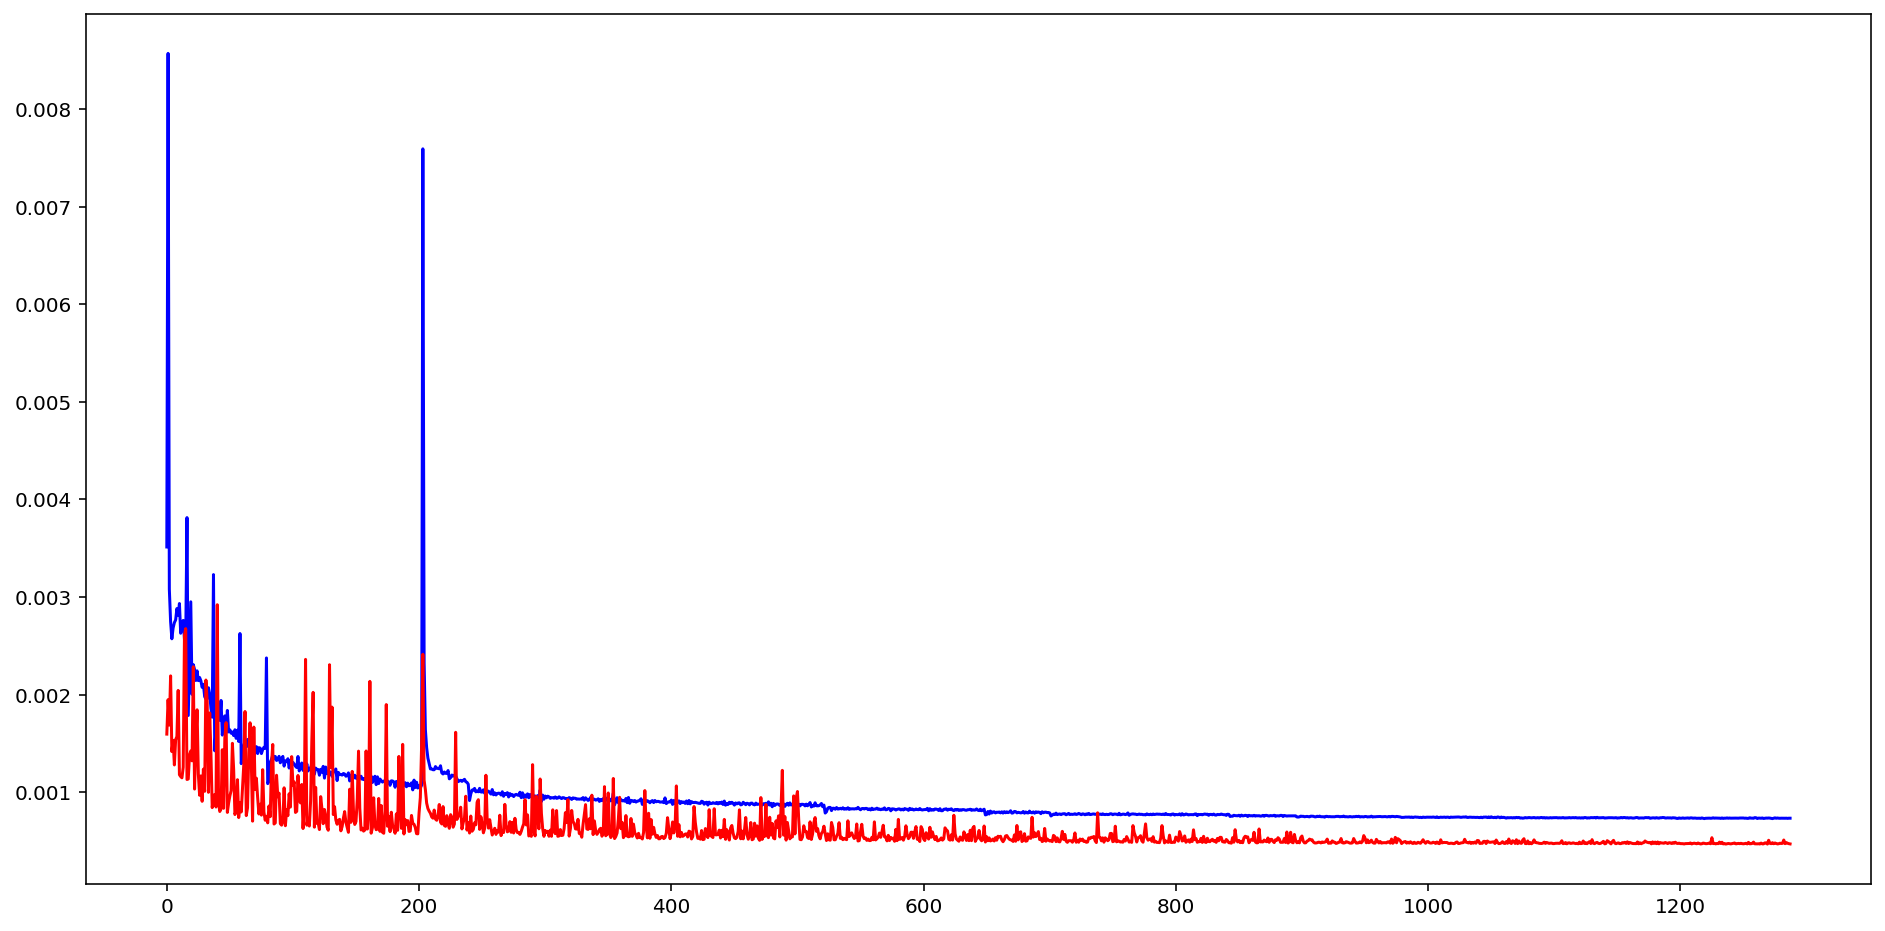

In [53]:
%config InlineBackend.figure_format ='retina'
plt.figure(figsize=(16,8))
plt.plot(trainLog[10:],'b',testLog[10:],'r')
plt.show()

In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

#myDevice, useGPU = myTorch.deviceGPU(clearCache = True, printInfo = True)
#myNet = MyModel(modelName=myModelName, altType=False, dataWidth=dataWidth, updateCNN=[1,1,-1,1]).to(myDevice)

modelDict = torch.load(modelName+'_Max.pth')
myNet.load_state_dict(modelDict['modelState'])

testSize = len(testX)
outData = np.zeros((testSize,dataWidth),dtype=np.float32)
outScore=np.zeros(testSize,dtype=np.float32)

with torch.no_grad():
    lossSum, lossMax = 0, 0
    for i, (inZ, trueY, outY) in enumerate(zip(testZ,testY,outData)):
        if useGPU: inZ, trueY  = inZ.cuda(non_blocking=True), trueY.cuda(non_blocking=True)

        netY = myNet(inZ).view(-1)
        lossT = torch.nn.functional.l1_loss(netY, trueY)
        if useGPU:
            netY=netY.cpu()
            lossT=lossT.cpu()
        
        outY[:]=netY.numpy()
        outScore[i]=lossT
            
        lossSum += lossT
        if lossT>lossMax: lossMax=lossT
        if i%5000 == 0: print(f'{i:7d} data are processed..')

    print(f'loss : {lossSum/testSize:.7f}, loss max : {lossMax:.7f}')

      0 data are processed..
   5000 data are processed..
  10000 data are processed..
  15000 data are processed..
  20000 data are processed..
  25000 data are processed..
  30000 data are processed..
  35000 data are processed..
loss : 0.0004678, loss max : 0.0031815


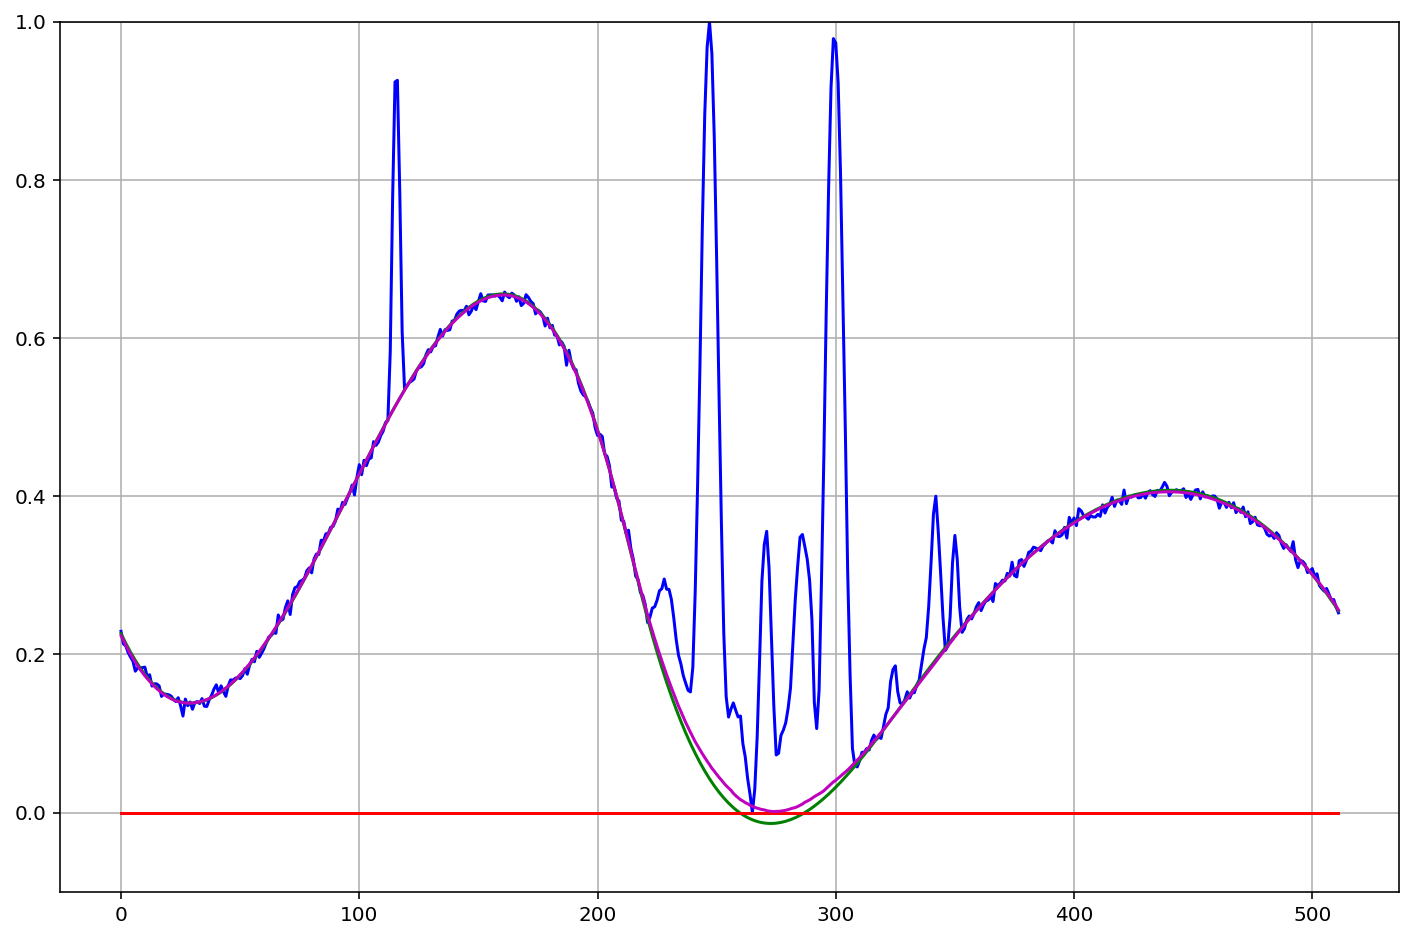

error=0.0031815231777727604


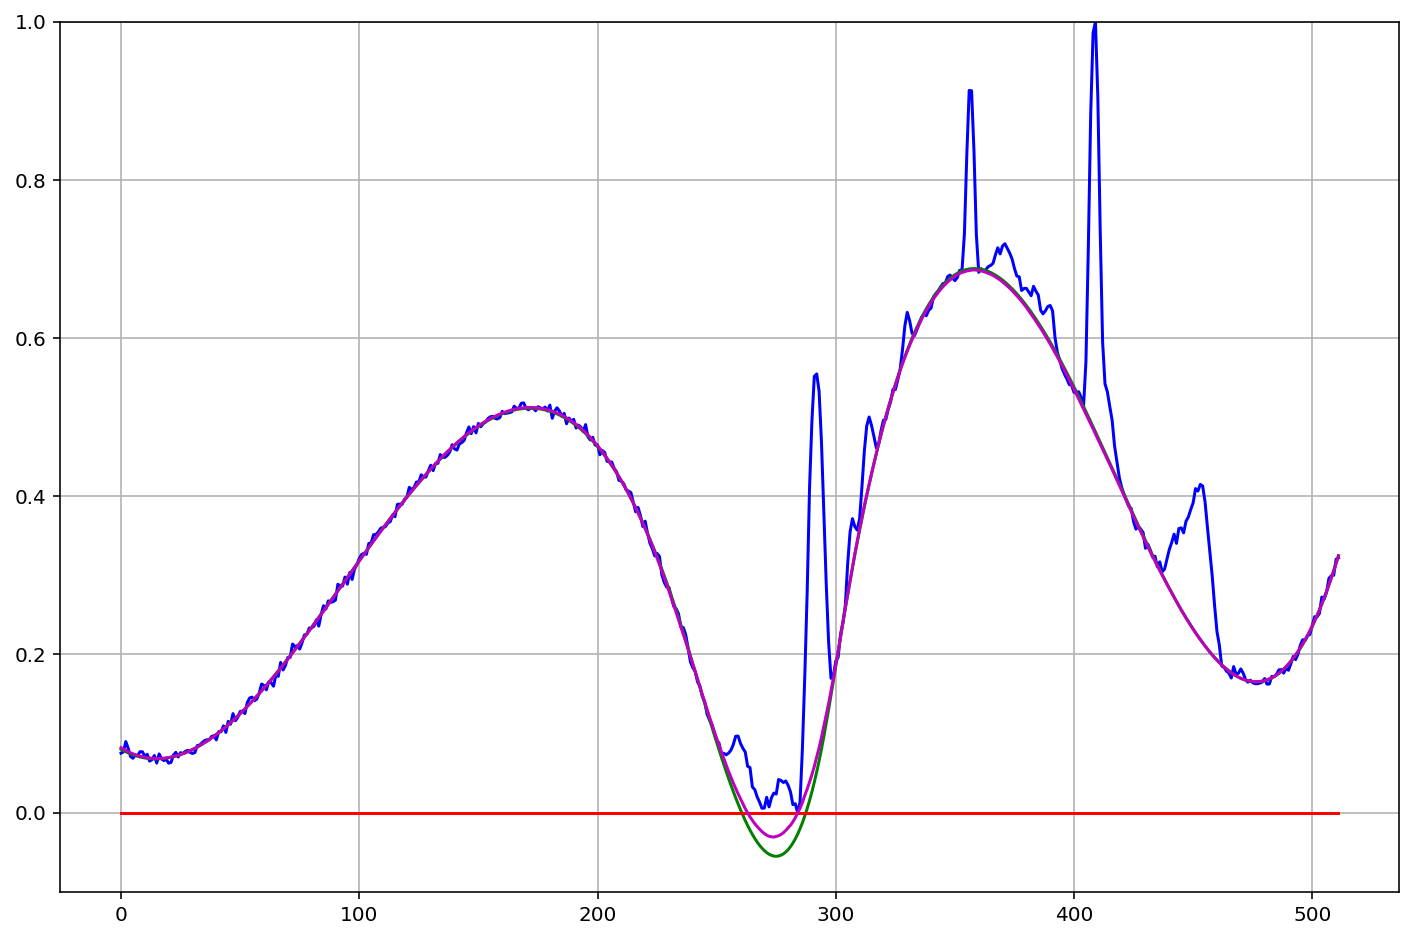

error=0.002626202069222927


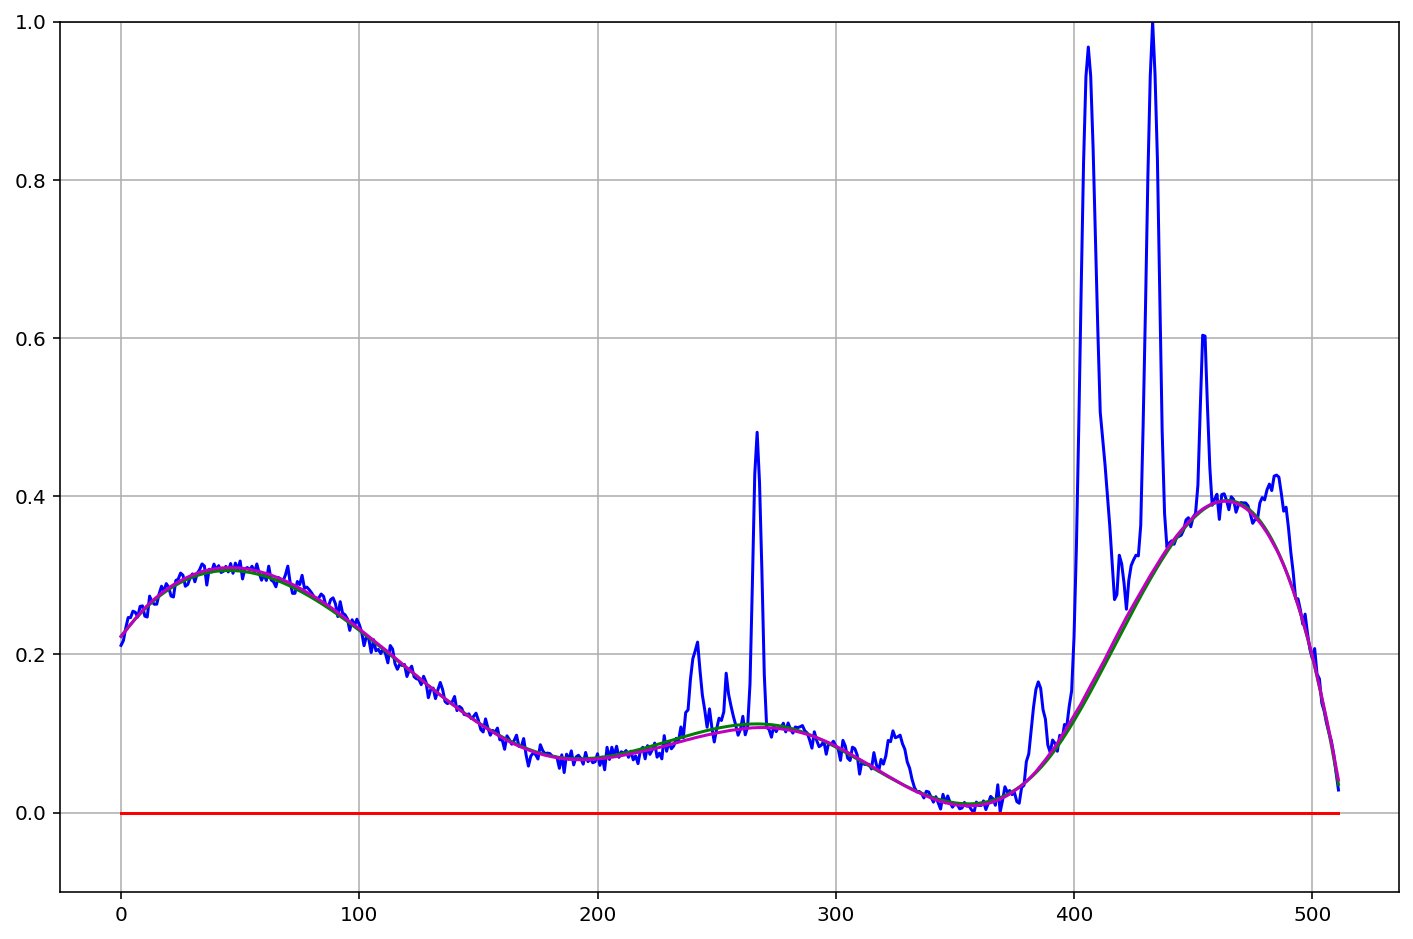

error=0.002506693359464407


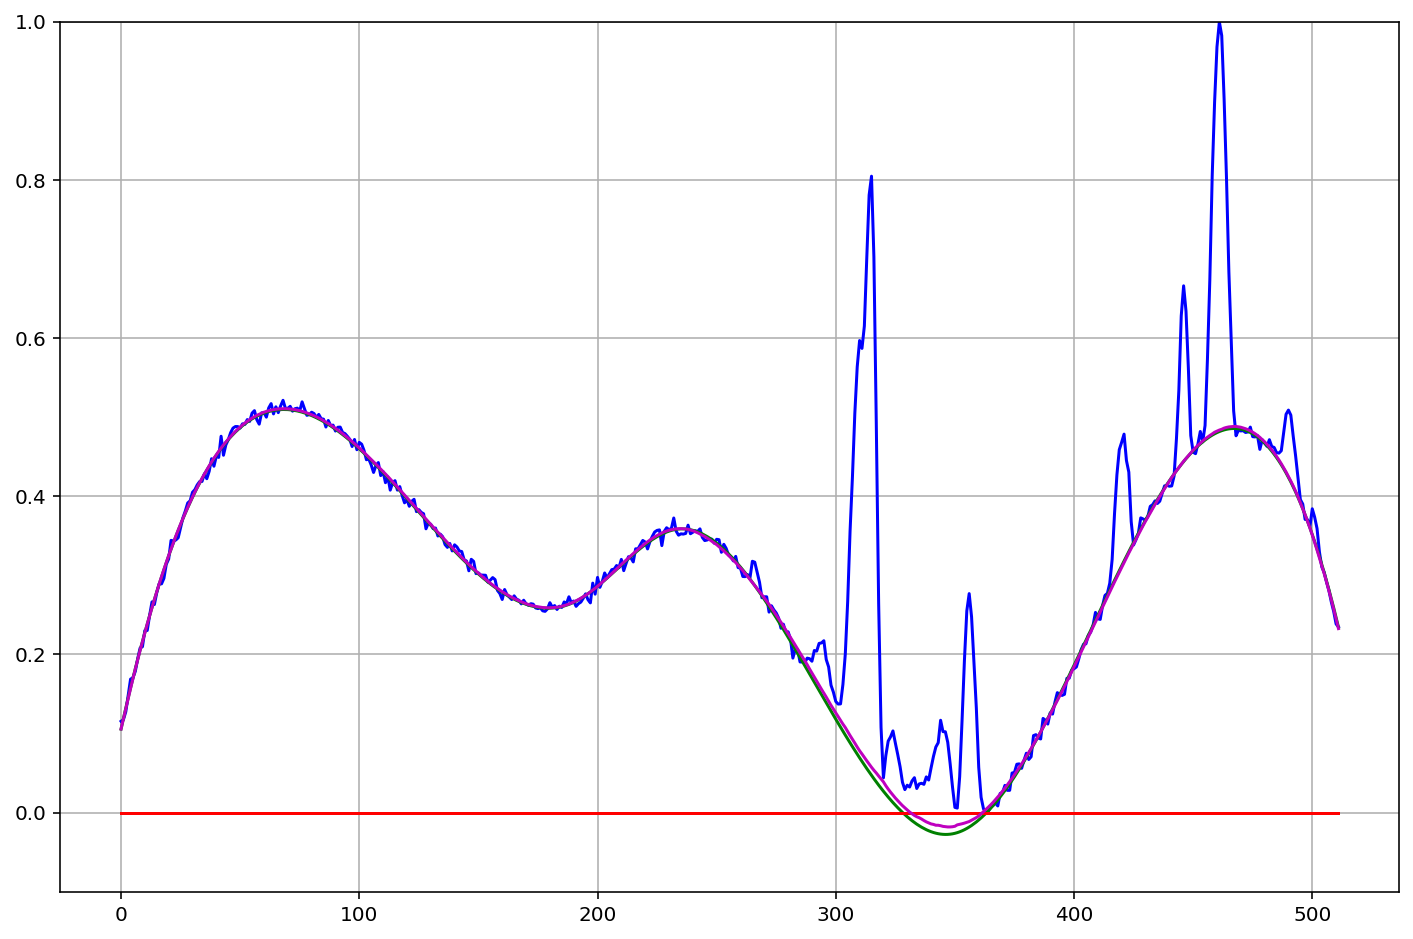

error=0.002361186547204852


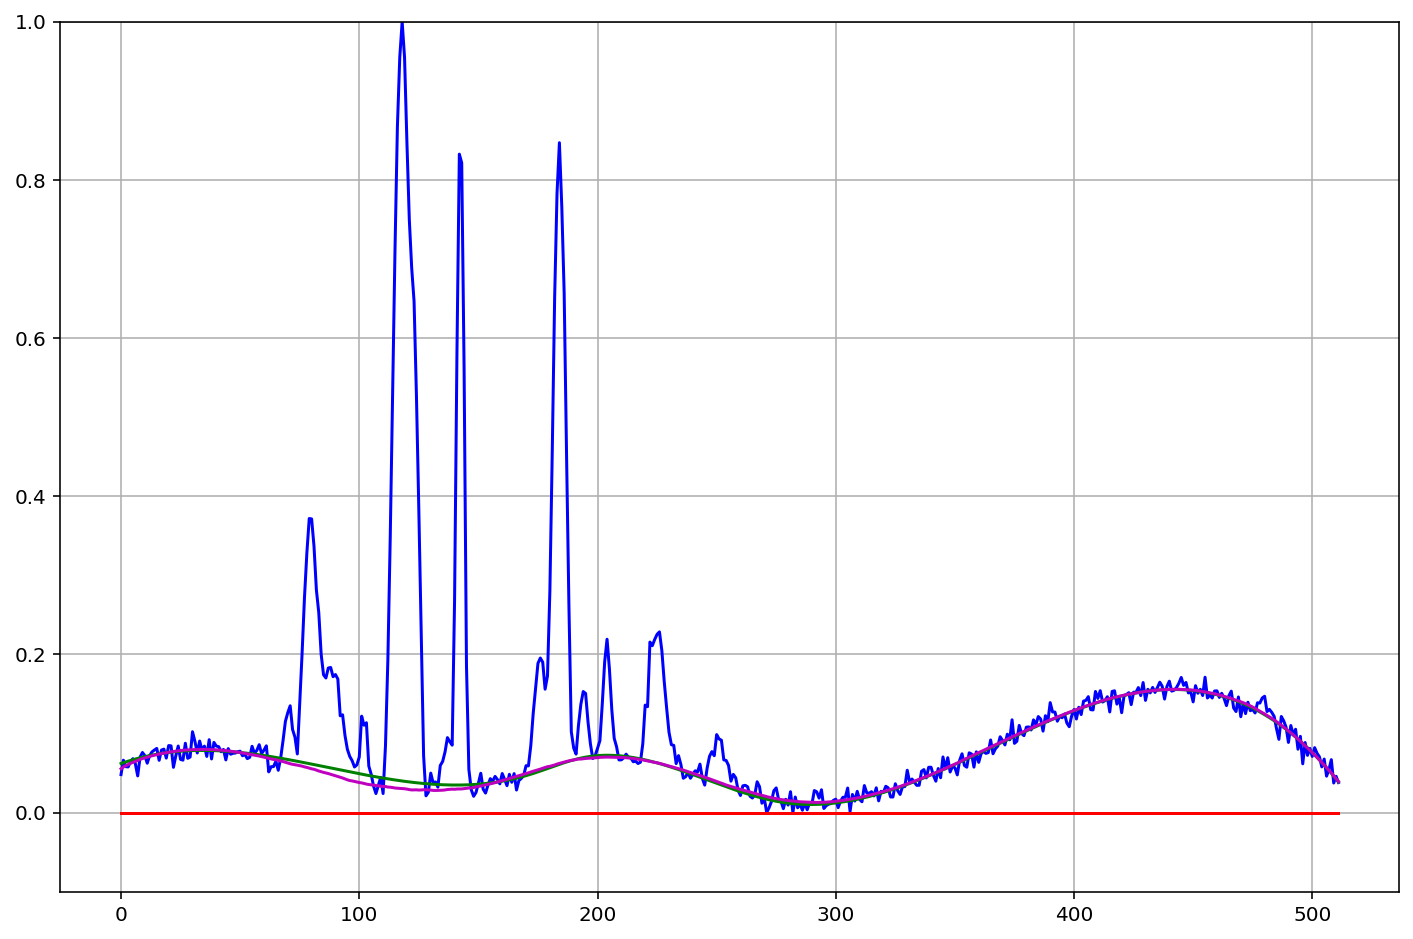

error=0.0023175575770437717


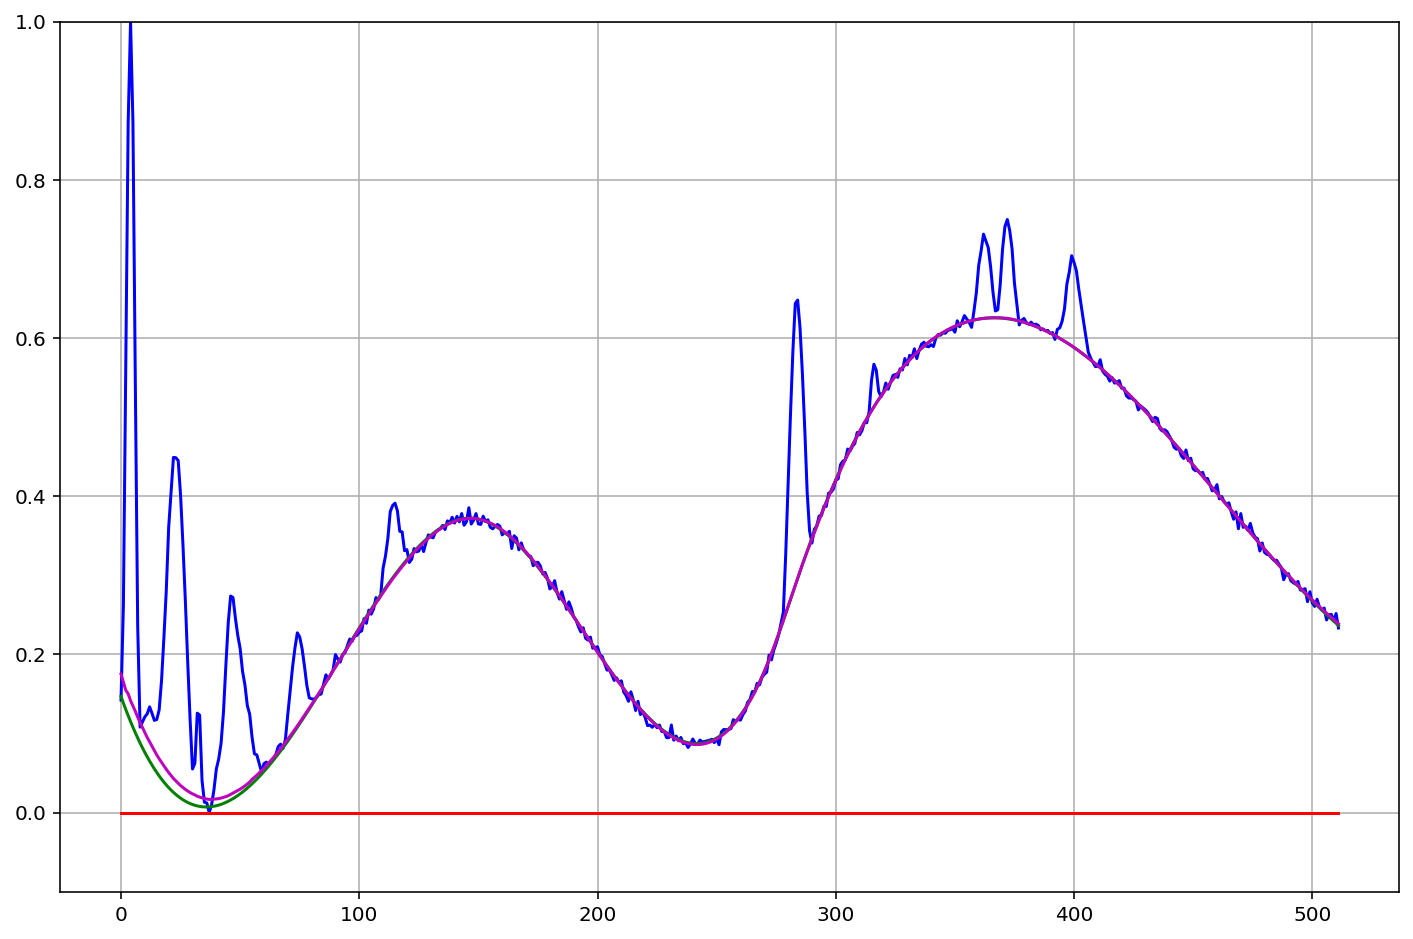

error=0.002306905575096607


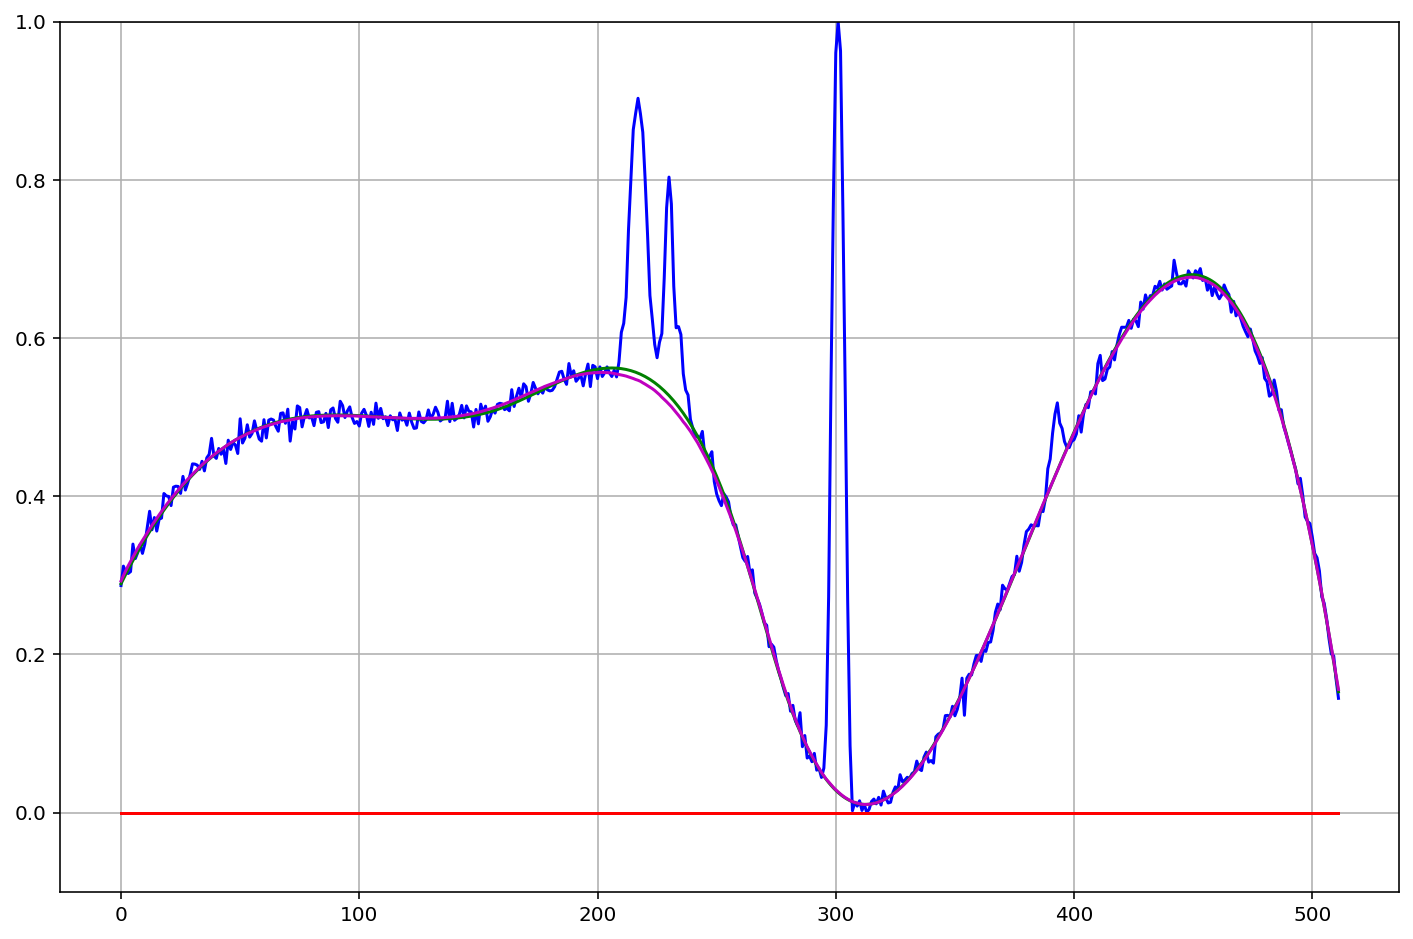

error=0.002289162017405033


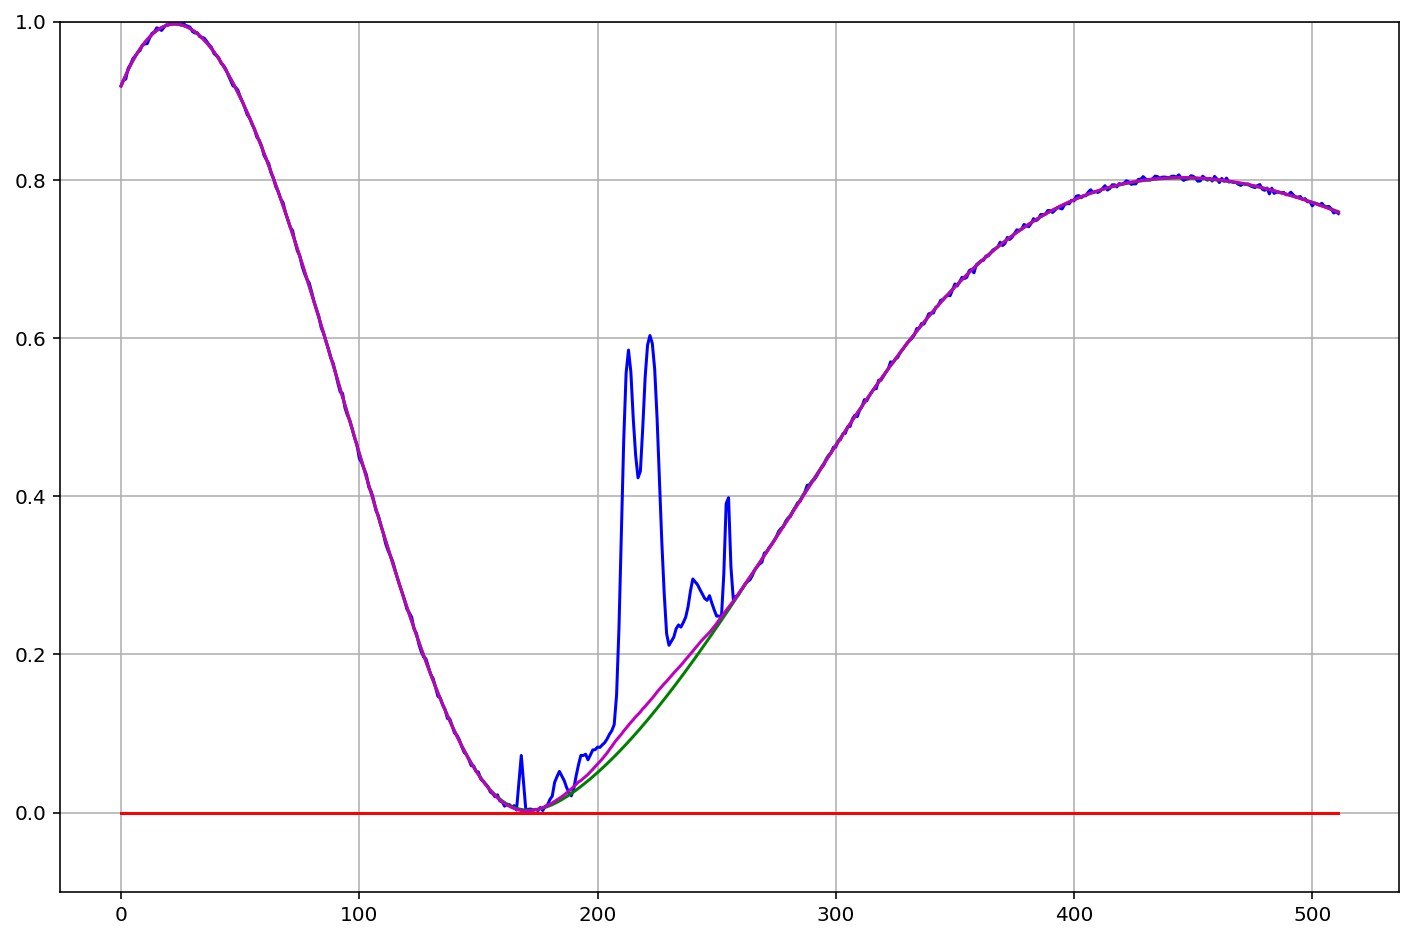

error=0.002205673372372985


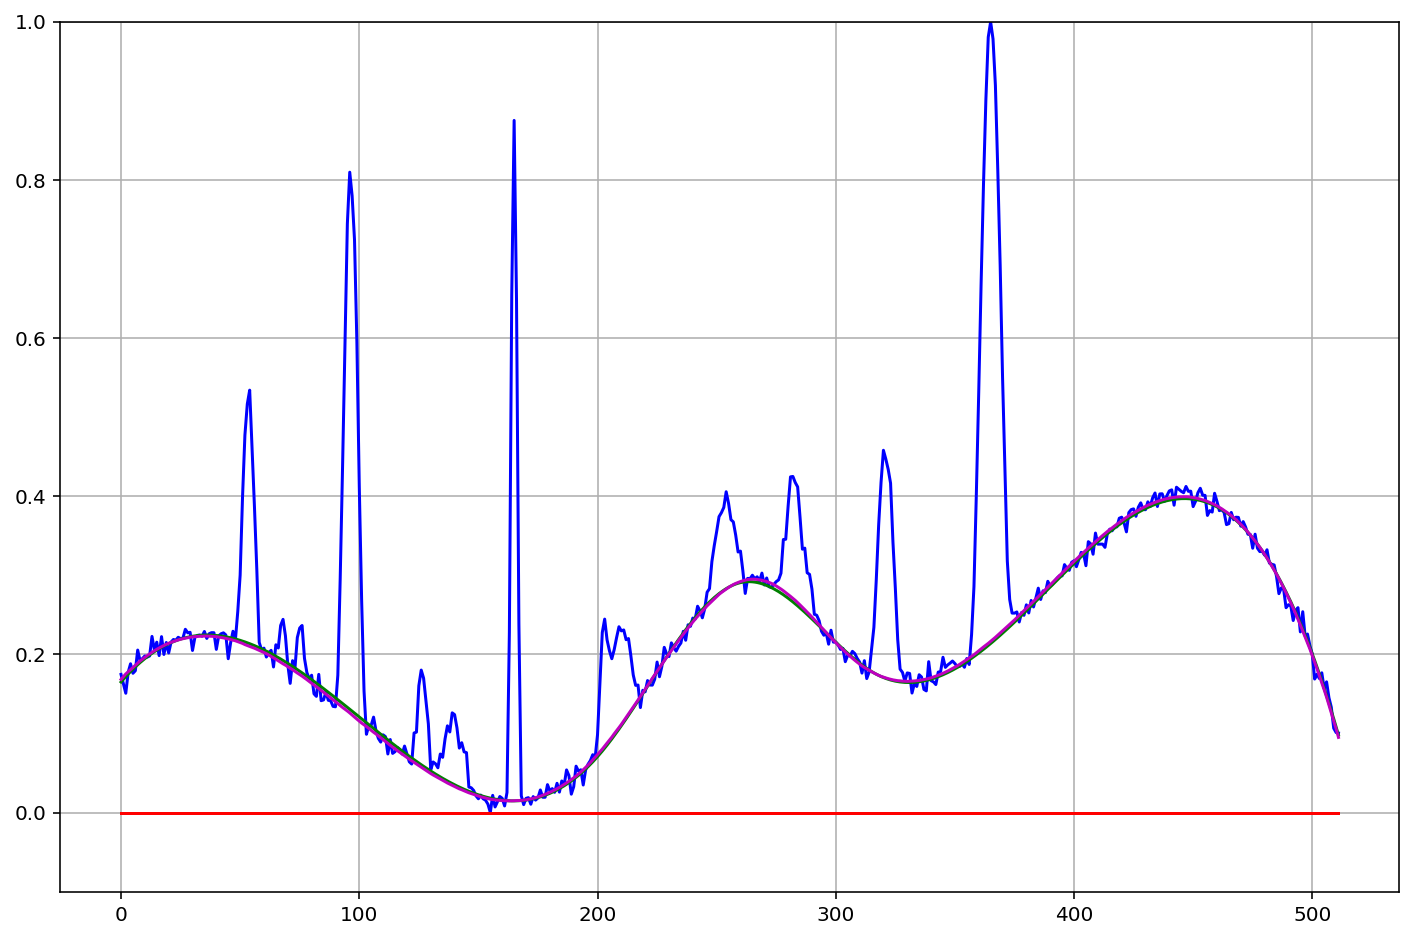

error=0.002175598870962858


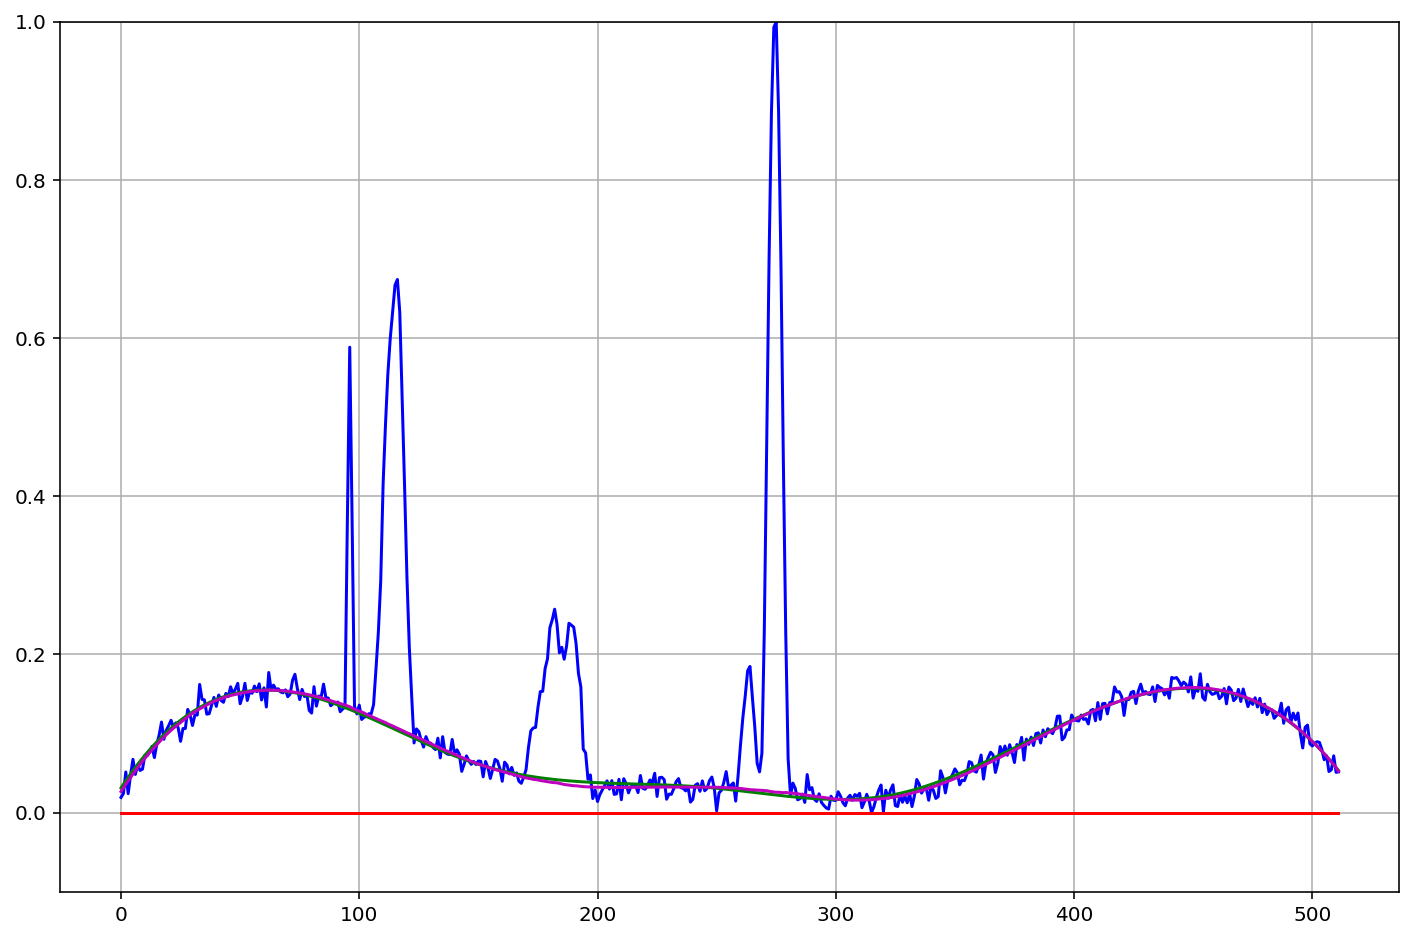

error=0.0021729327272623777


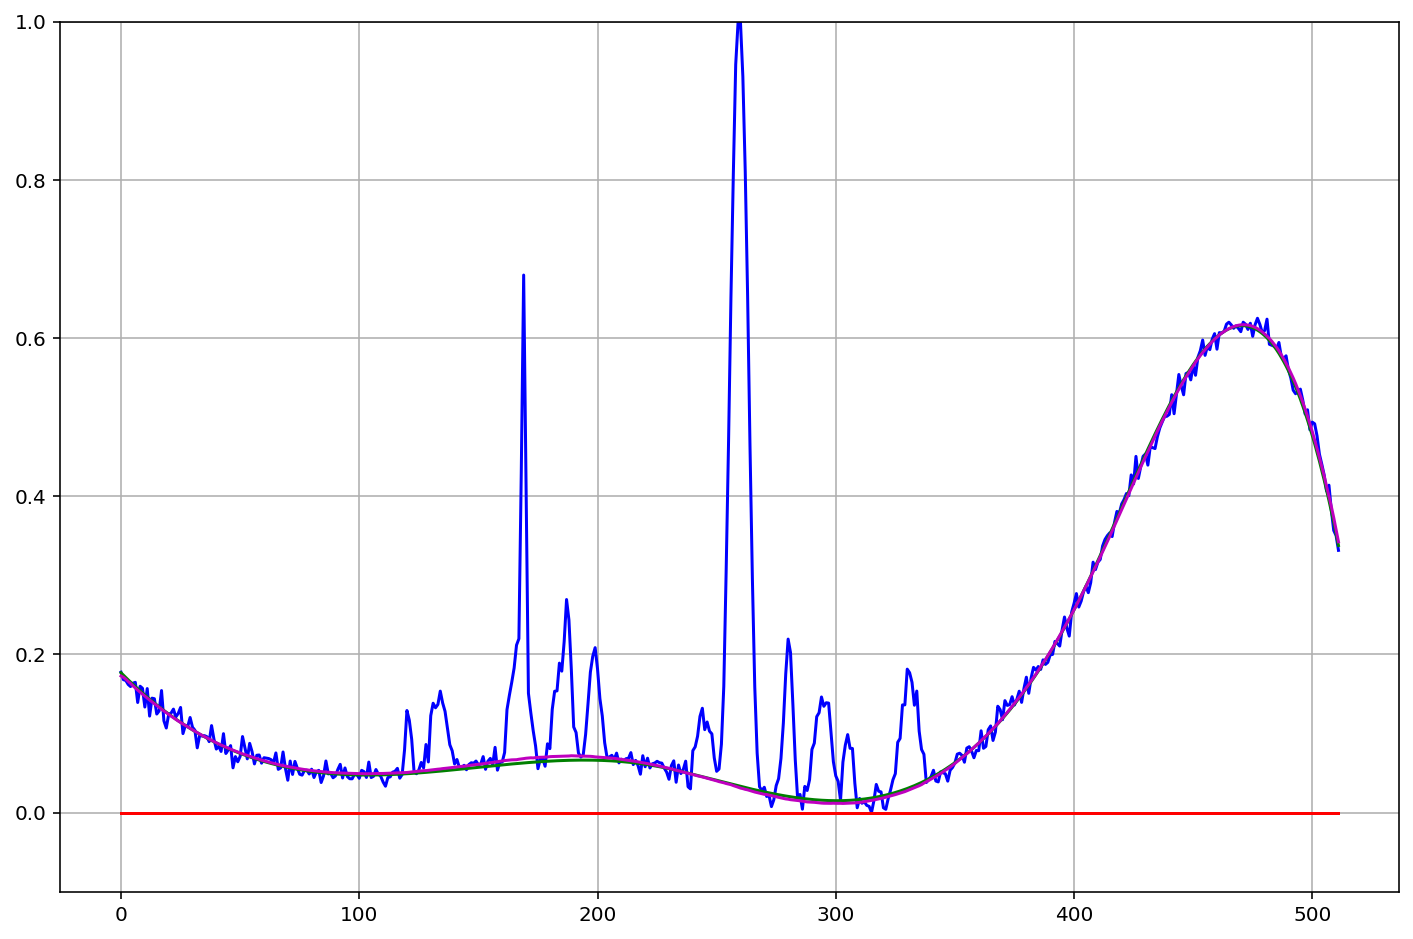

error=0.0021488915663212538


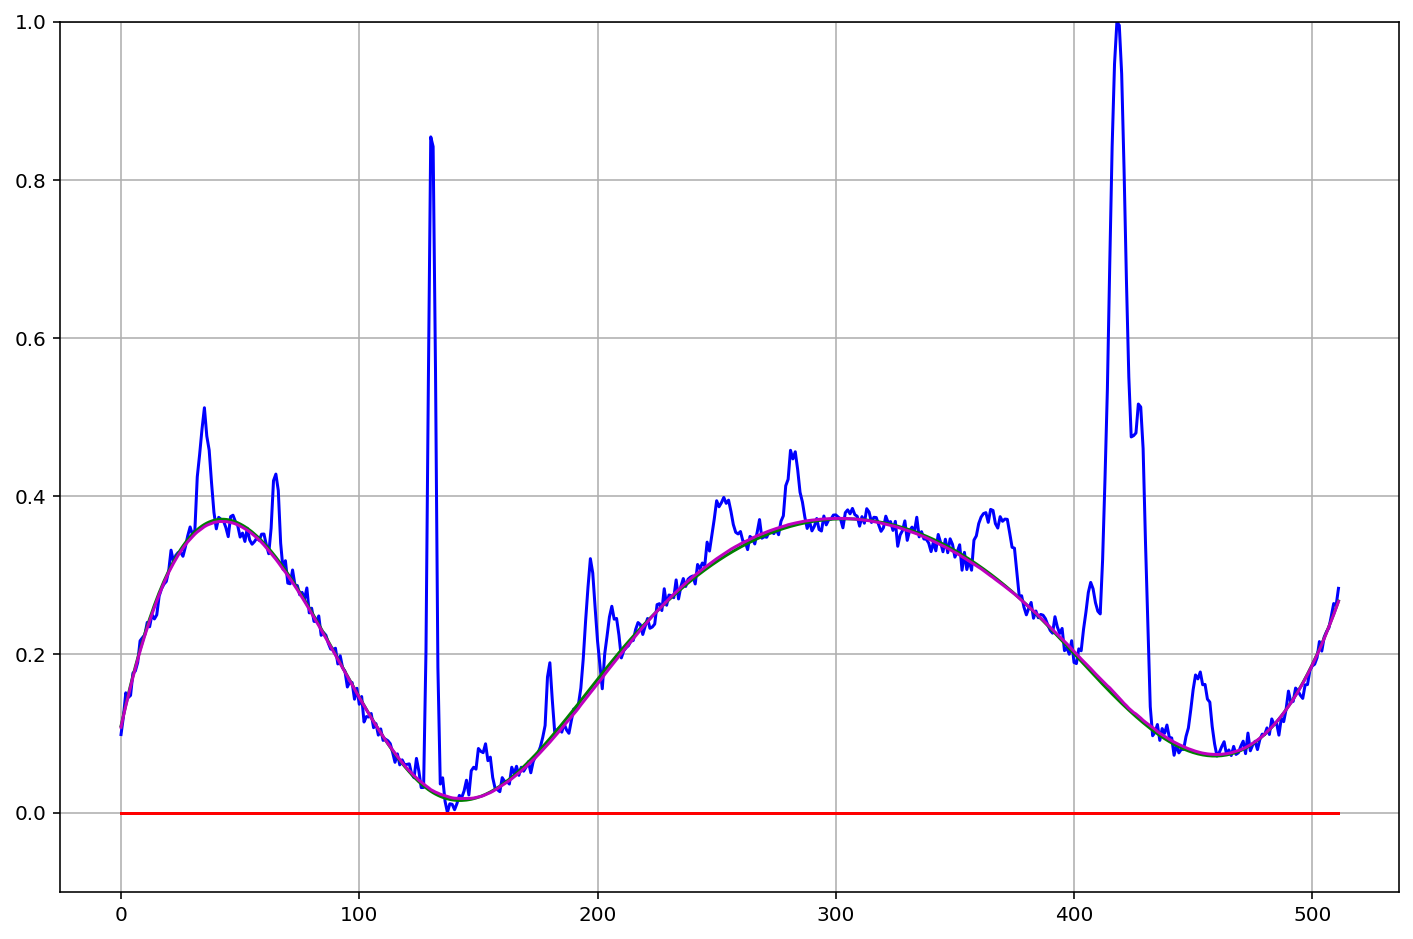

error=0.0021424023434519768


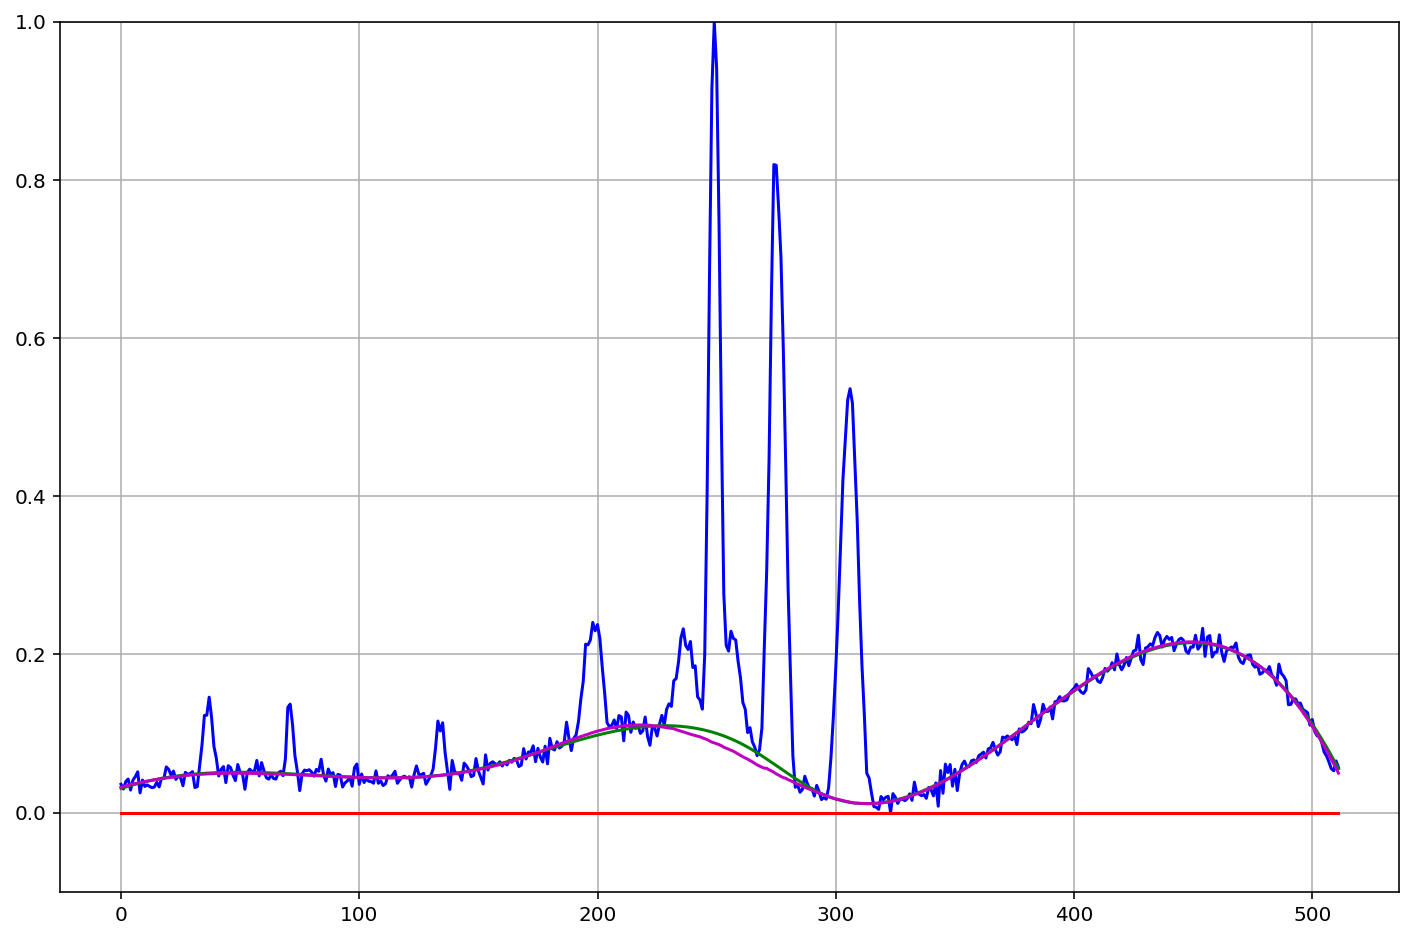

error=0.0021204426884651184


In [55]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

#%matplotlib tk
#%matplotlib inline

#plt.rcParams["figure.figsize"] = (8,6)
orderScore=np.flip(np.argsort(outScore))
for idx in orderScore[:13]:
    dataZ=testZZ[idx];
    dataY=testYY[idx];
    plt.figure(figsize=(12,8))
    plt.ylim(-0.1,1)
    plt.plot(dataZ,'b')
    plt.plot(dataY,'g')            # draw the real baseline 
    #plt.plot(dataX-outputData[idx,:],'c')      # draw peaks
    plt.plot(np.zeros((len(dataZ),1)),'r')
    plt.plot(outData[idx],'m')  # draw the output baseline
    plt.grid(True)    
    plt.show()
    print(f'error={ np.mean(np.abs(dataY-outData[idx])) }')


dataSize : 40, dataLen : 1024


<ipython-input-56-f7008f14dfc7>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,8))


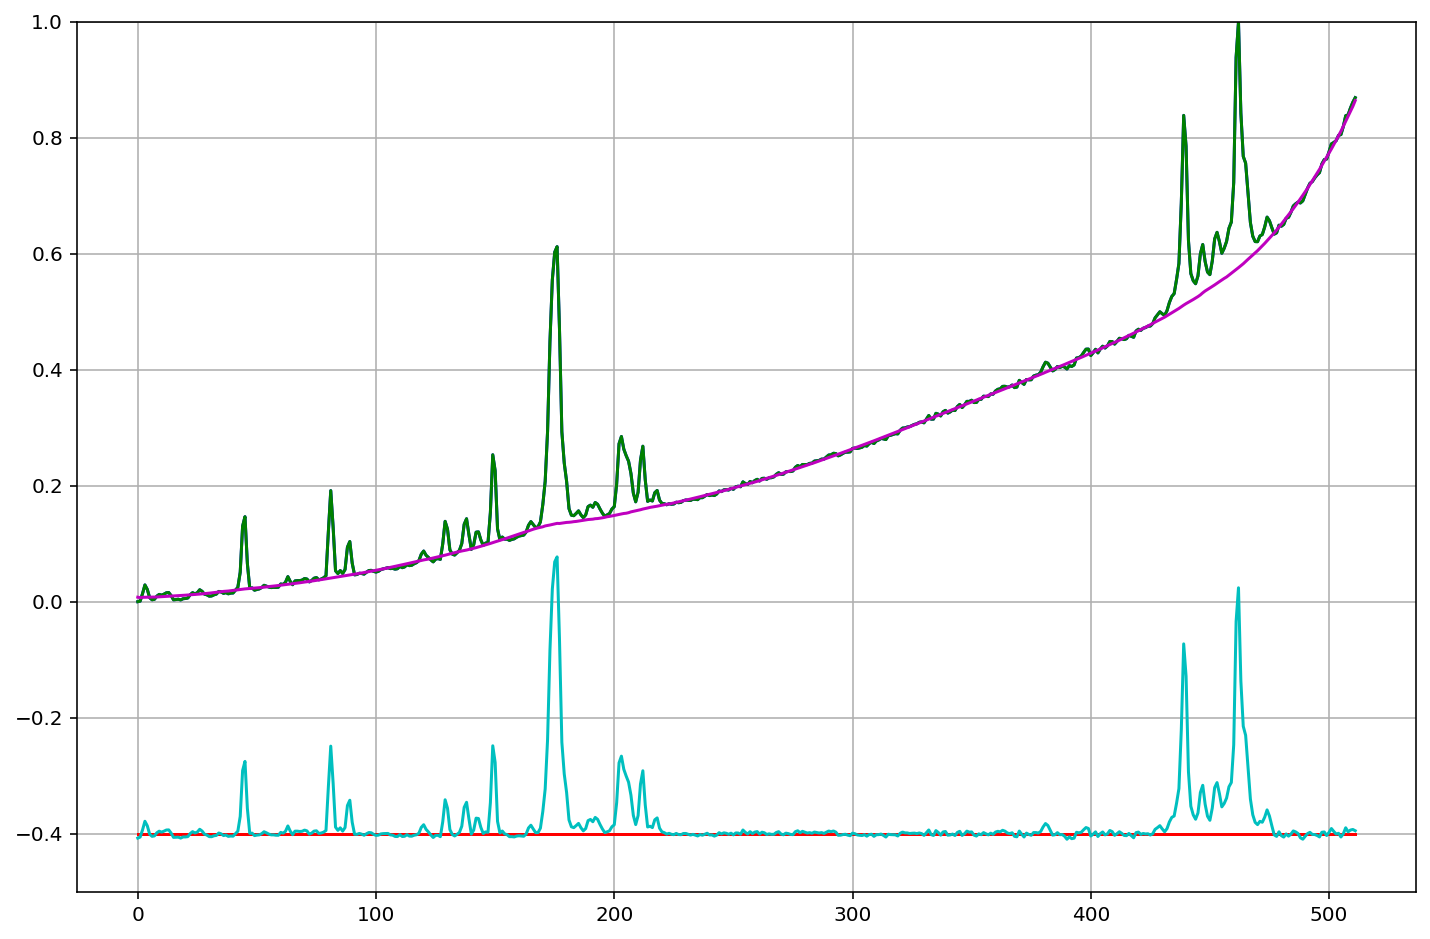

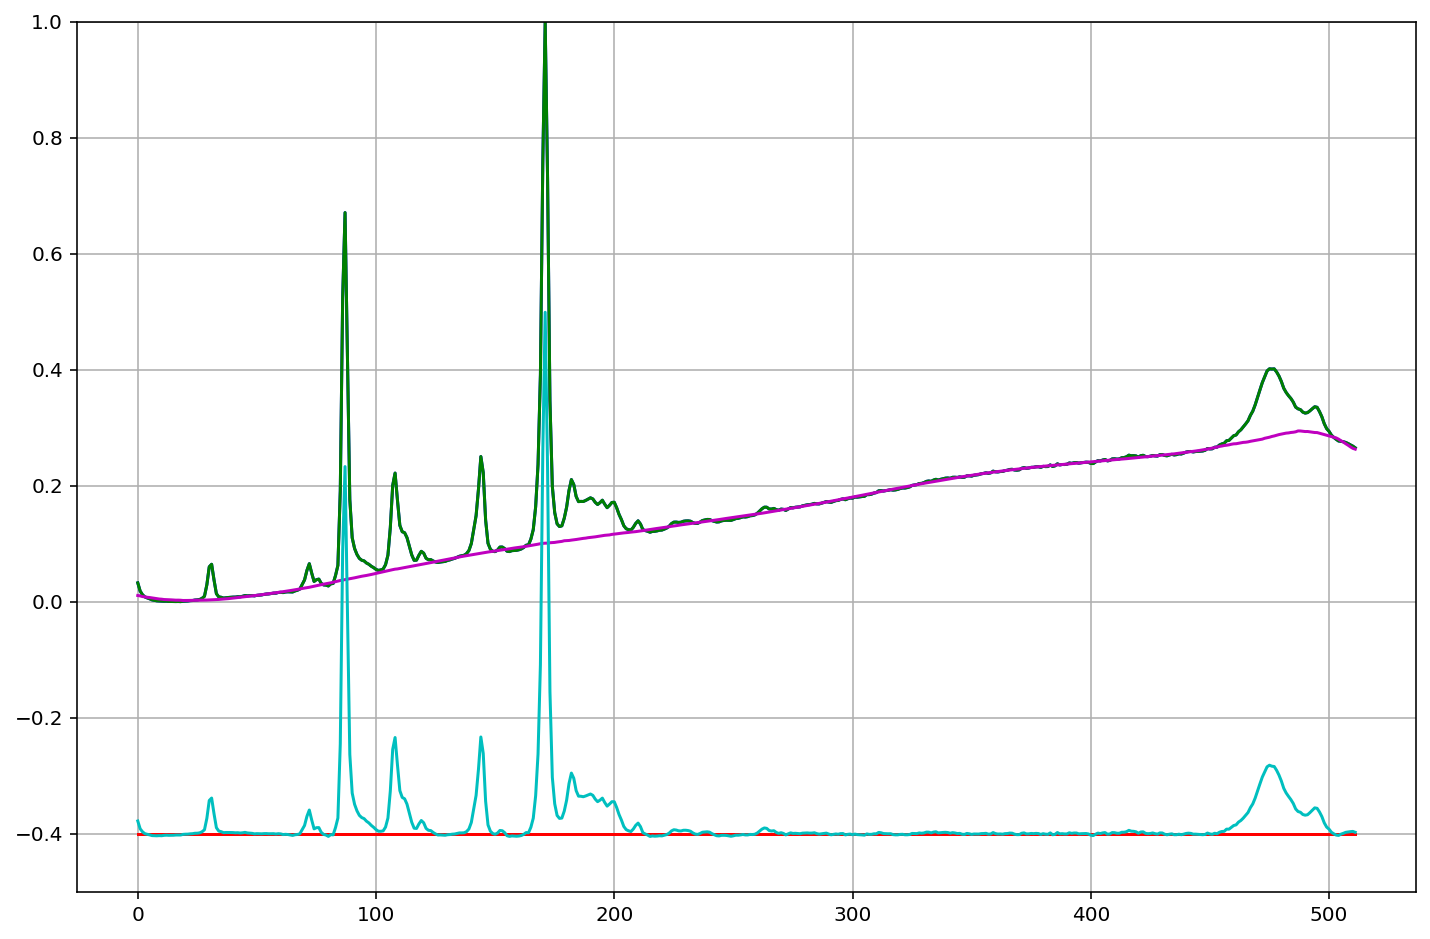

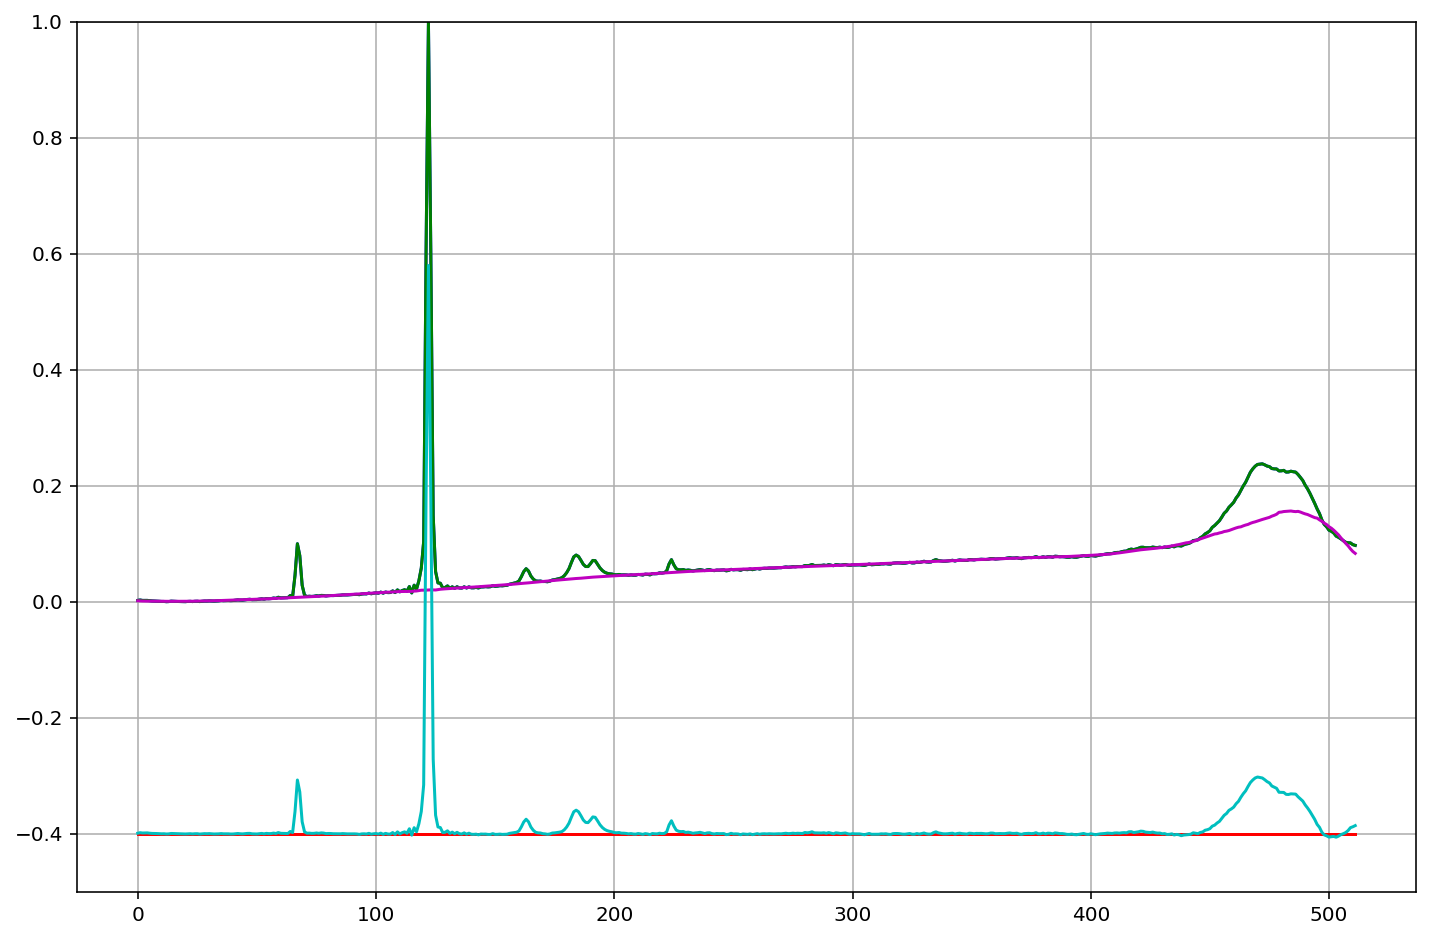

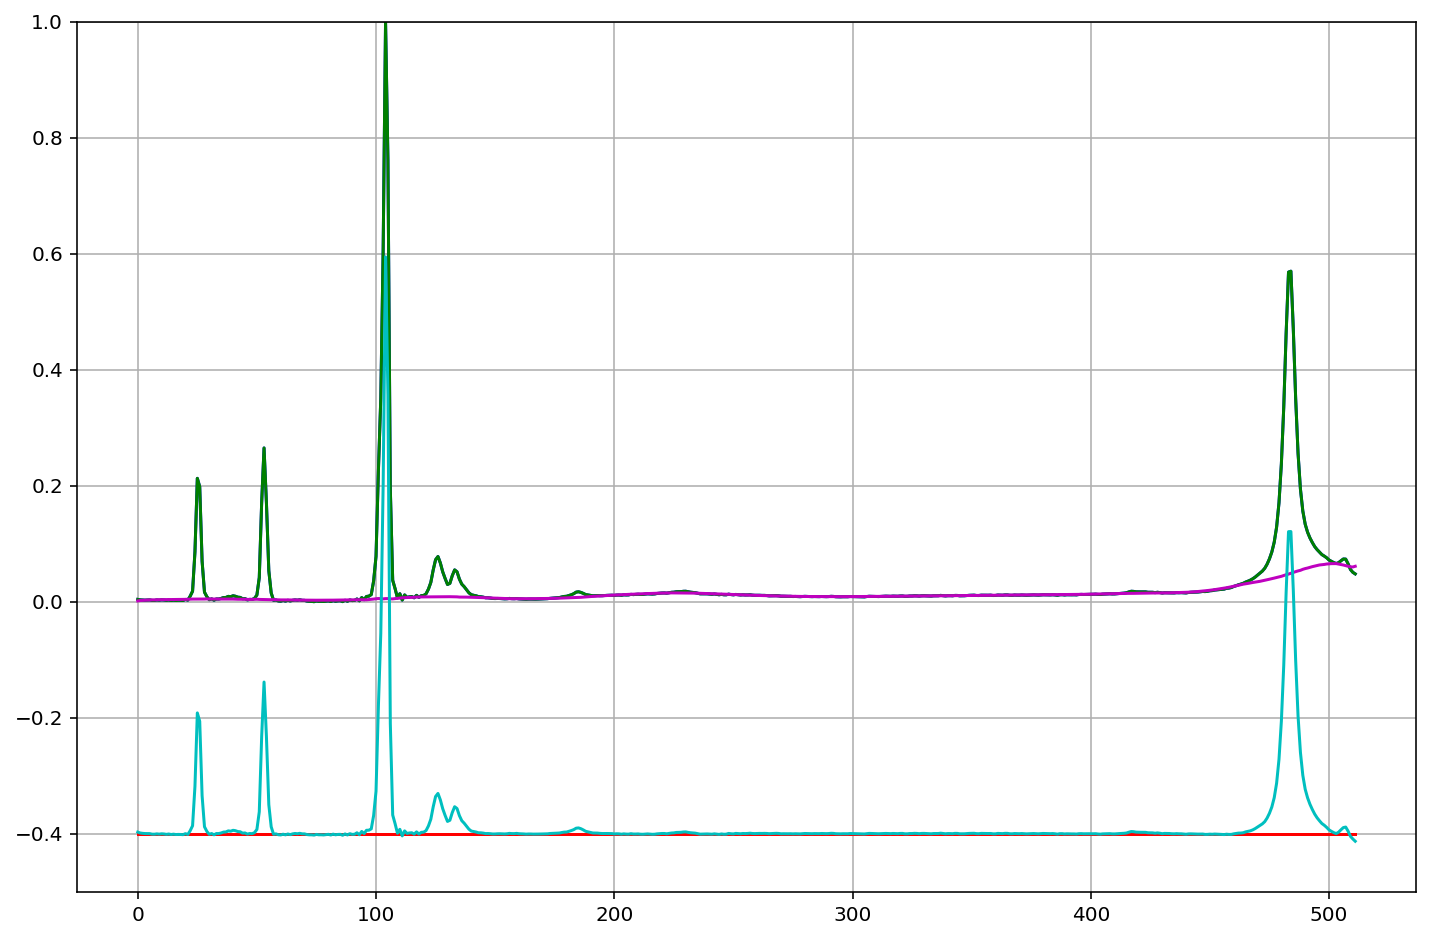

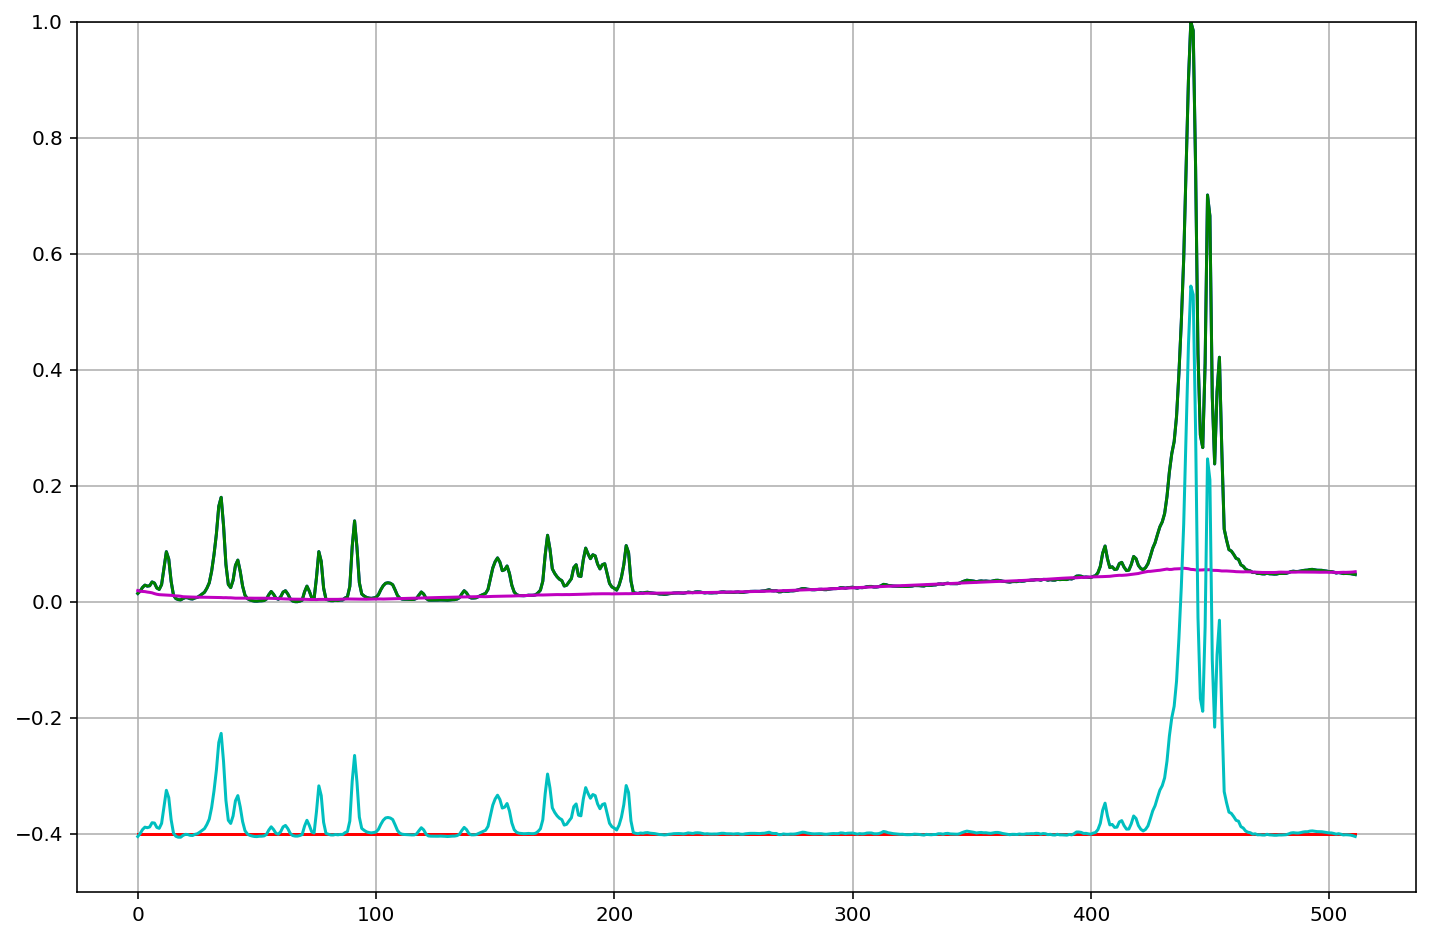

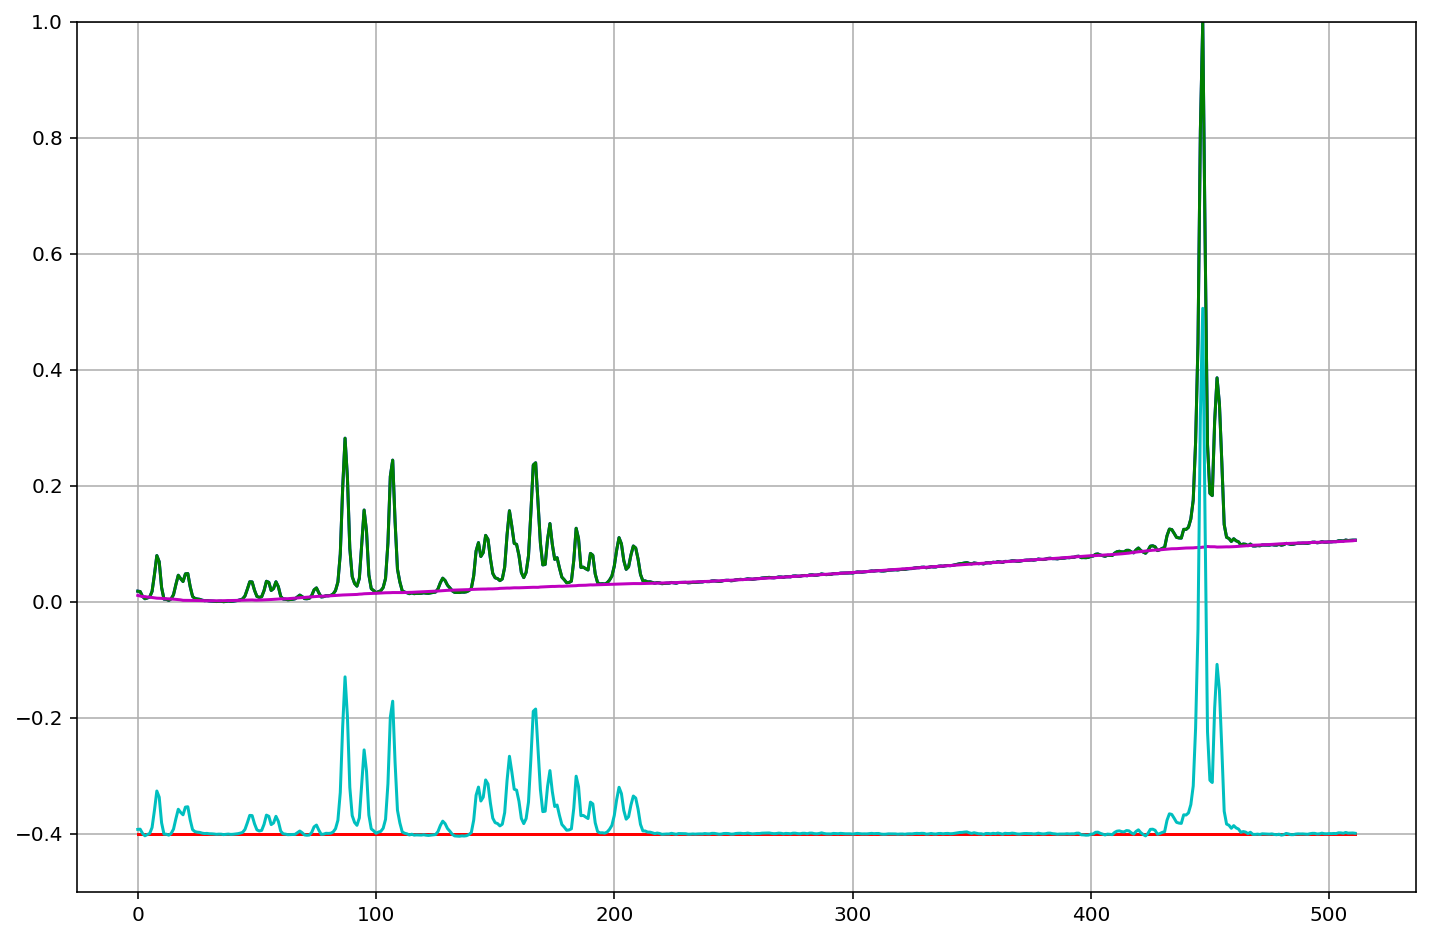

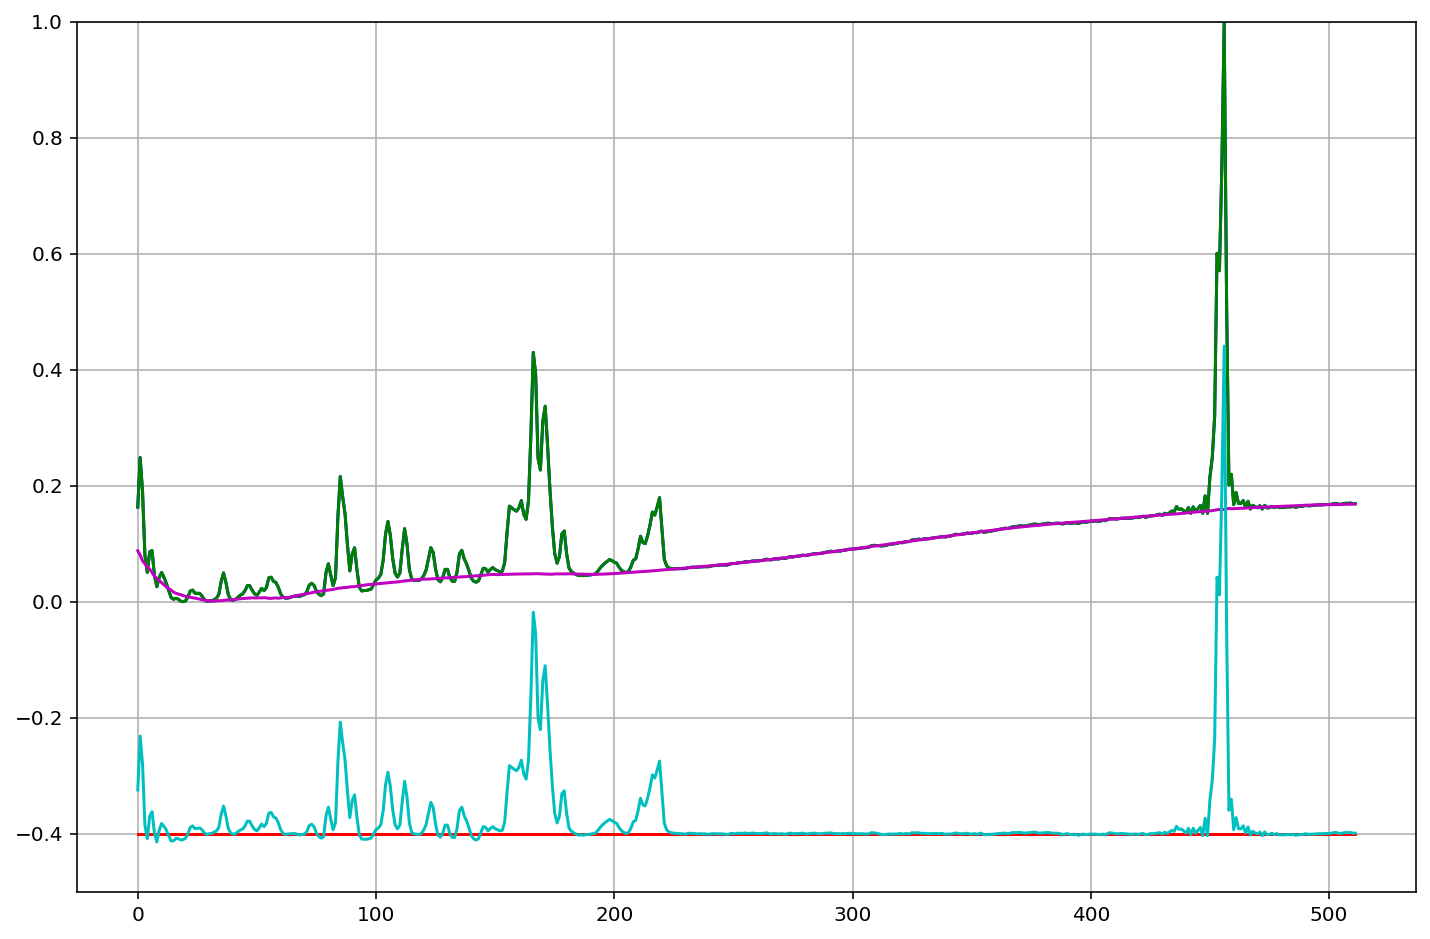

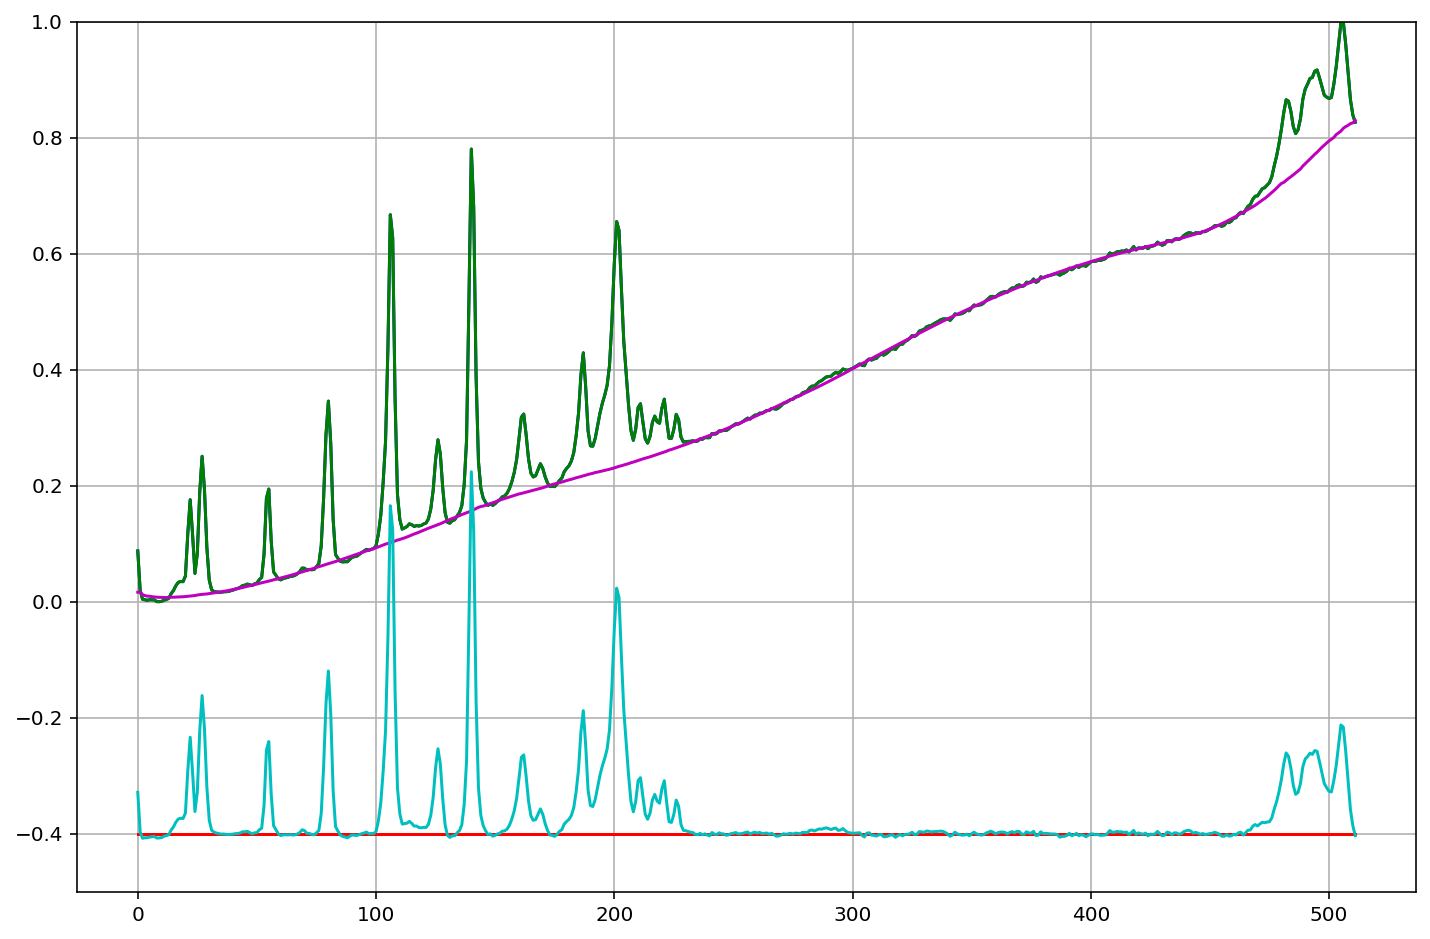

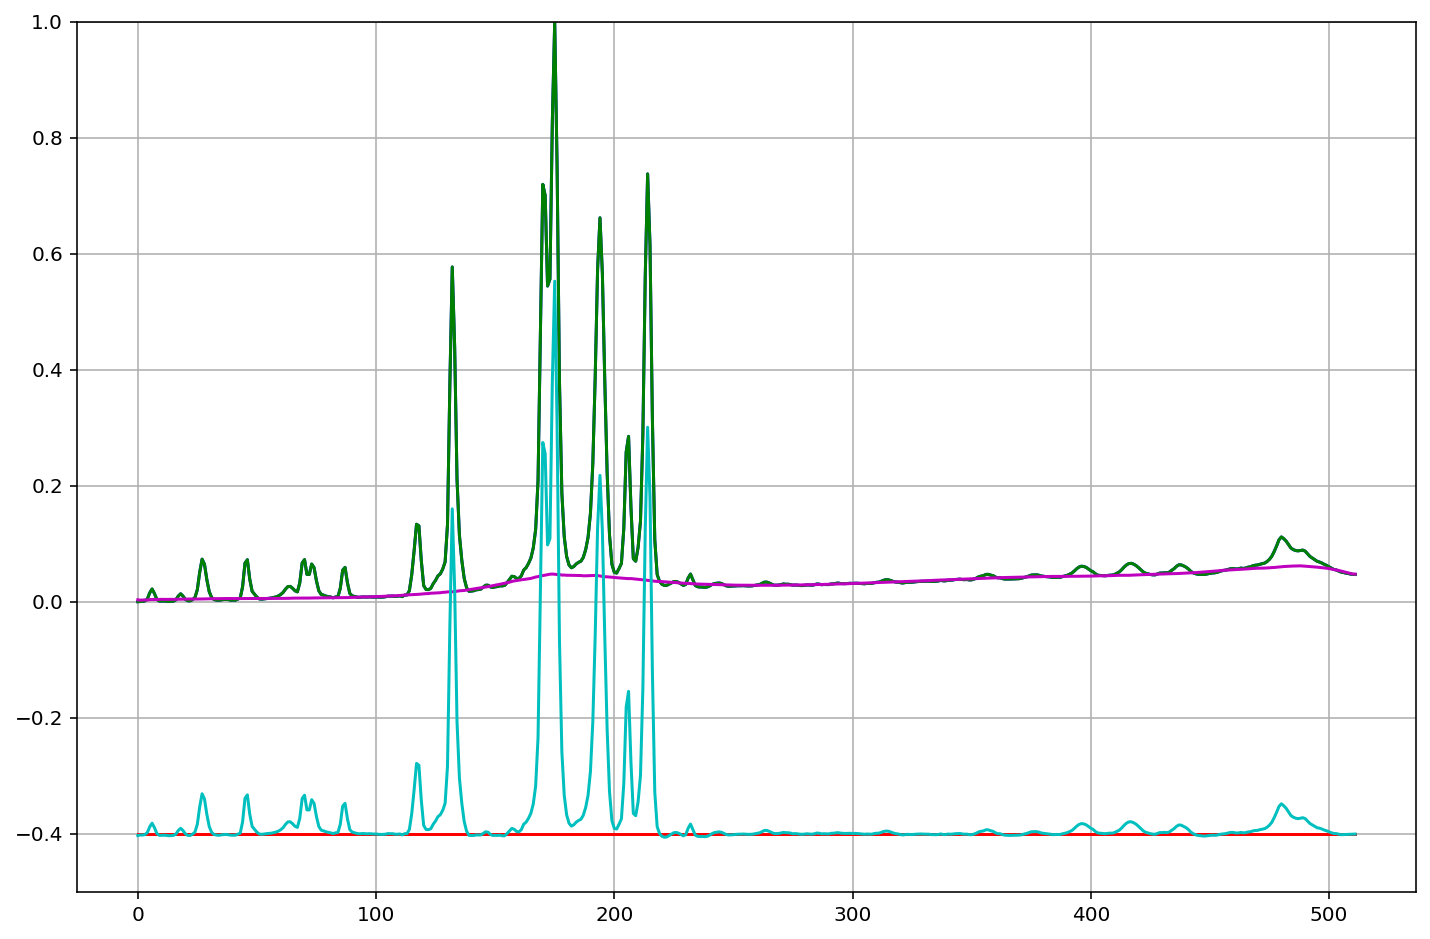

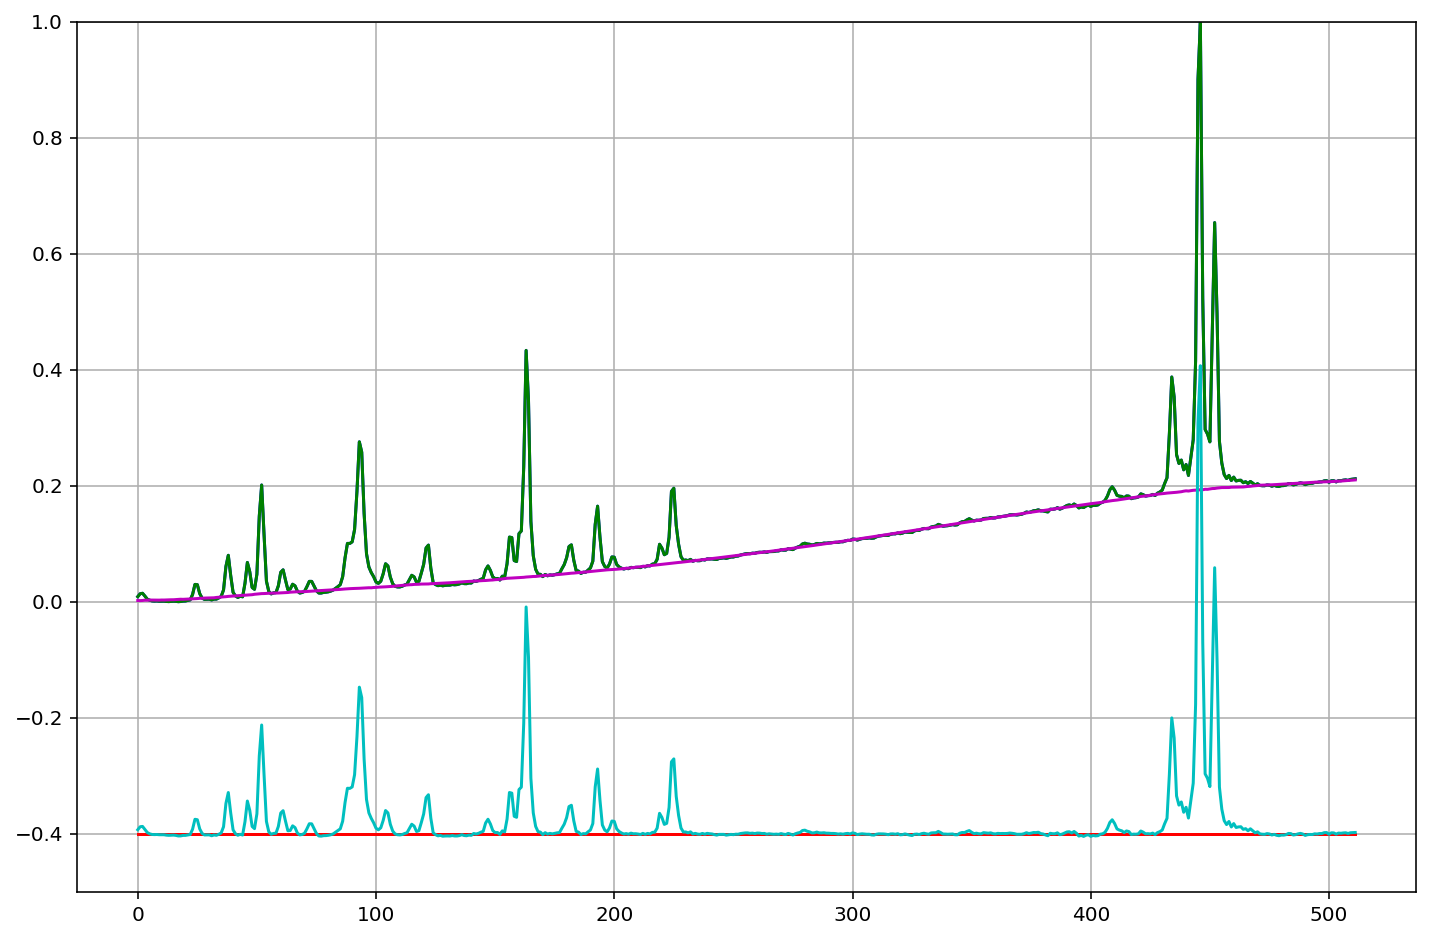

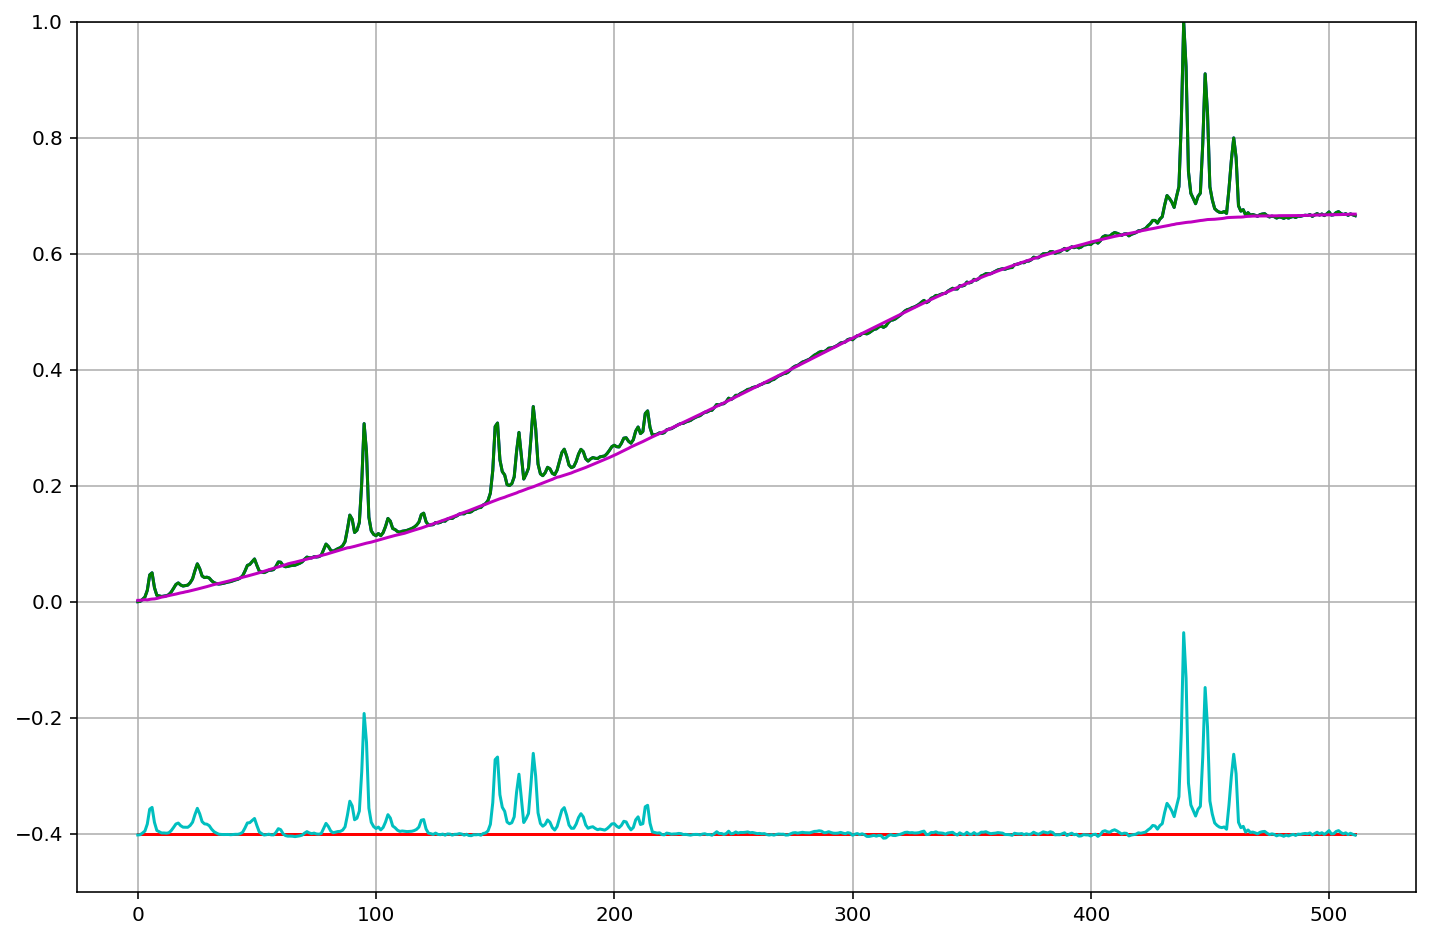

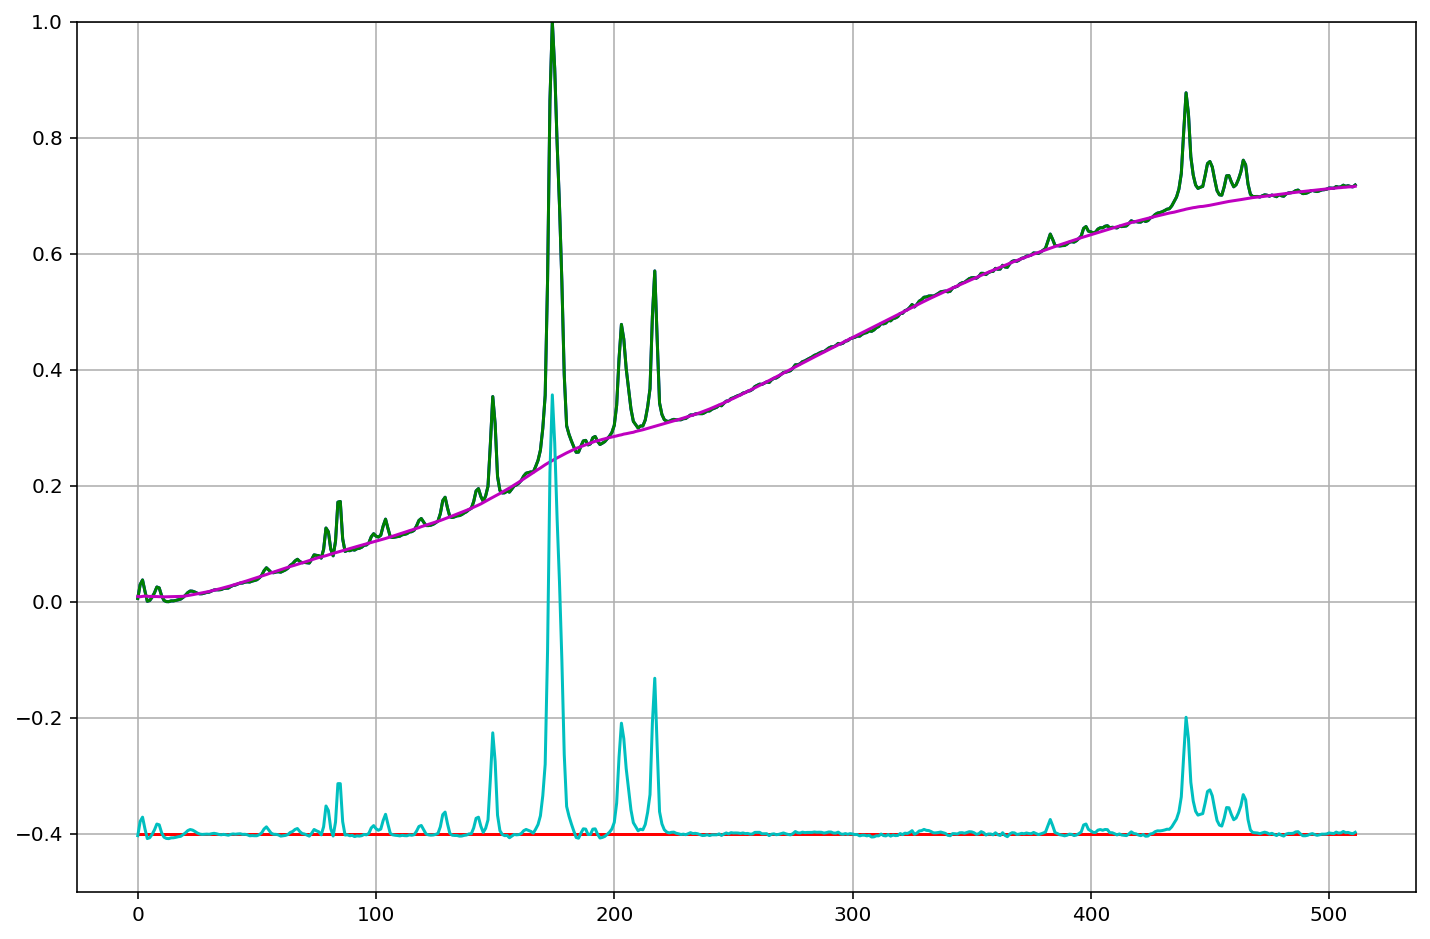

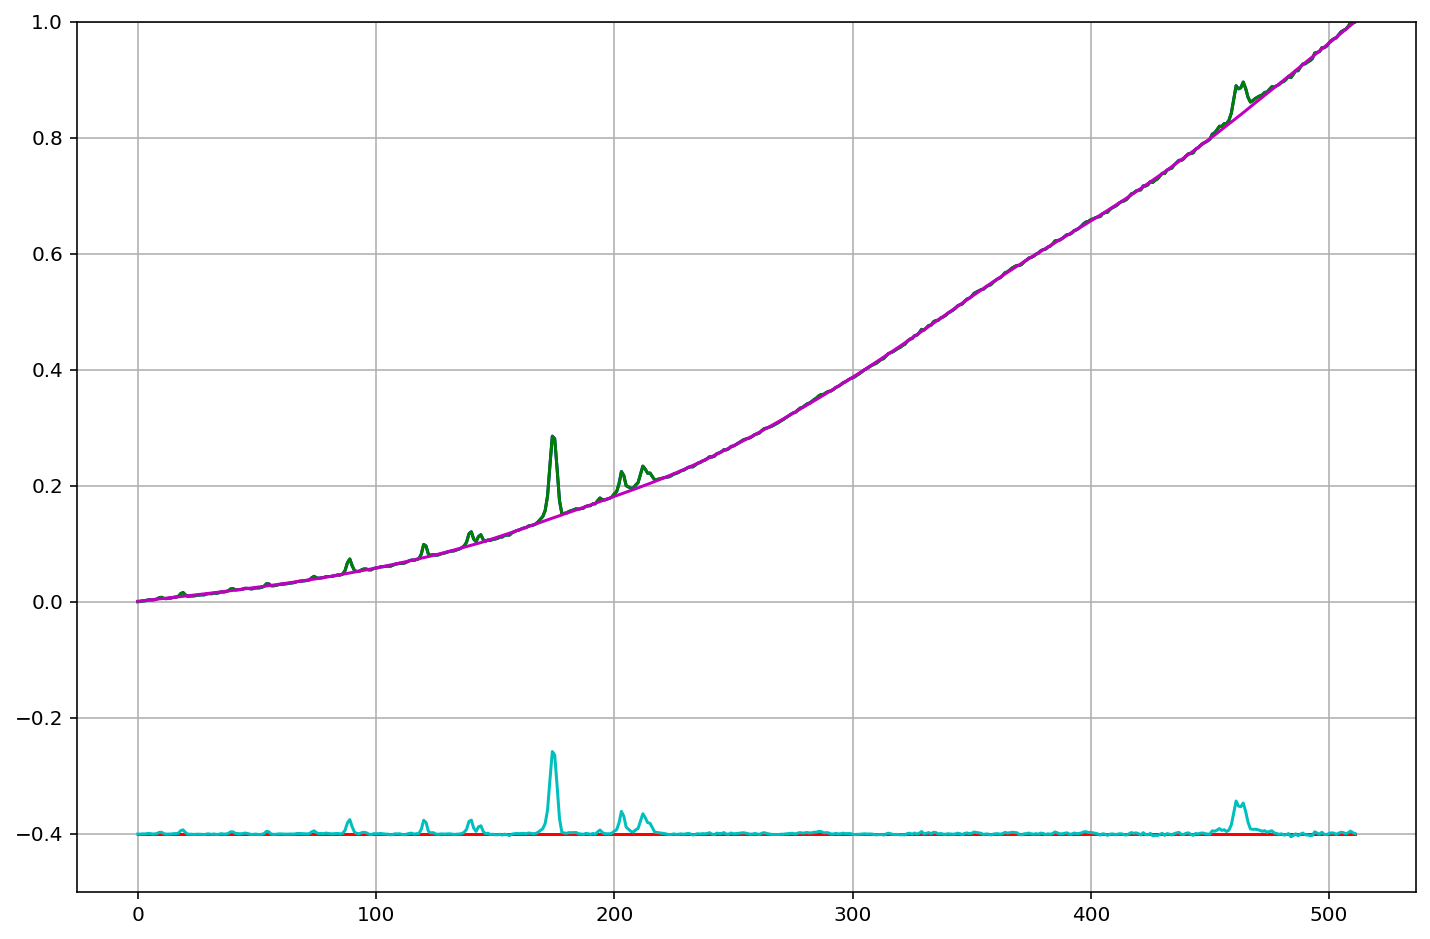

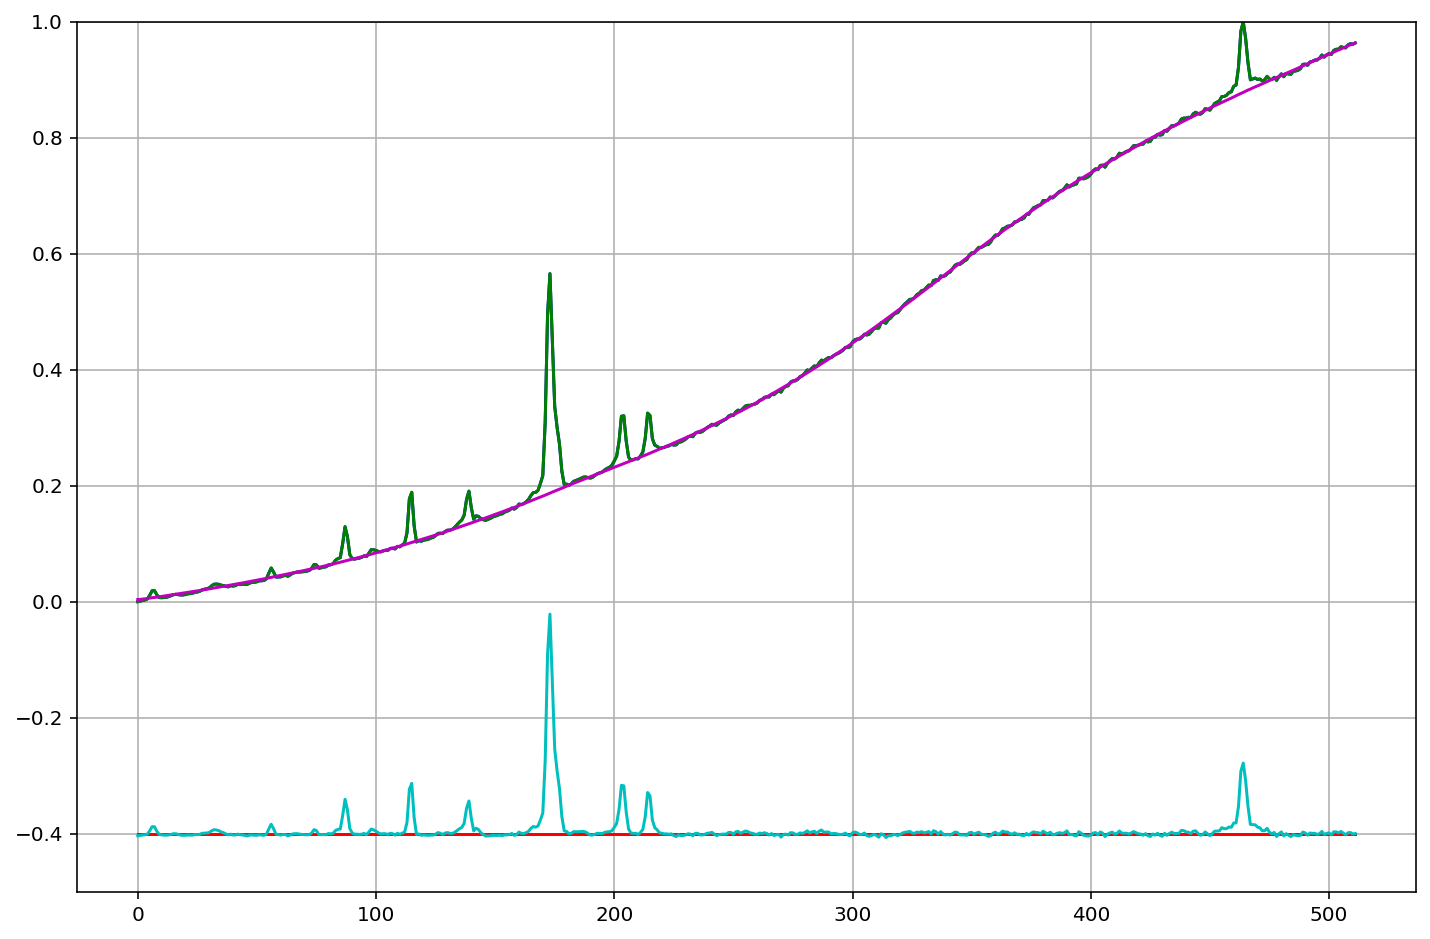

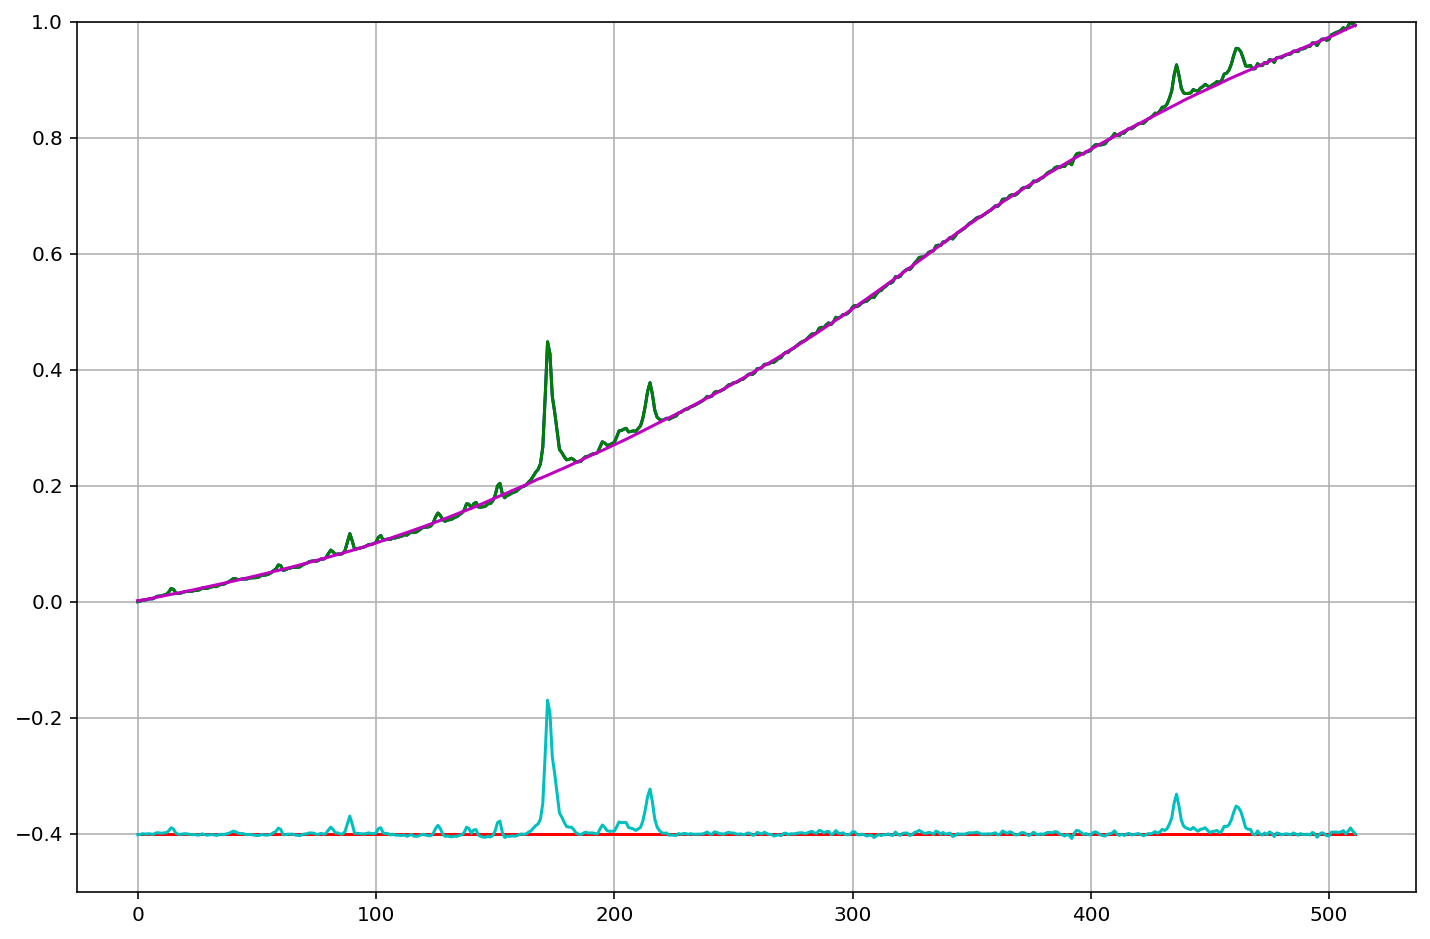

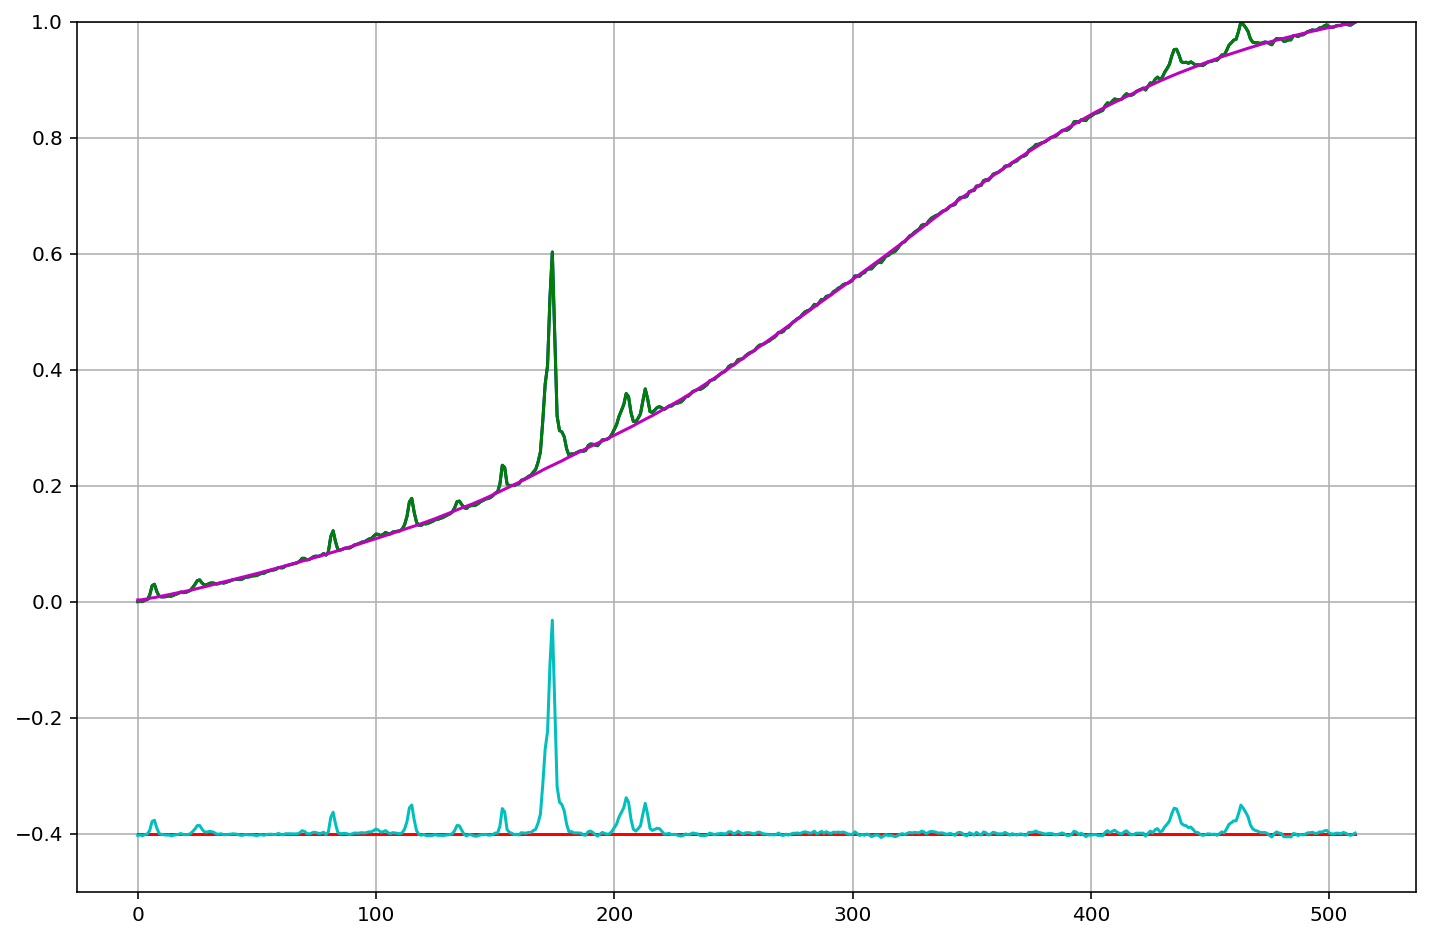

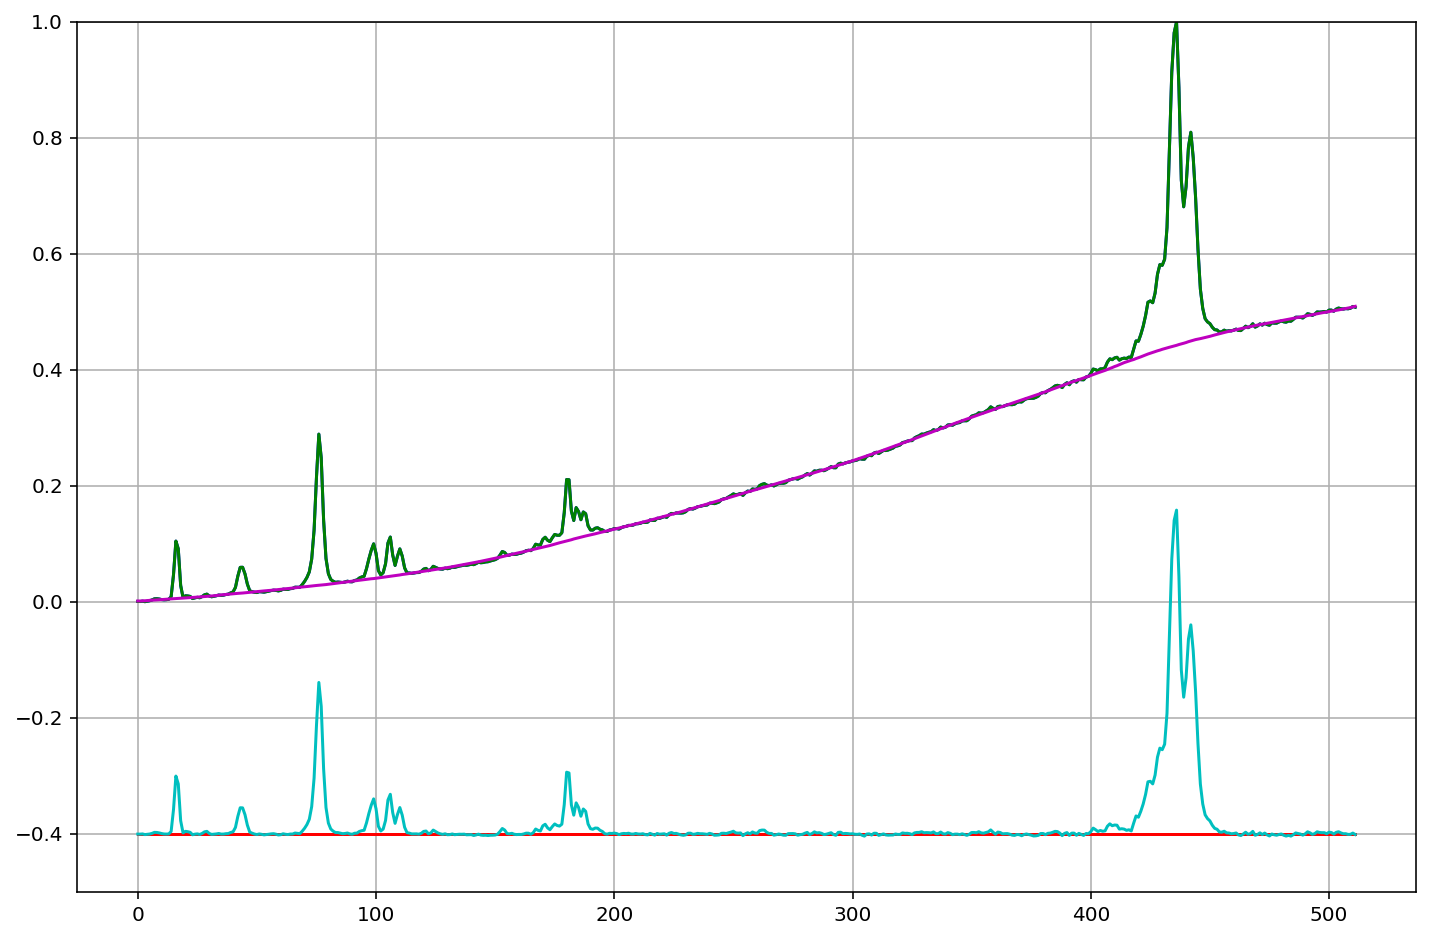

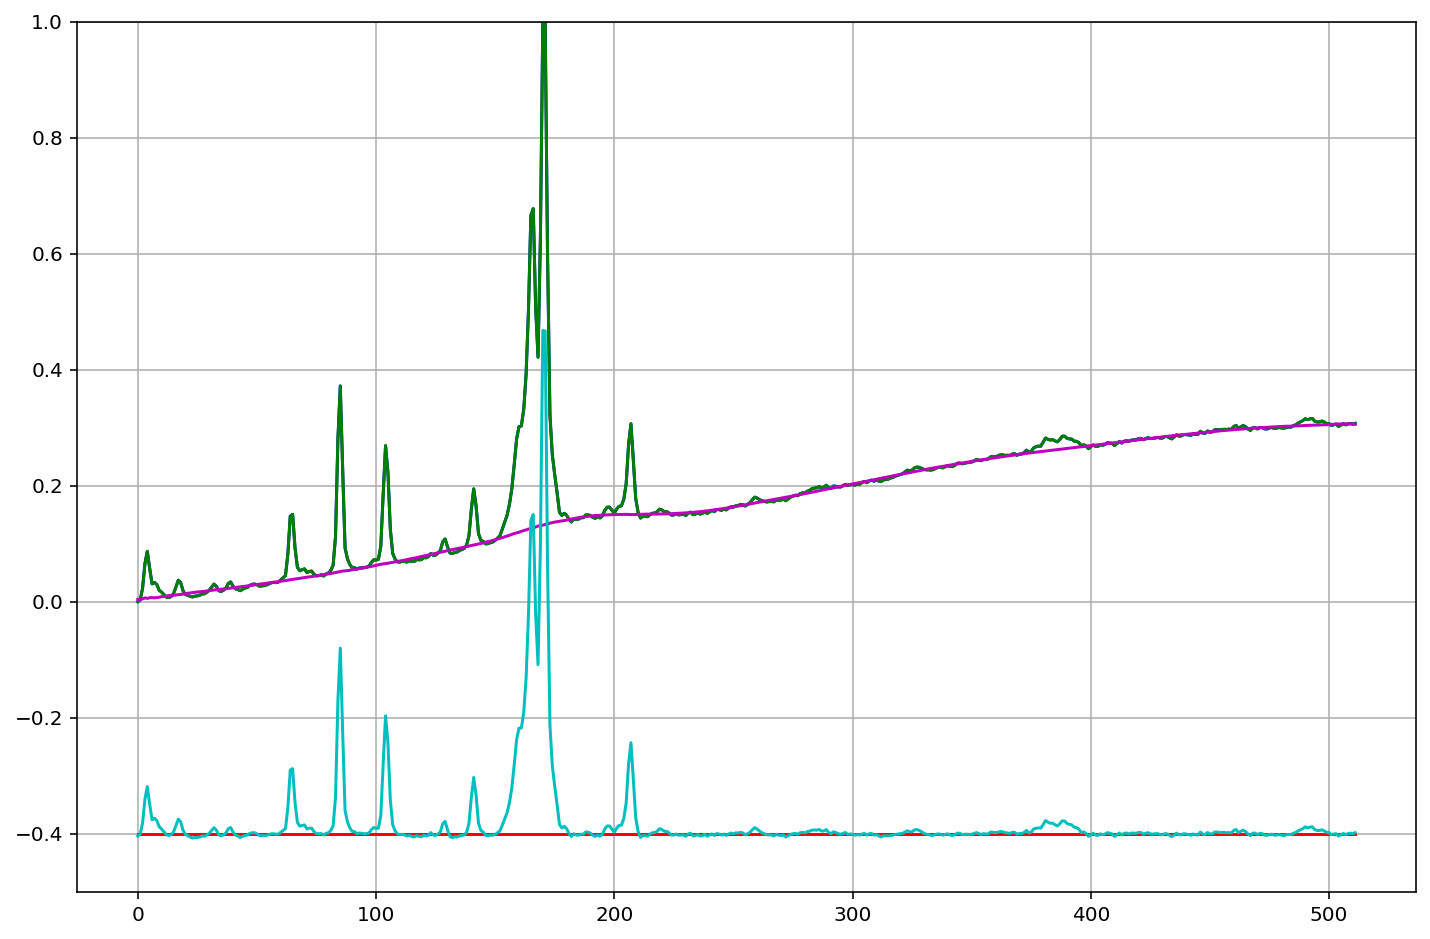

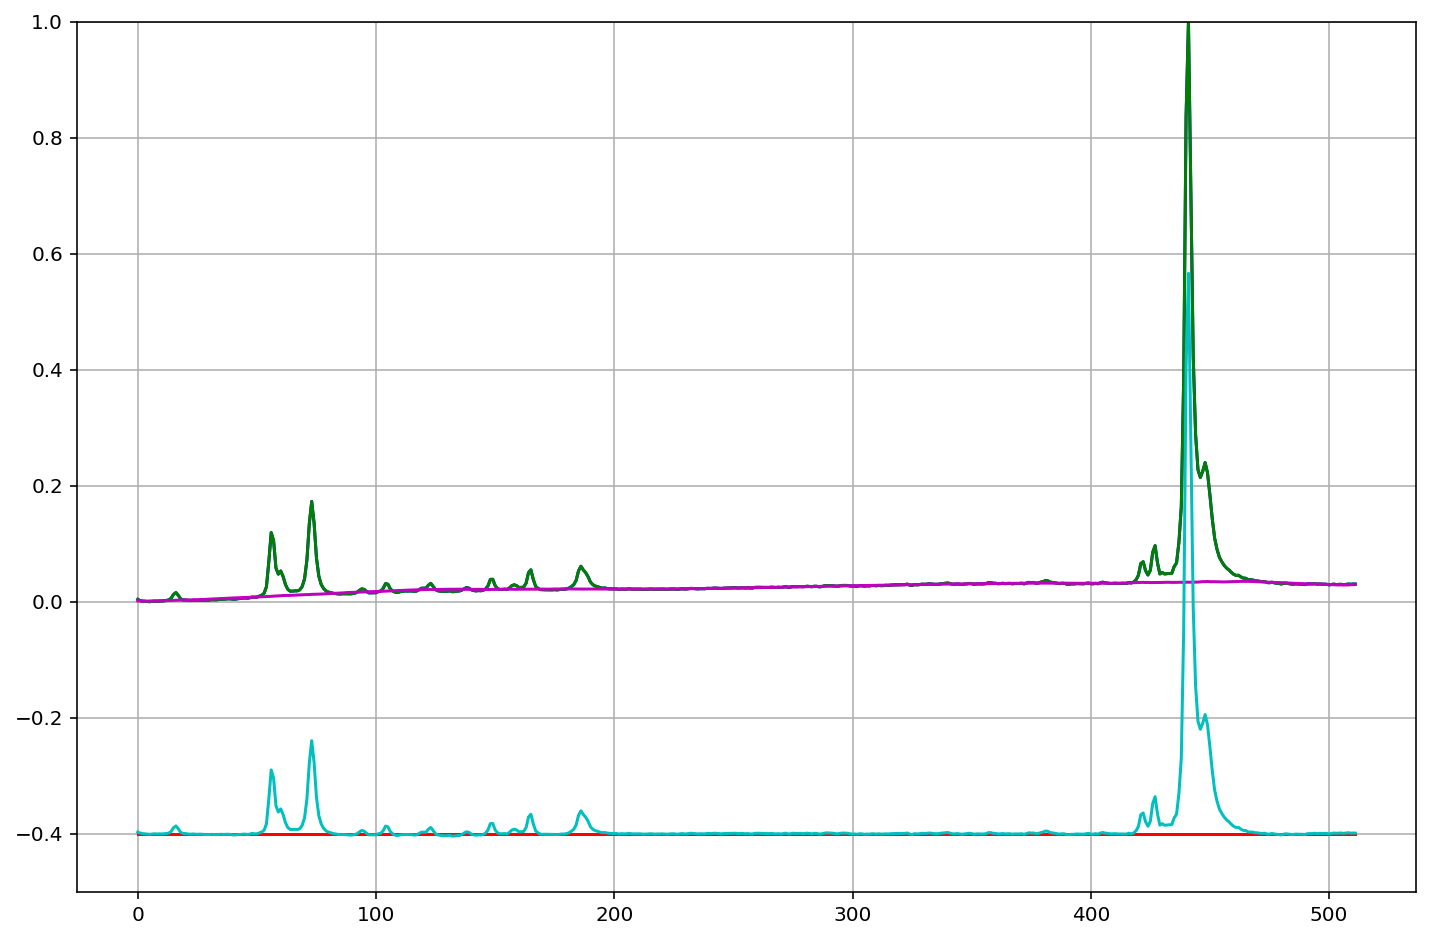

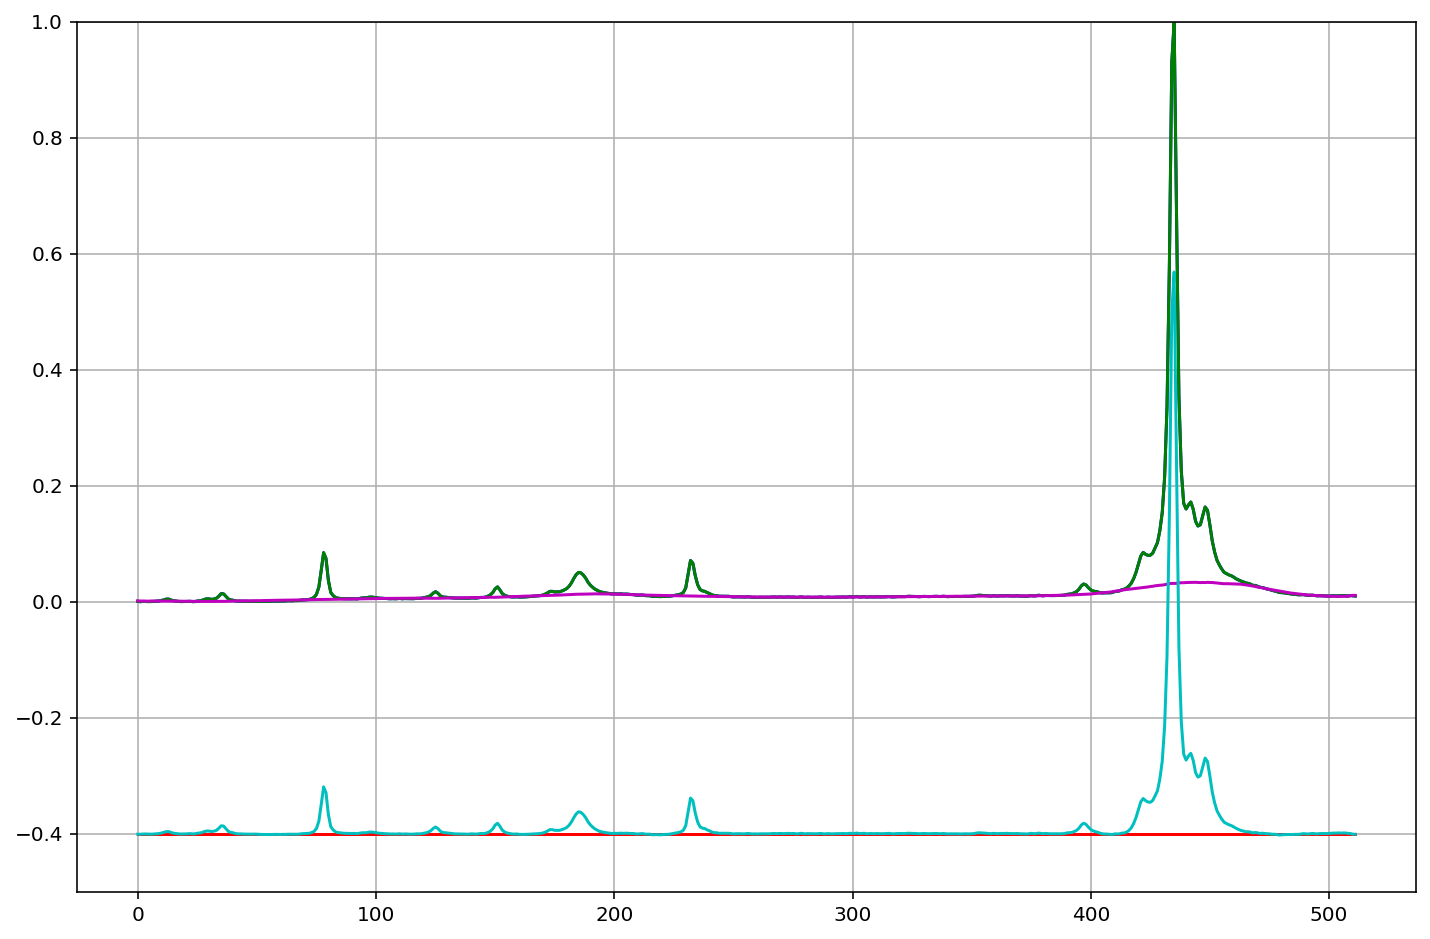

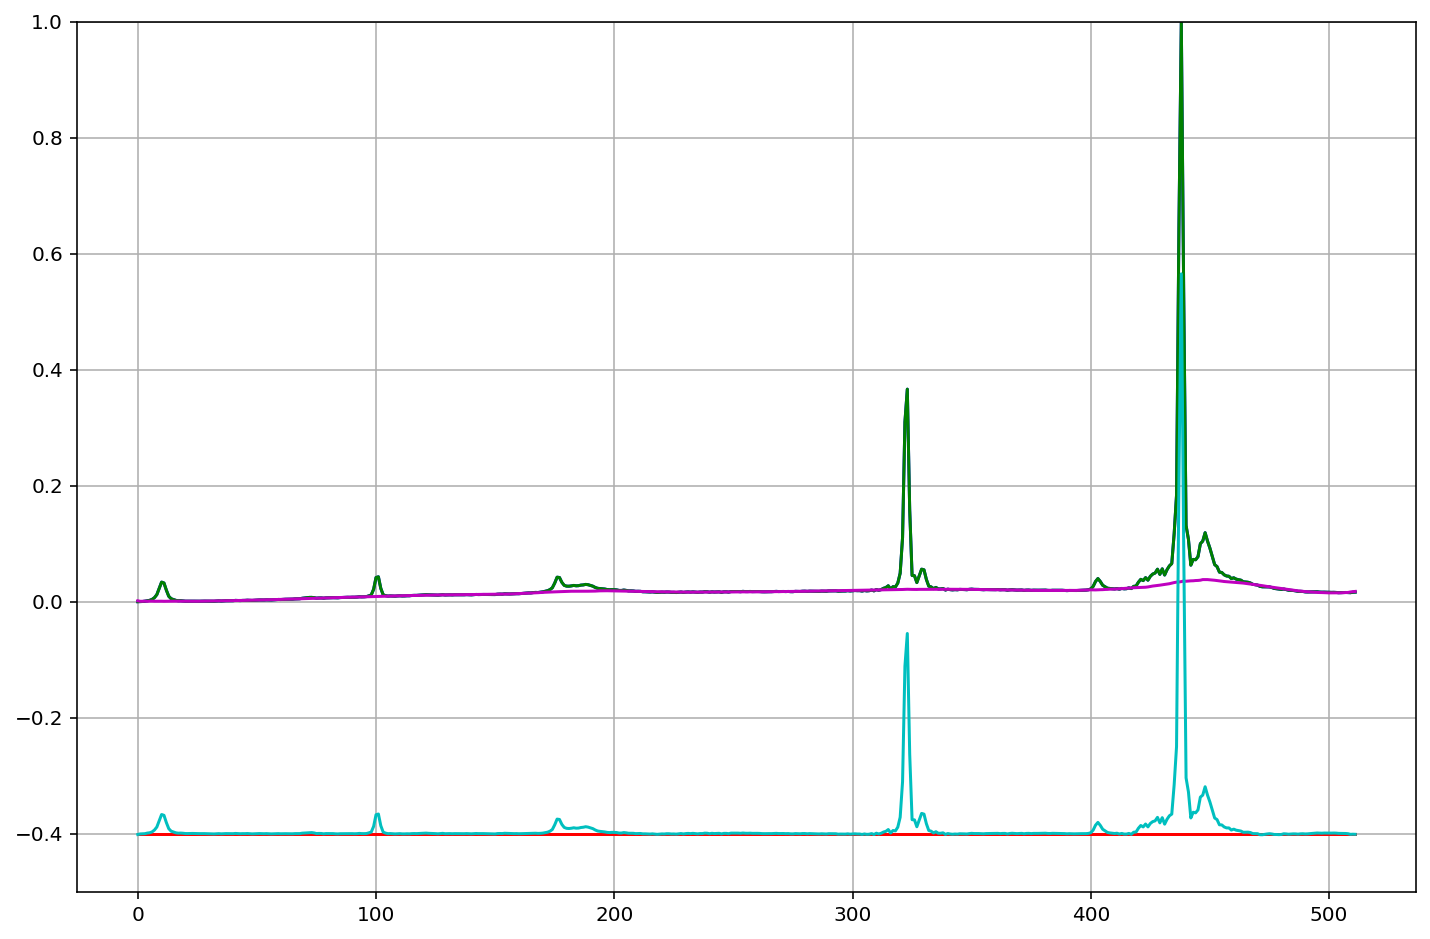

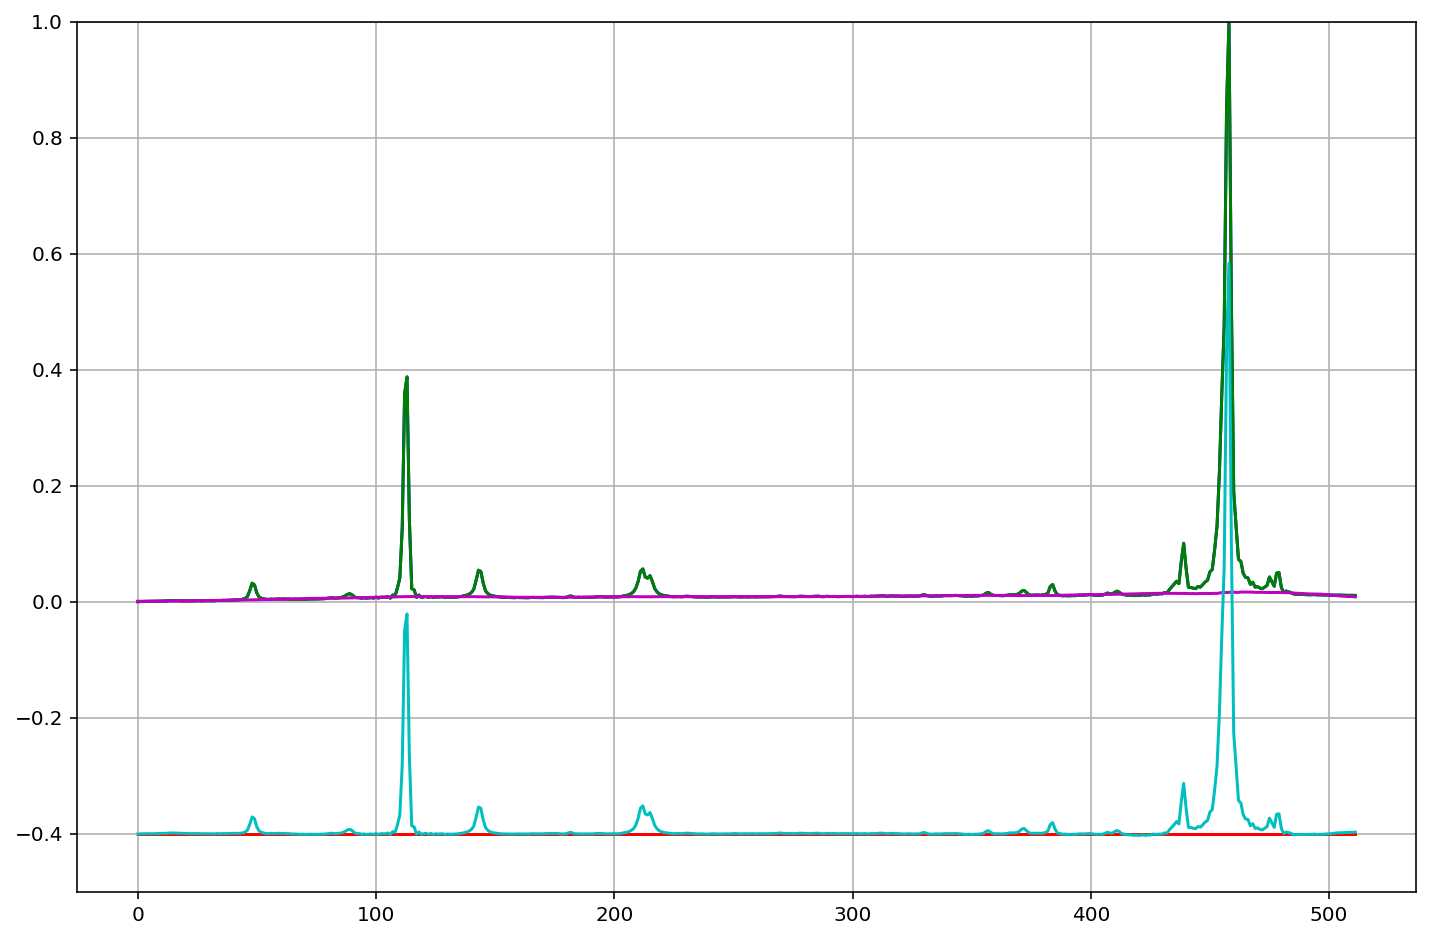

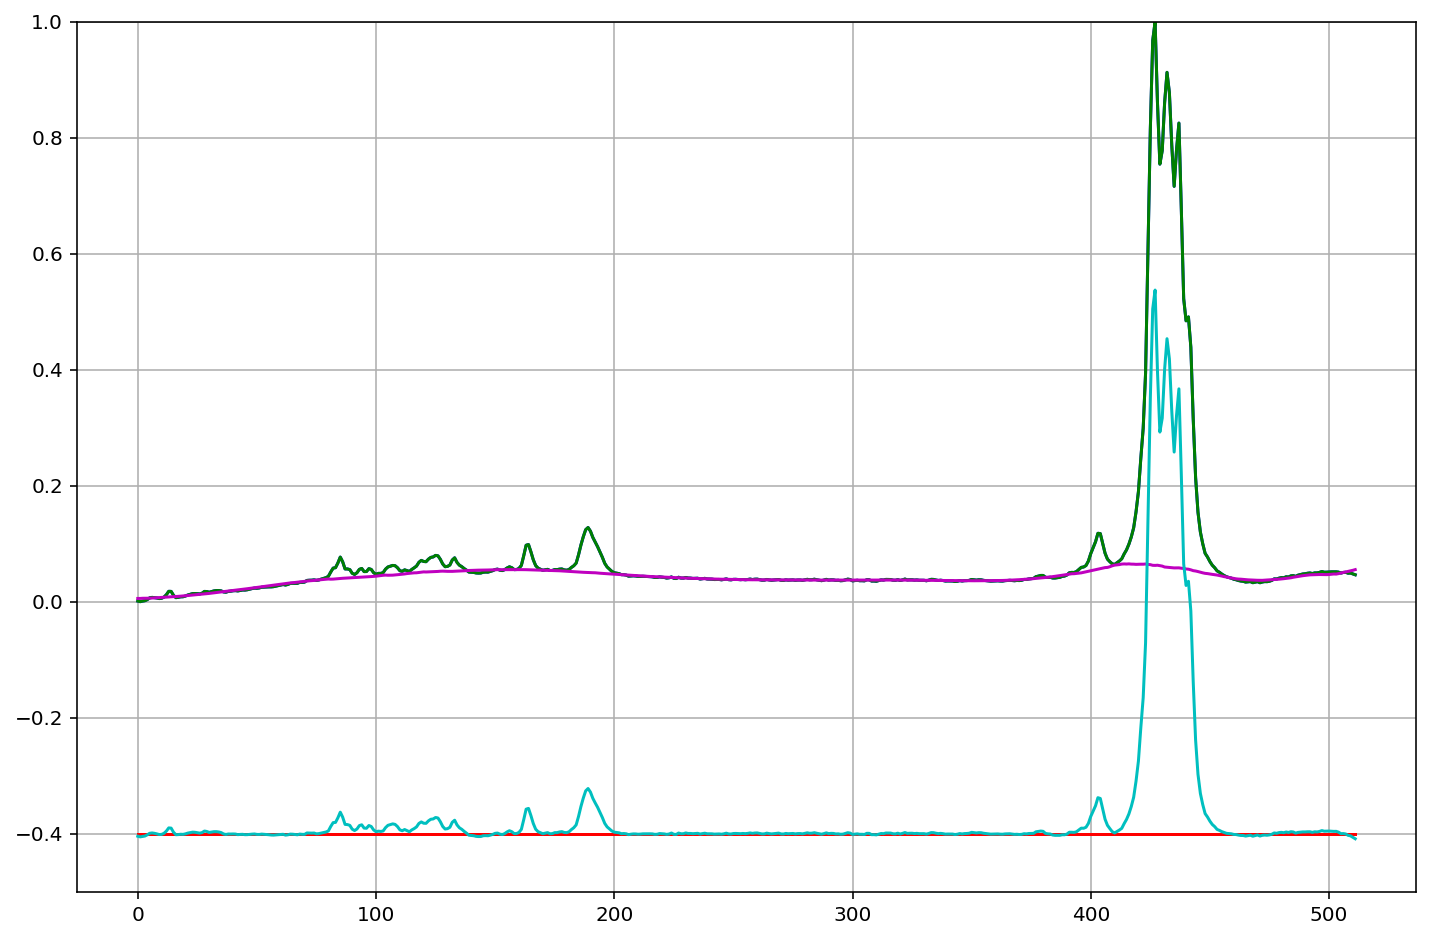

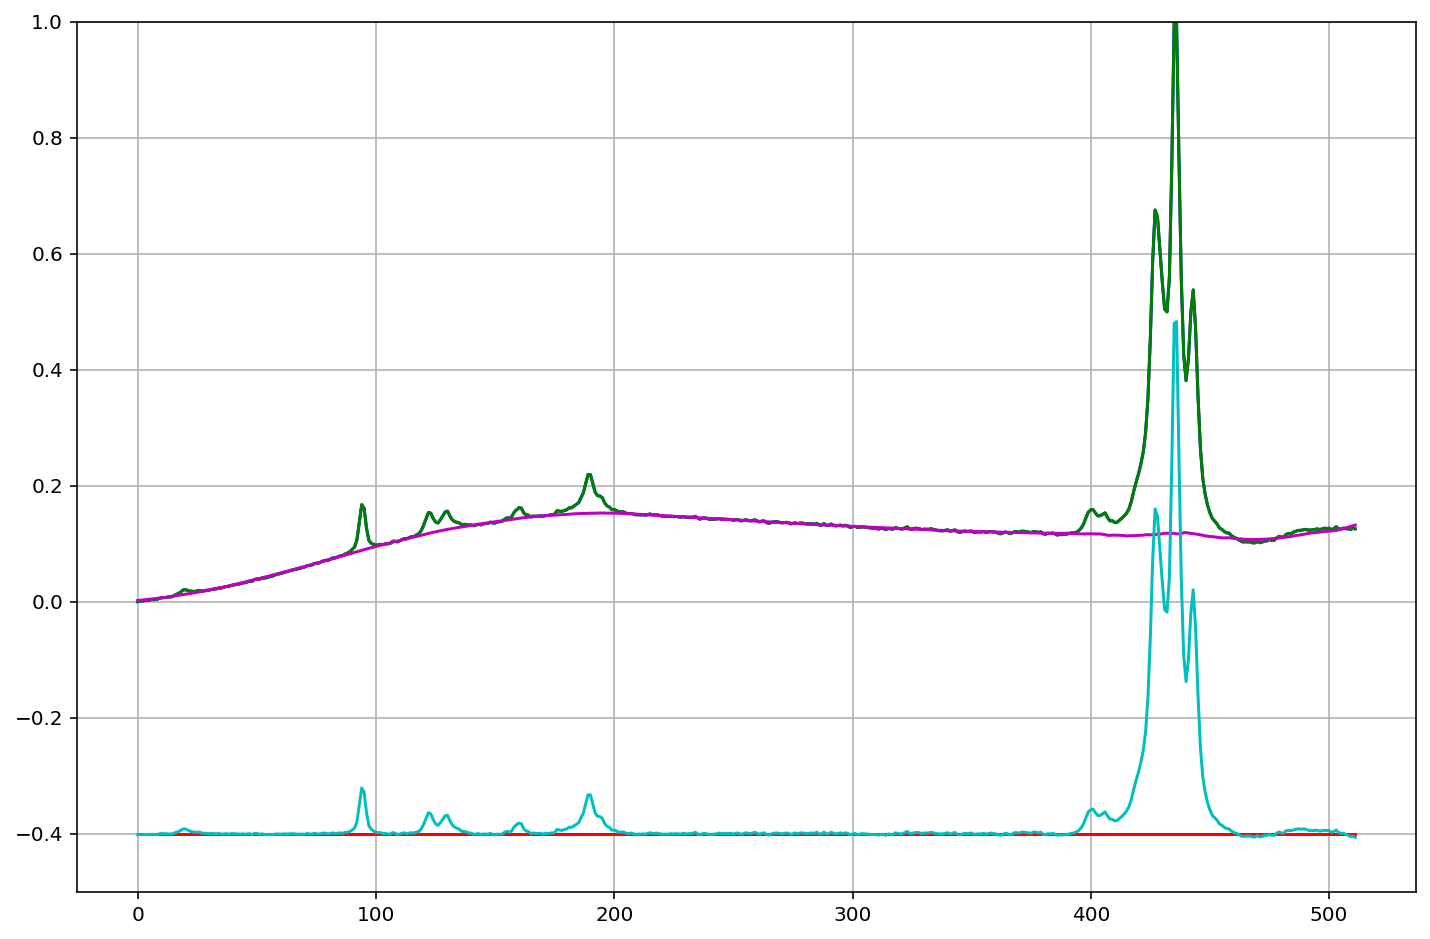

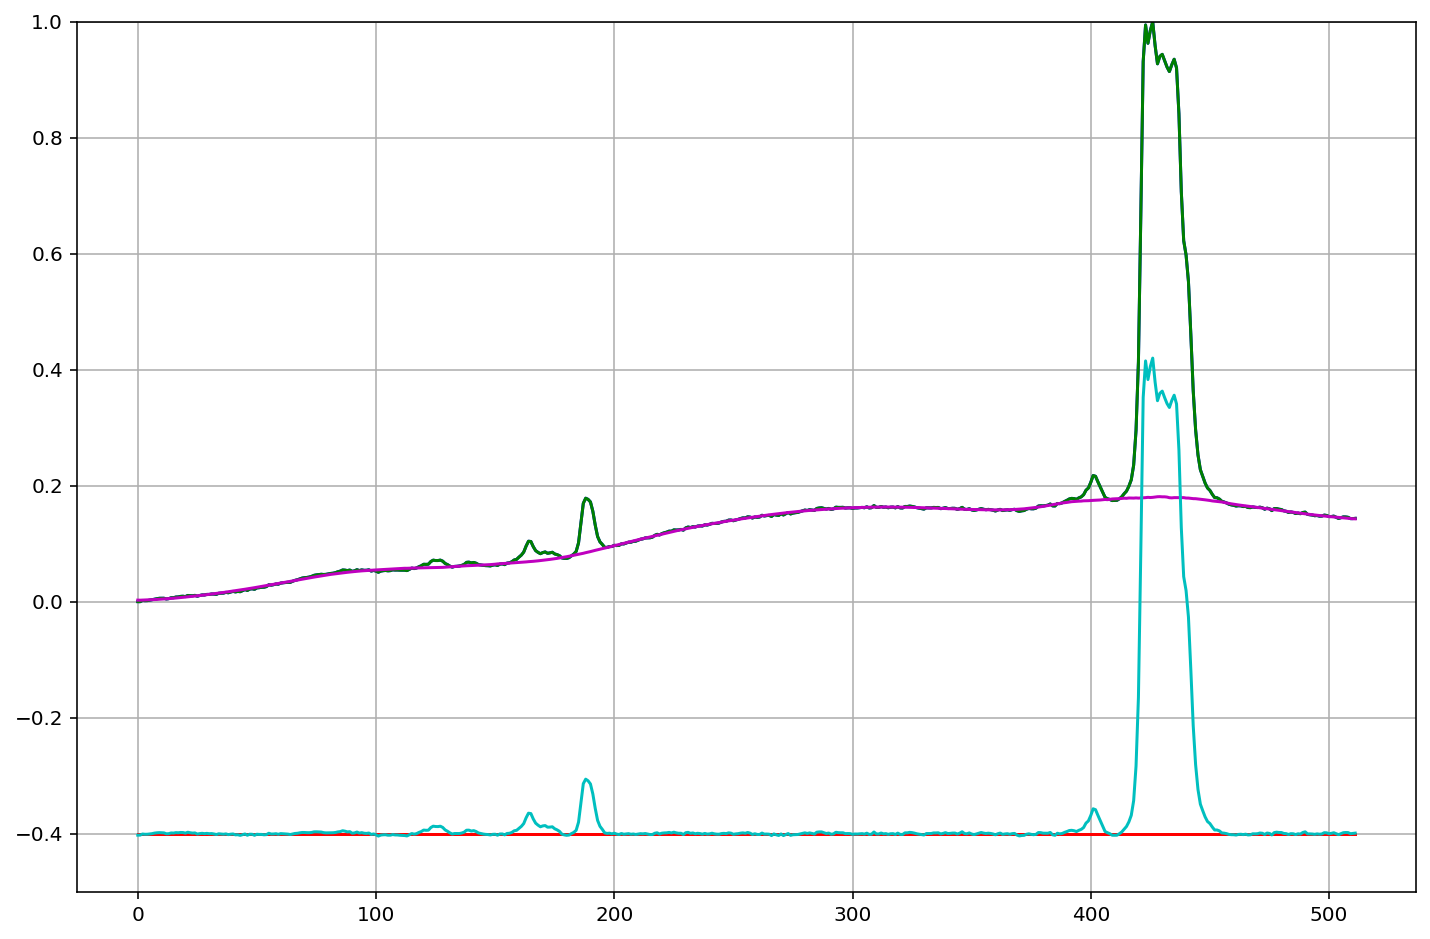

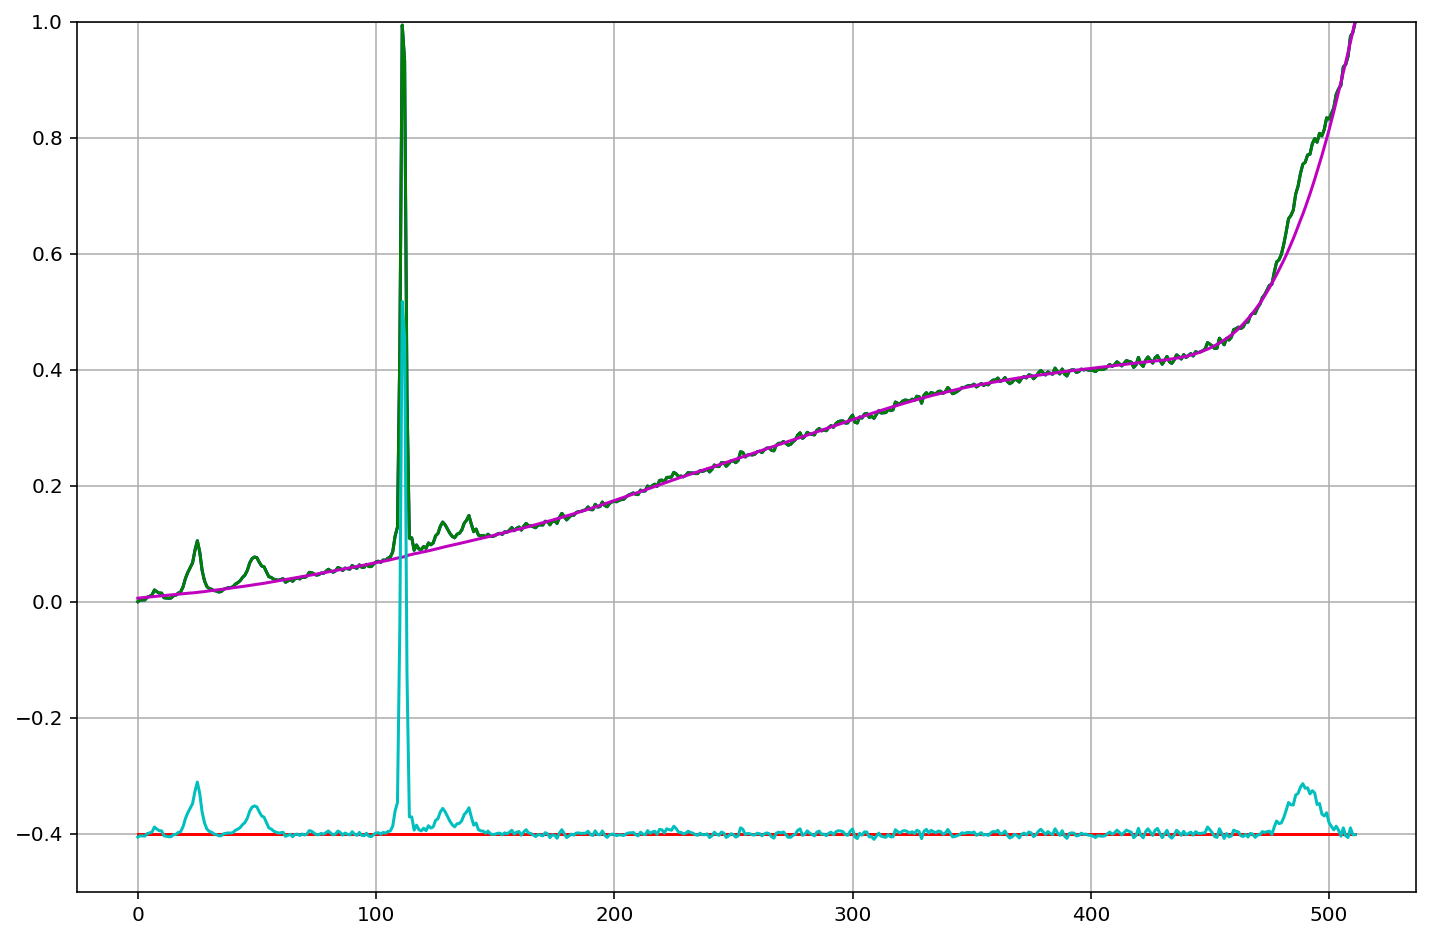

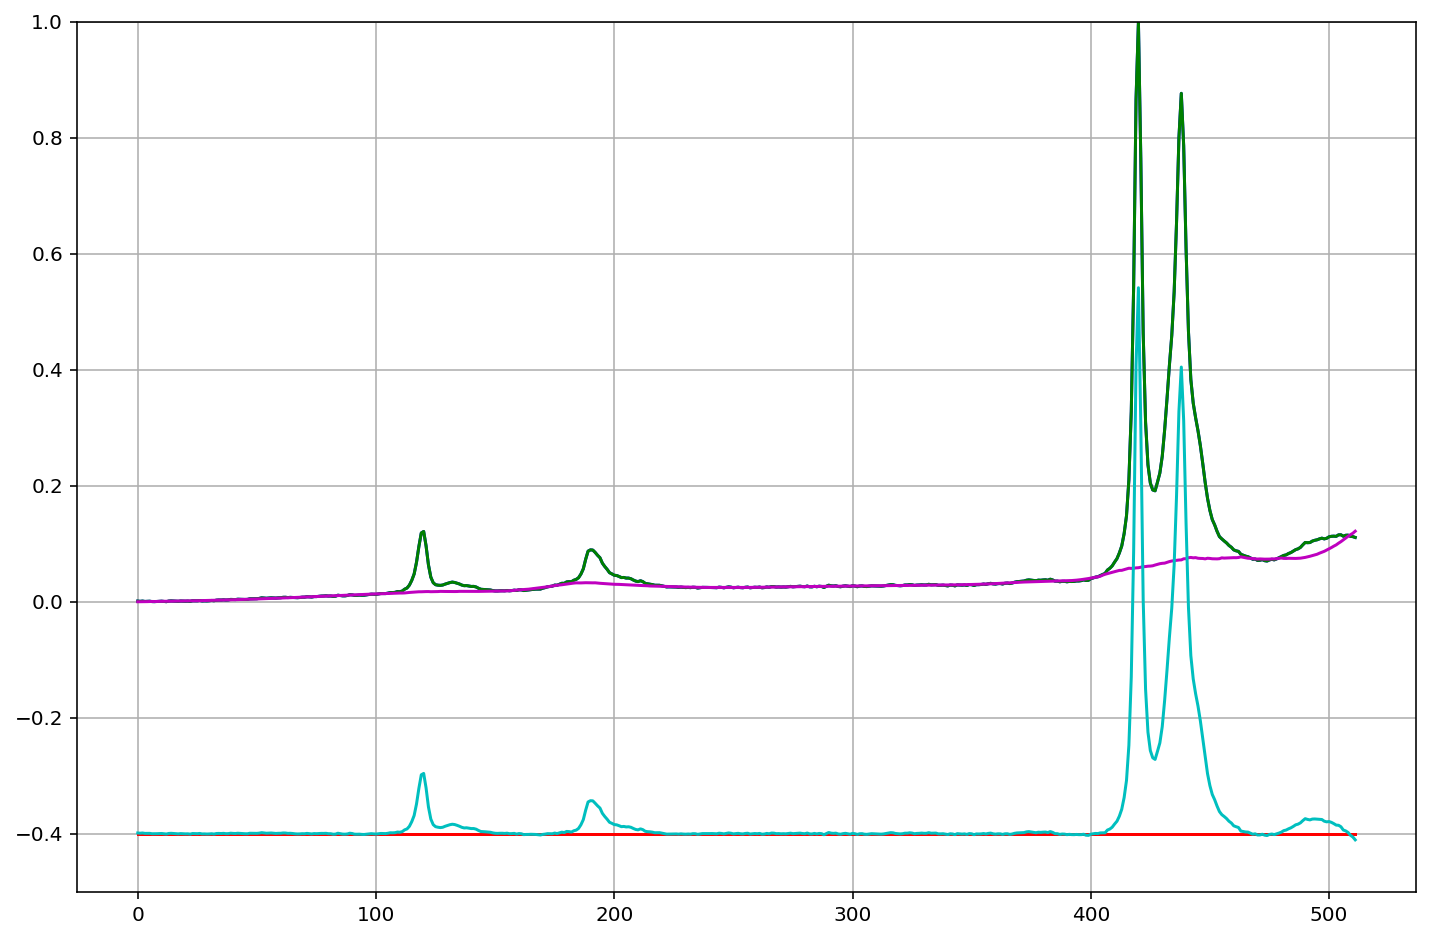

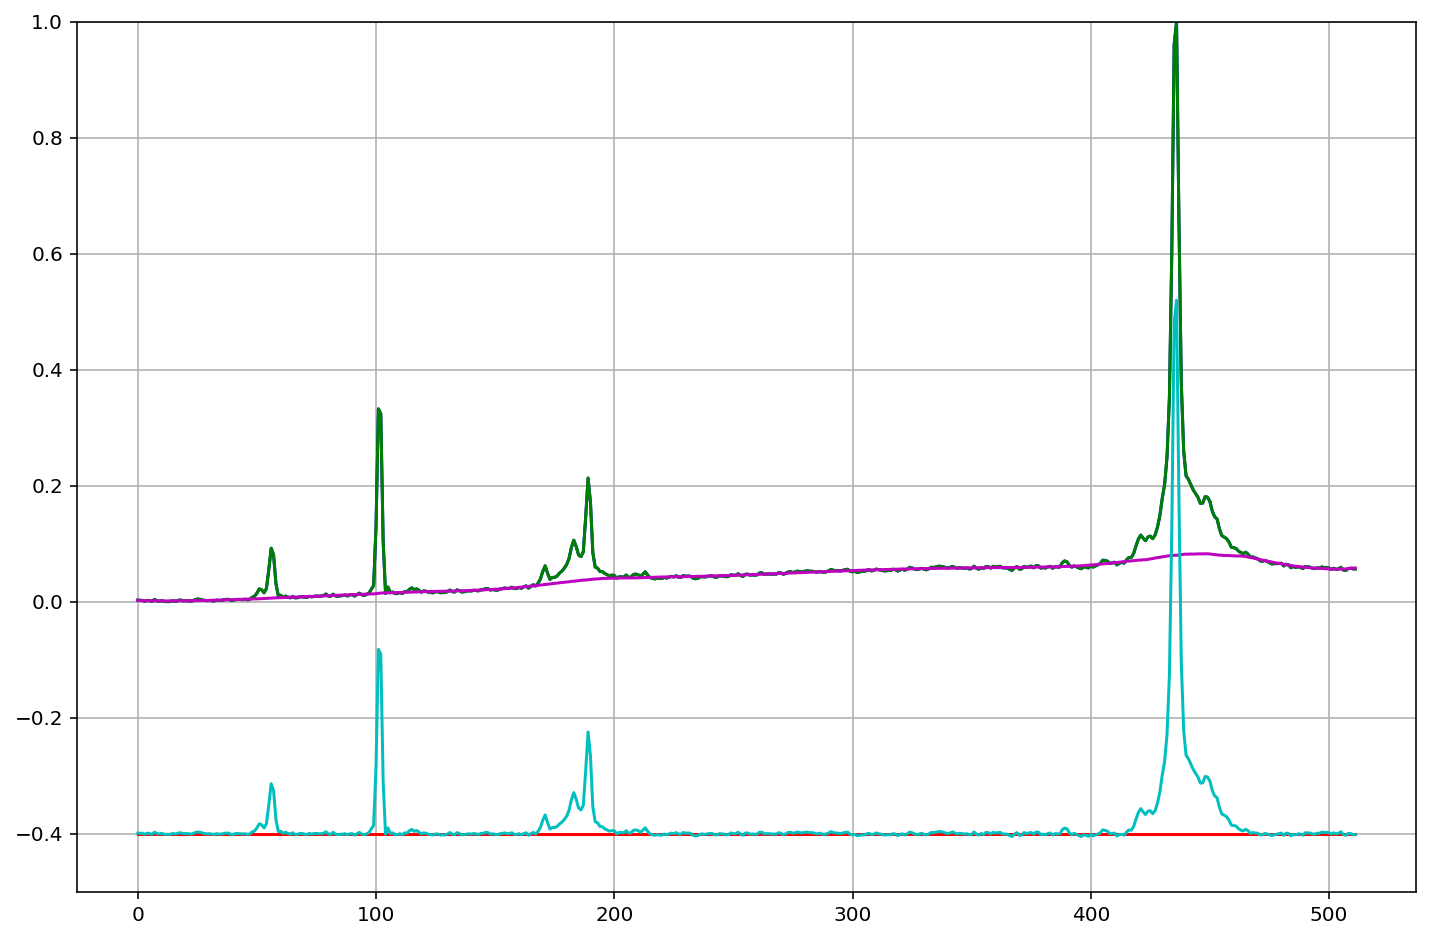

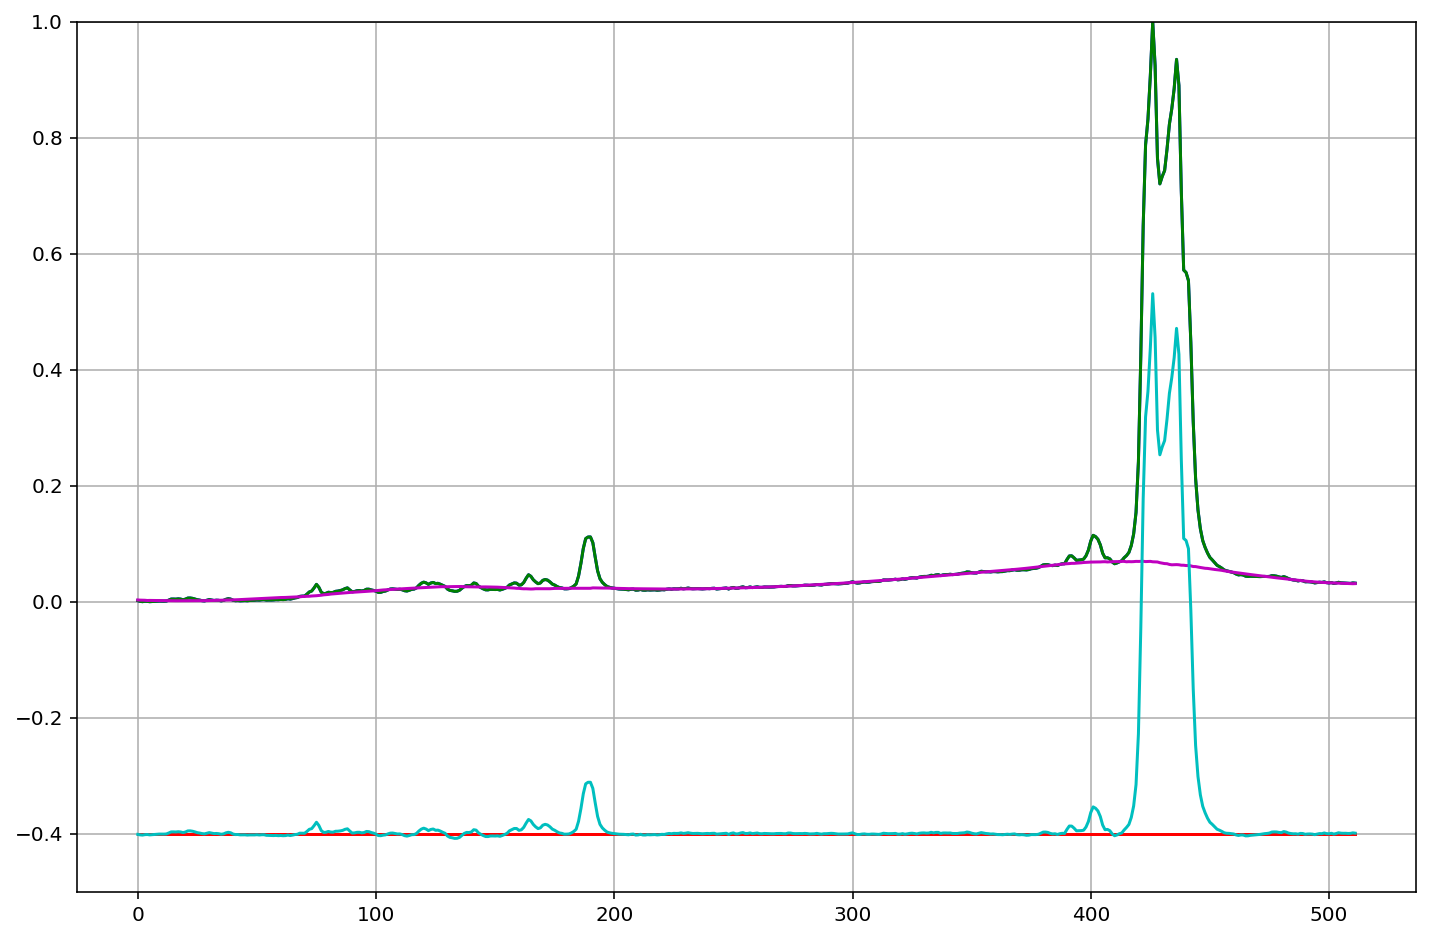

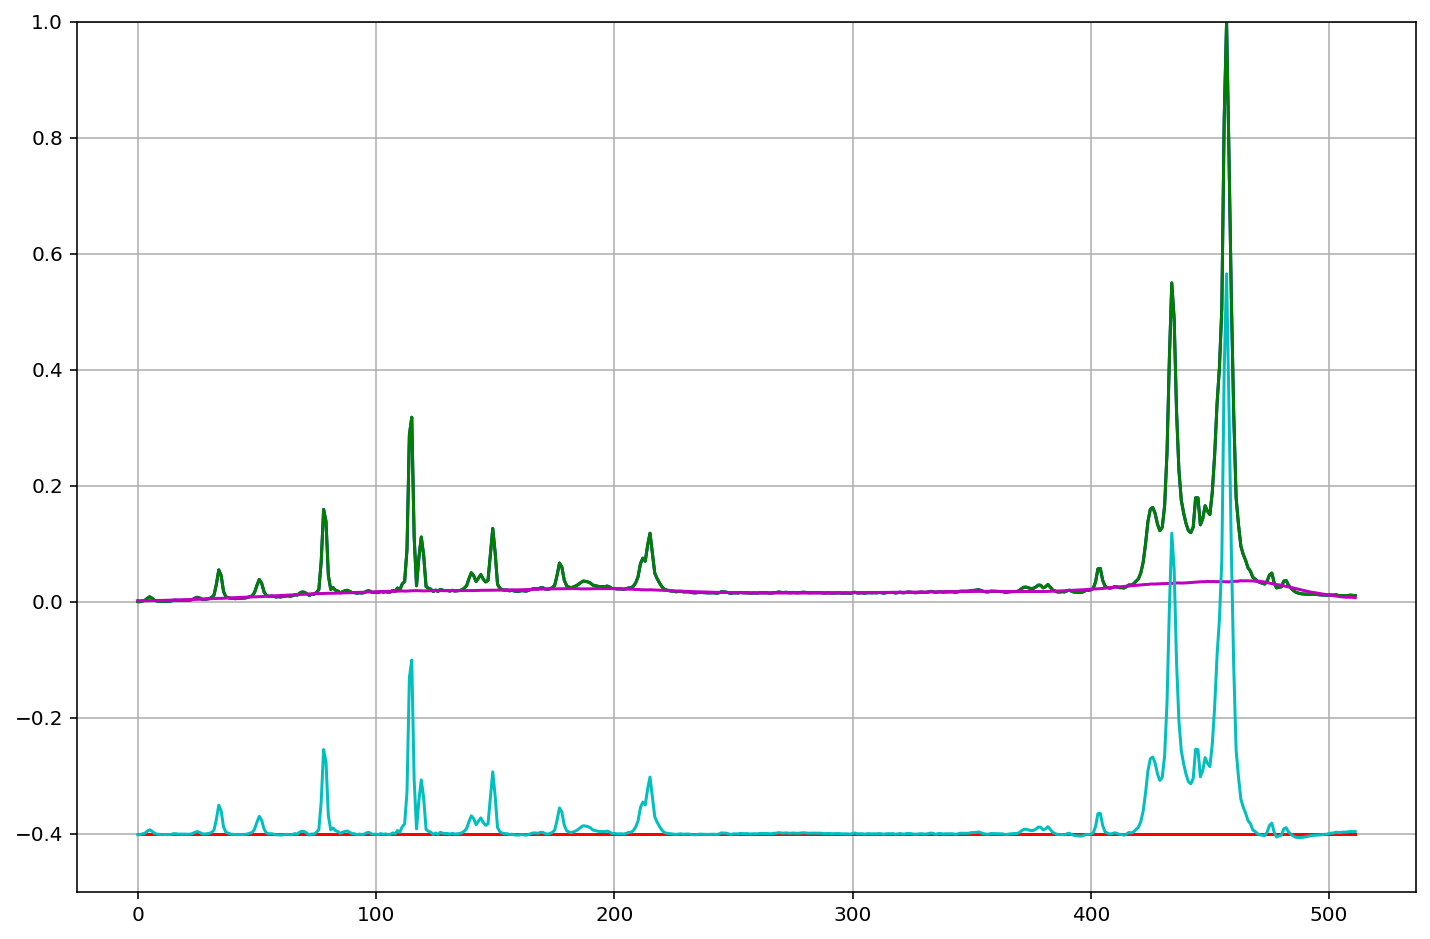

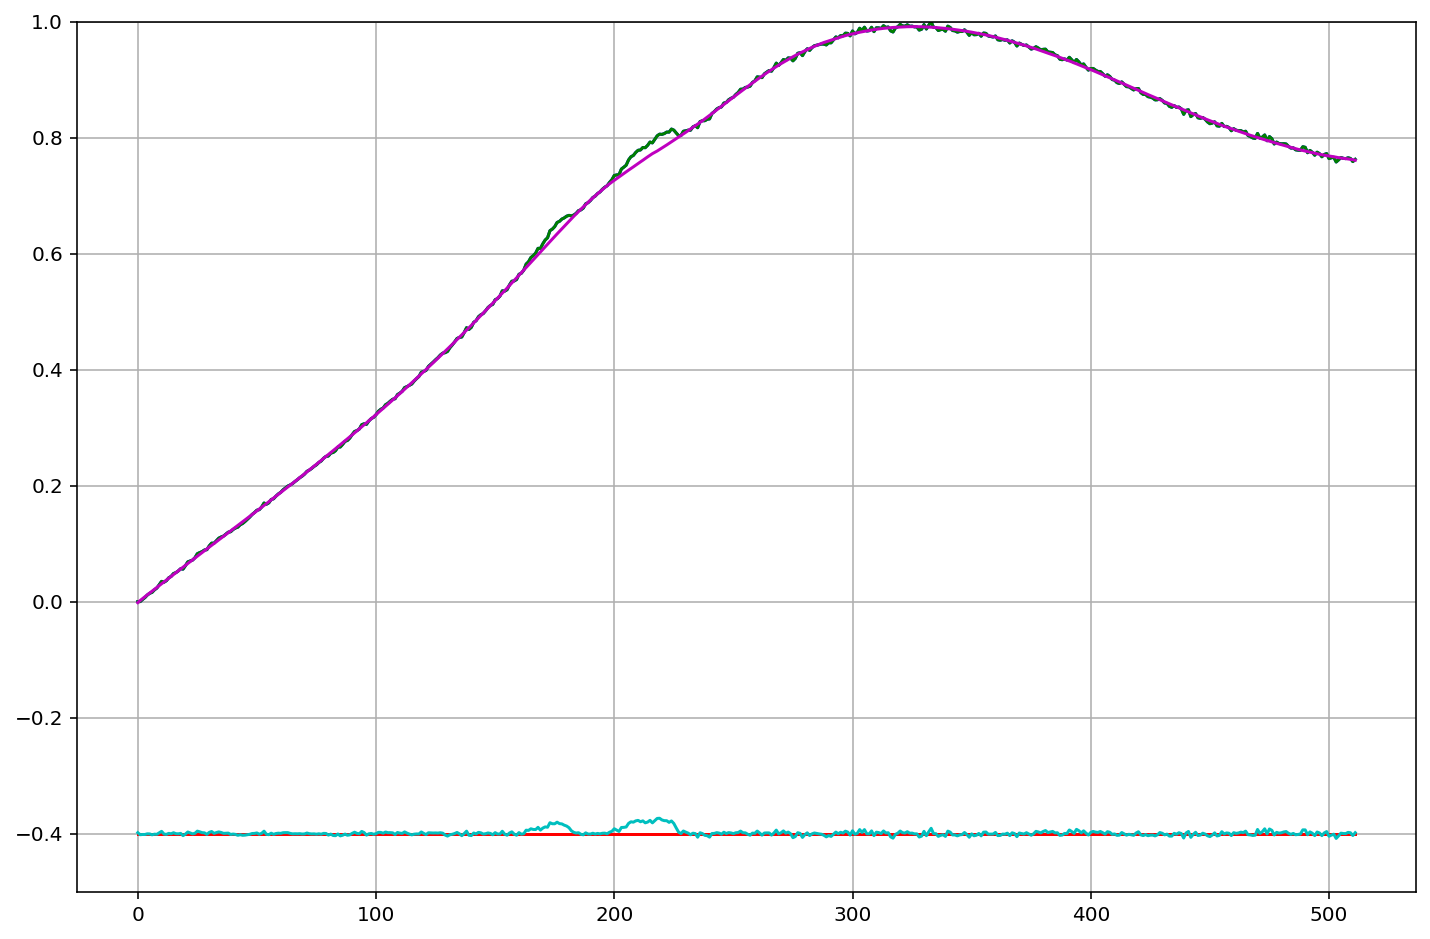

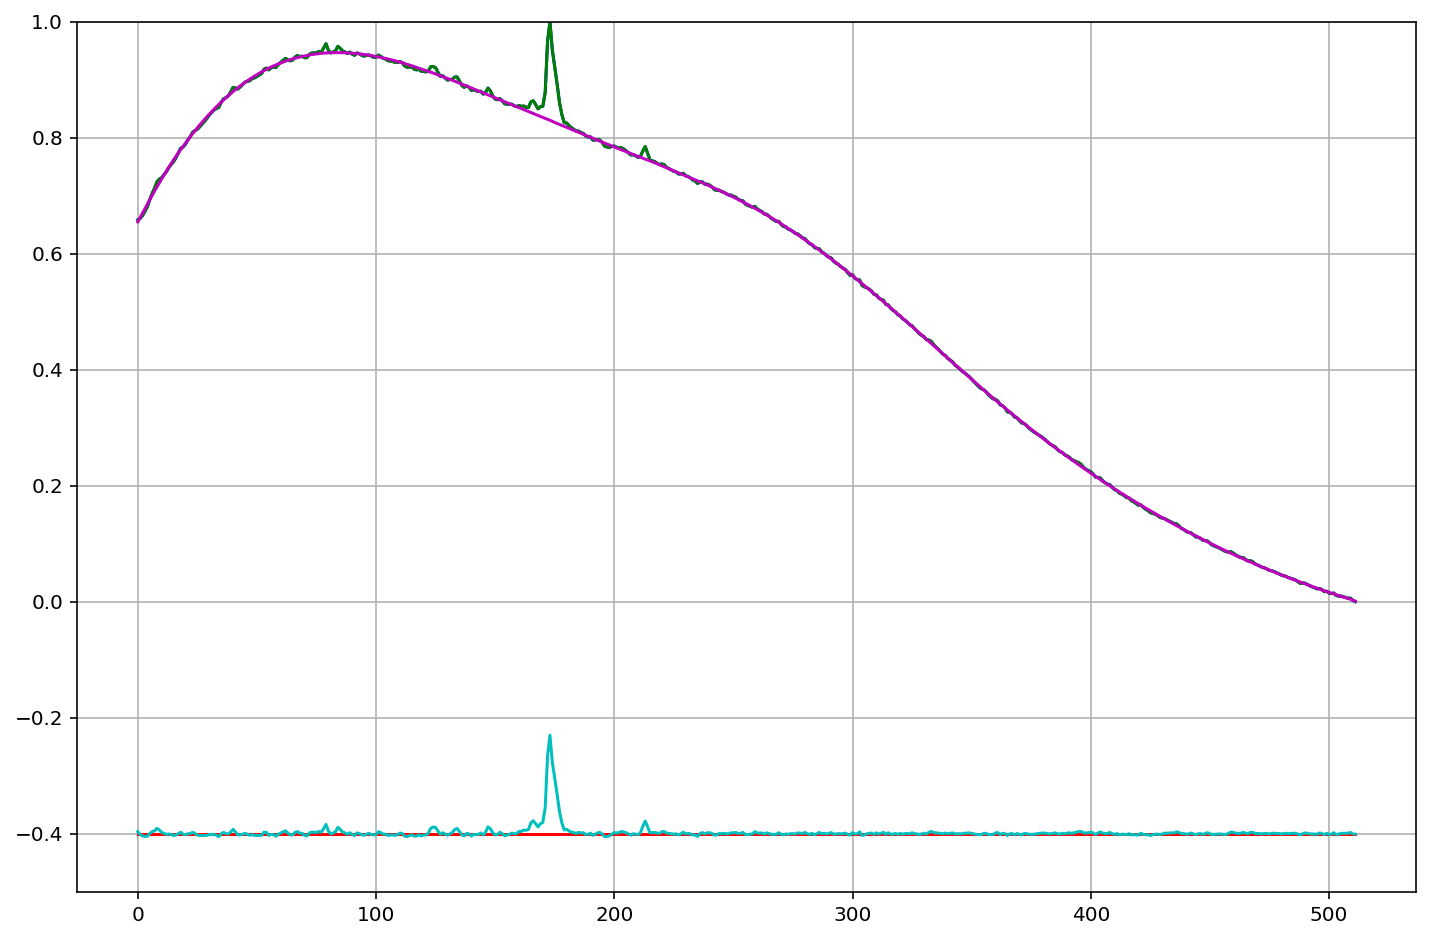

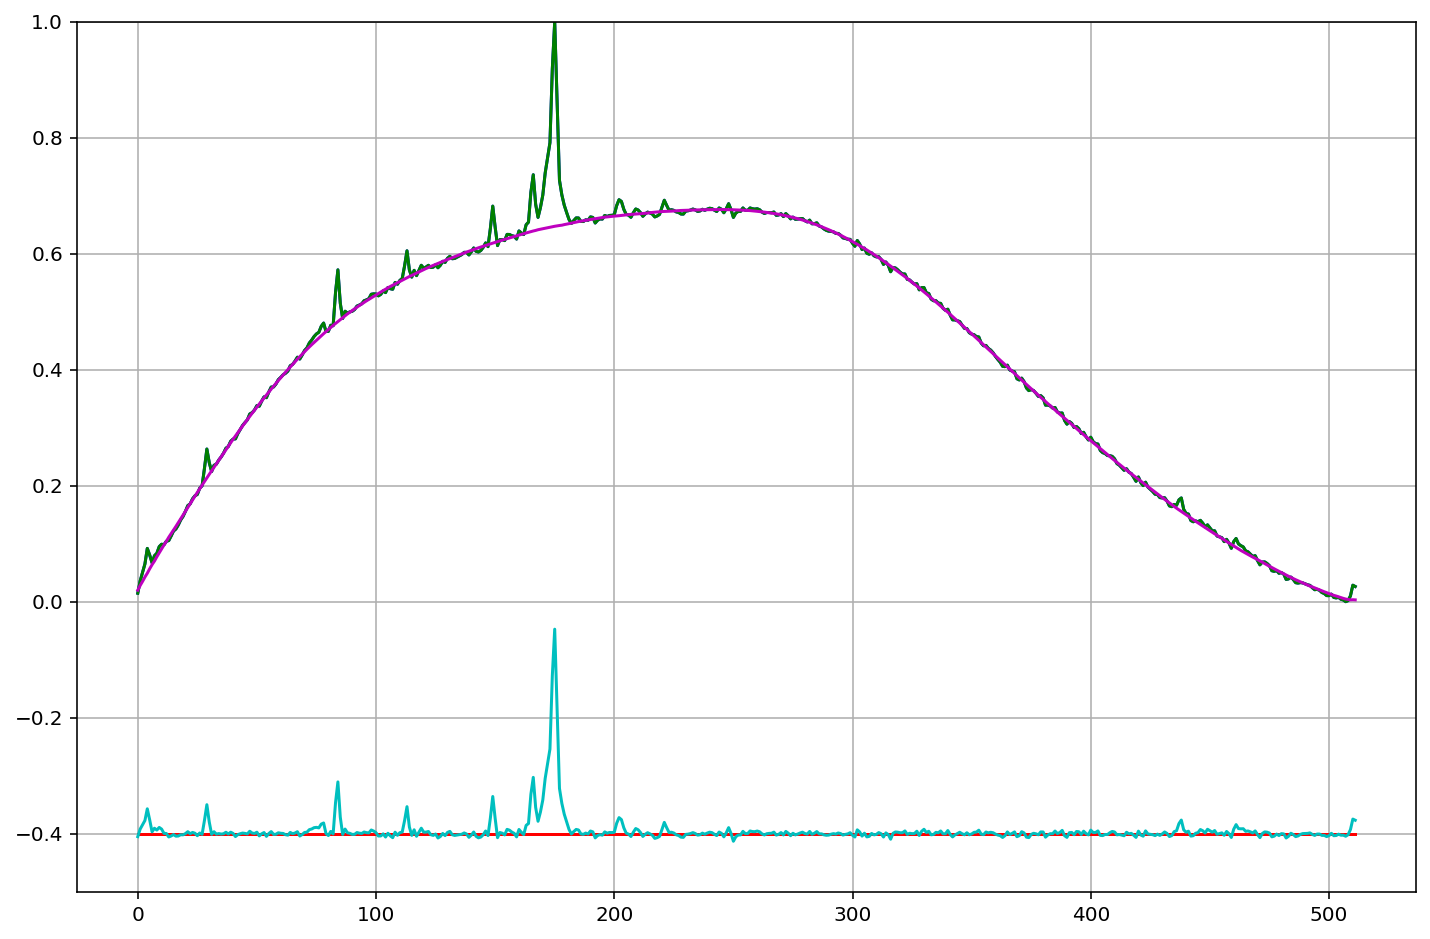

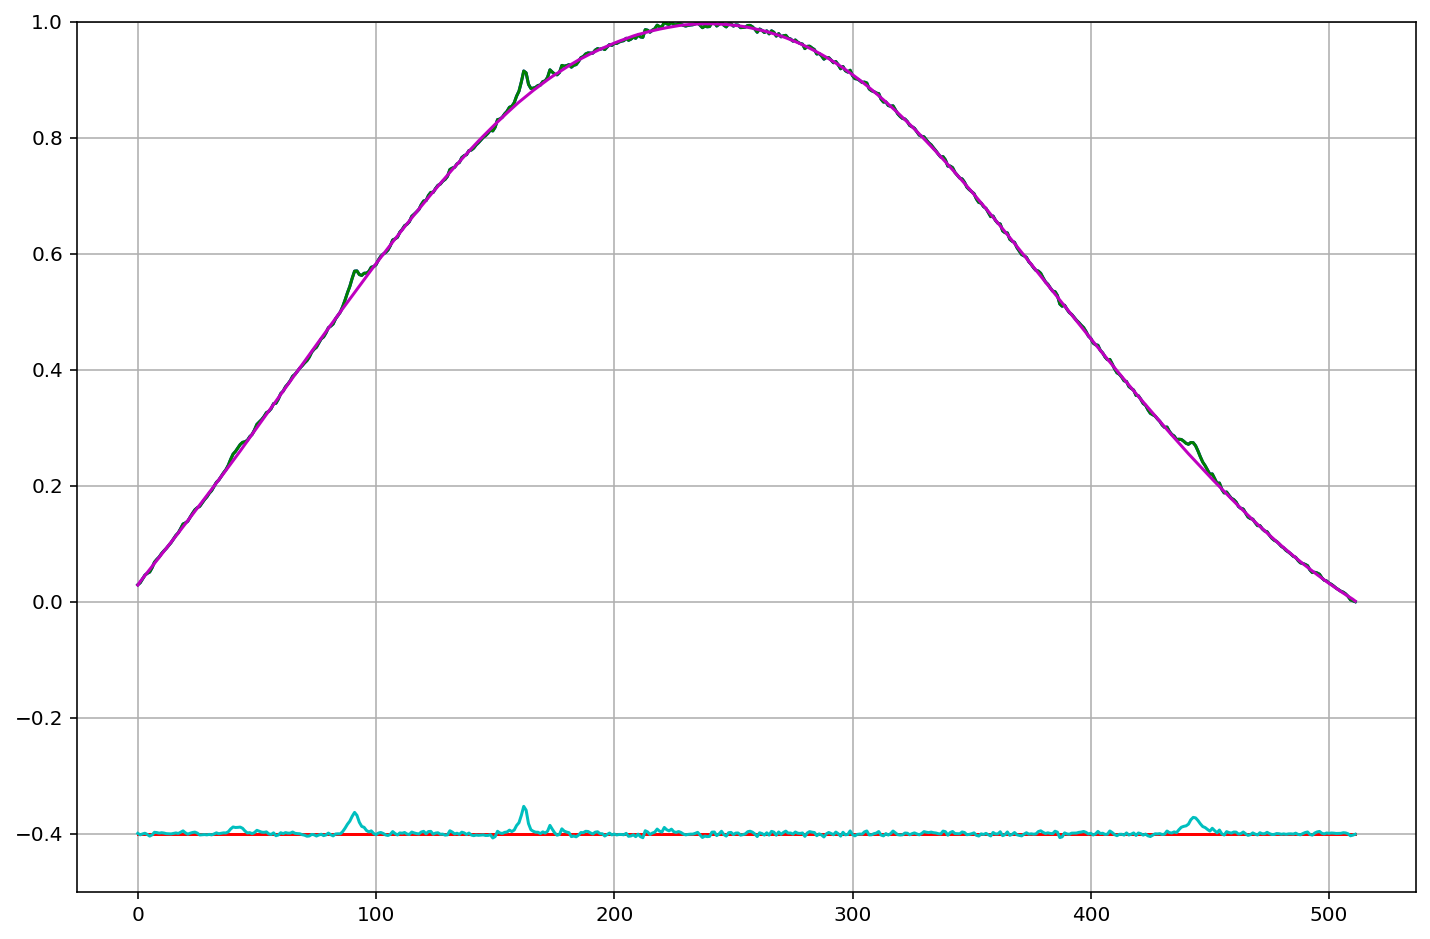

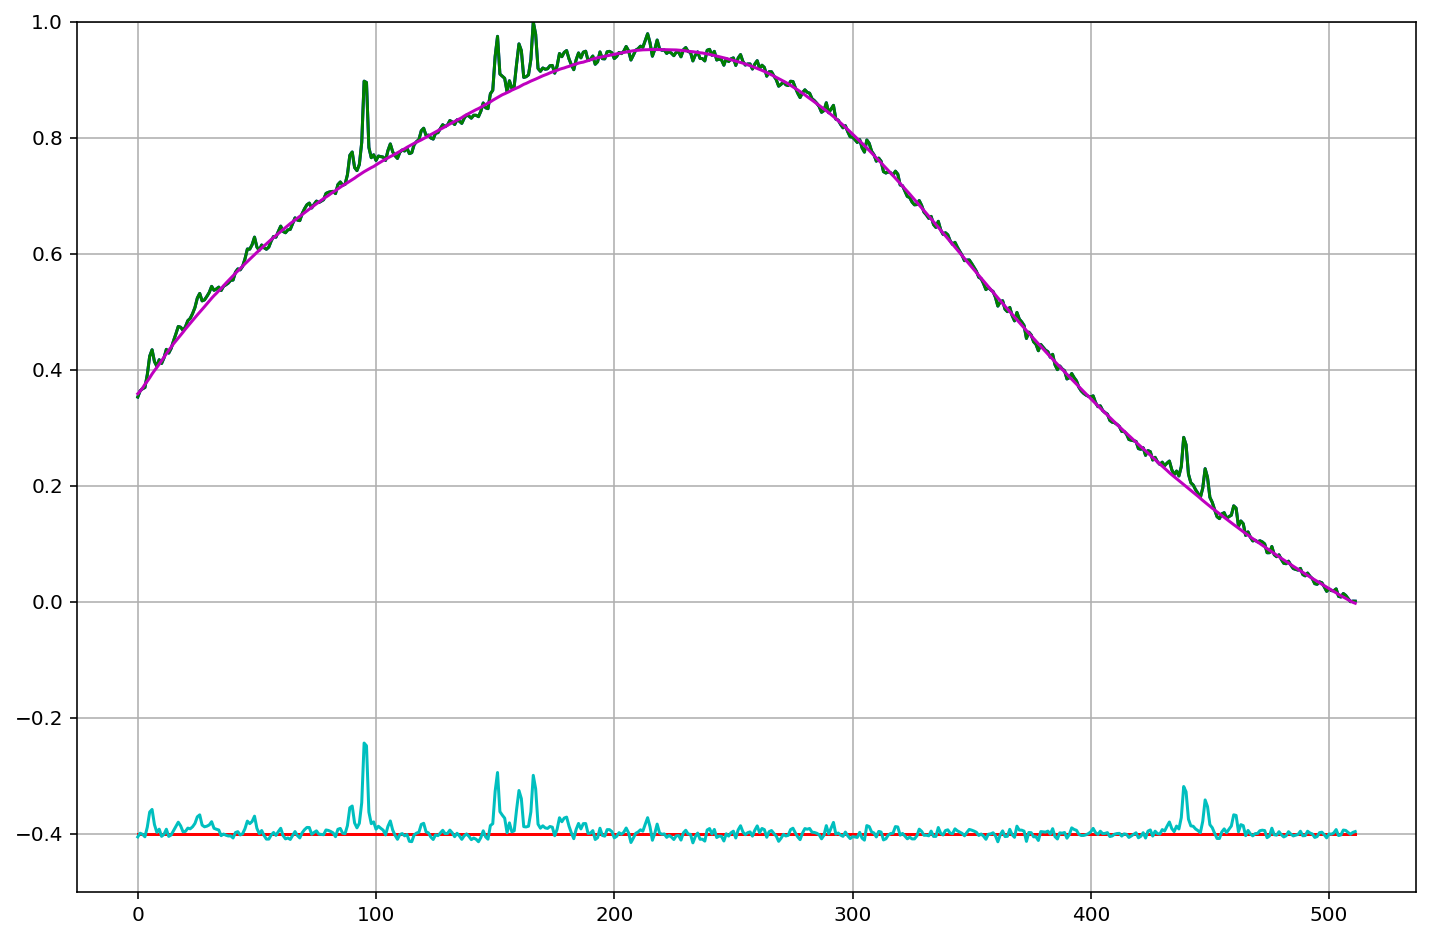

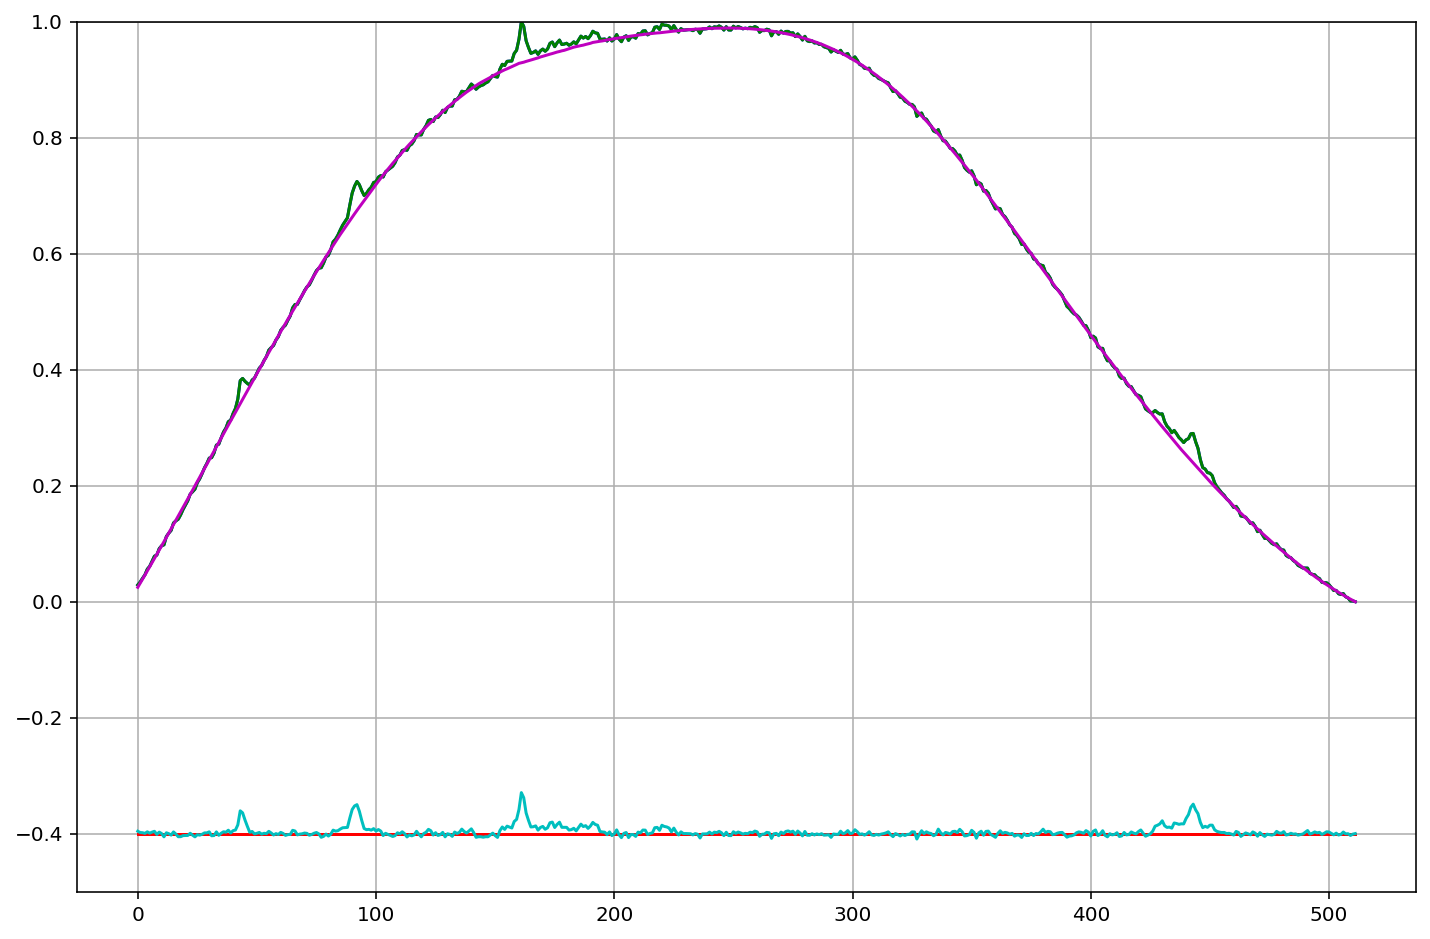

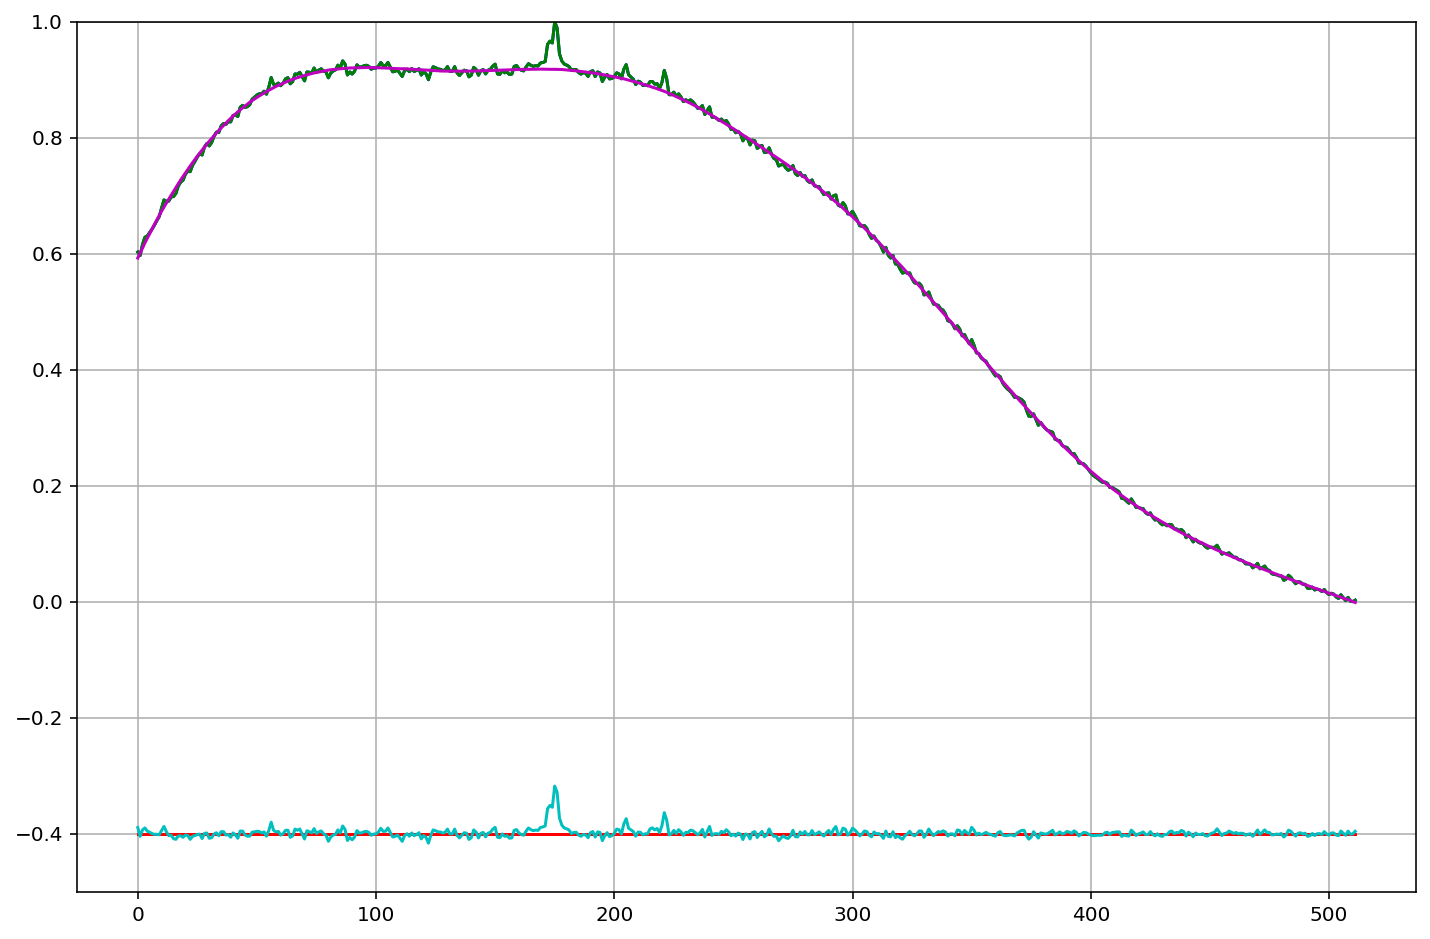

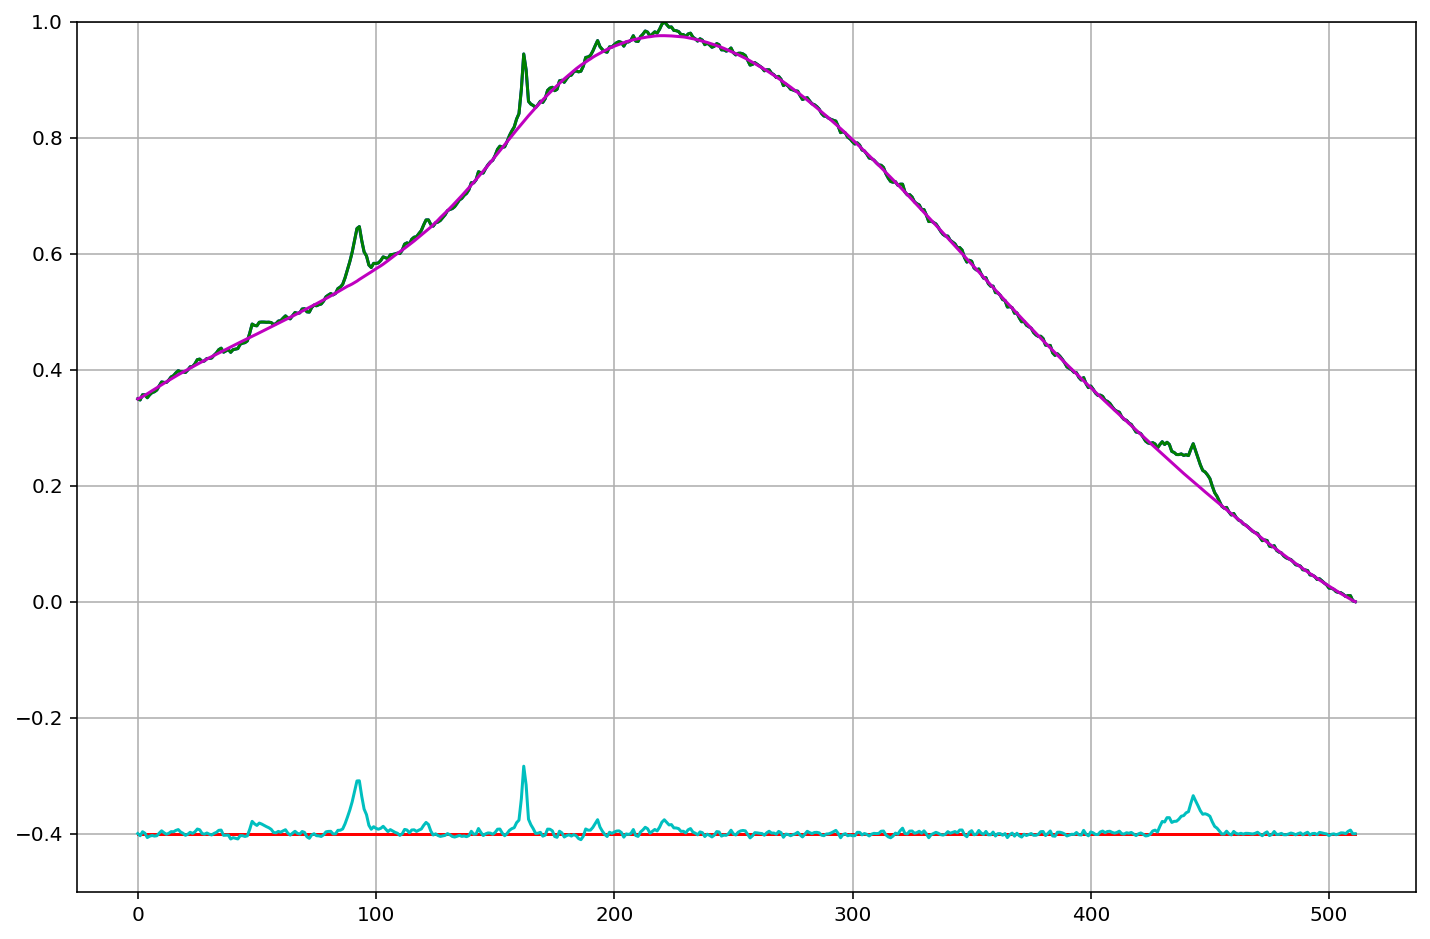

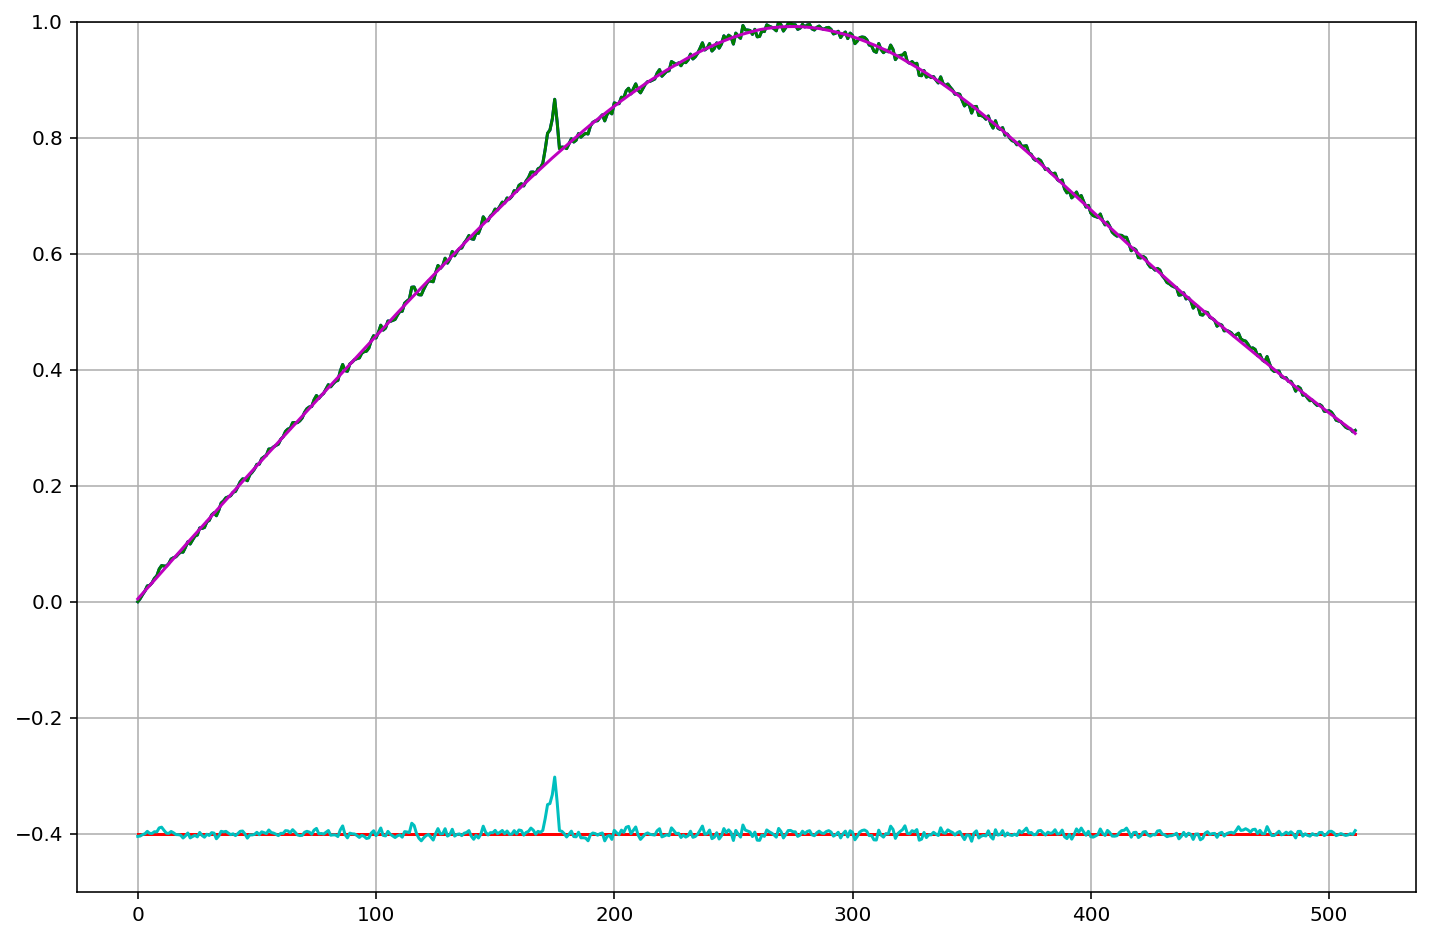

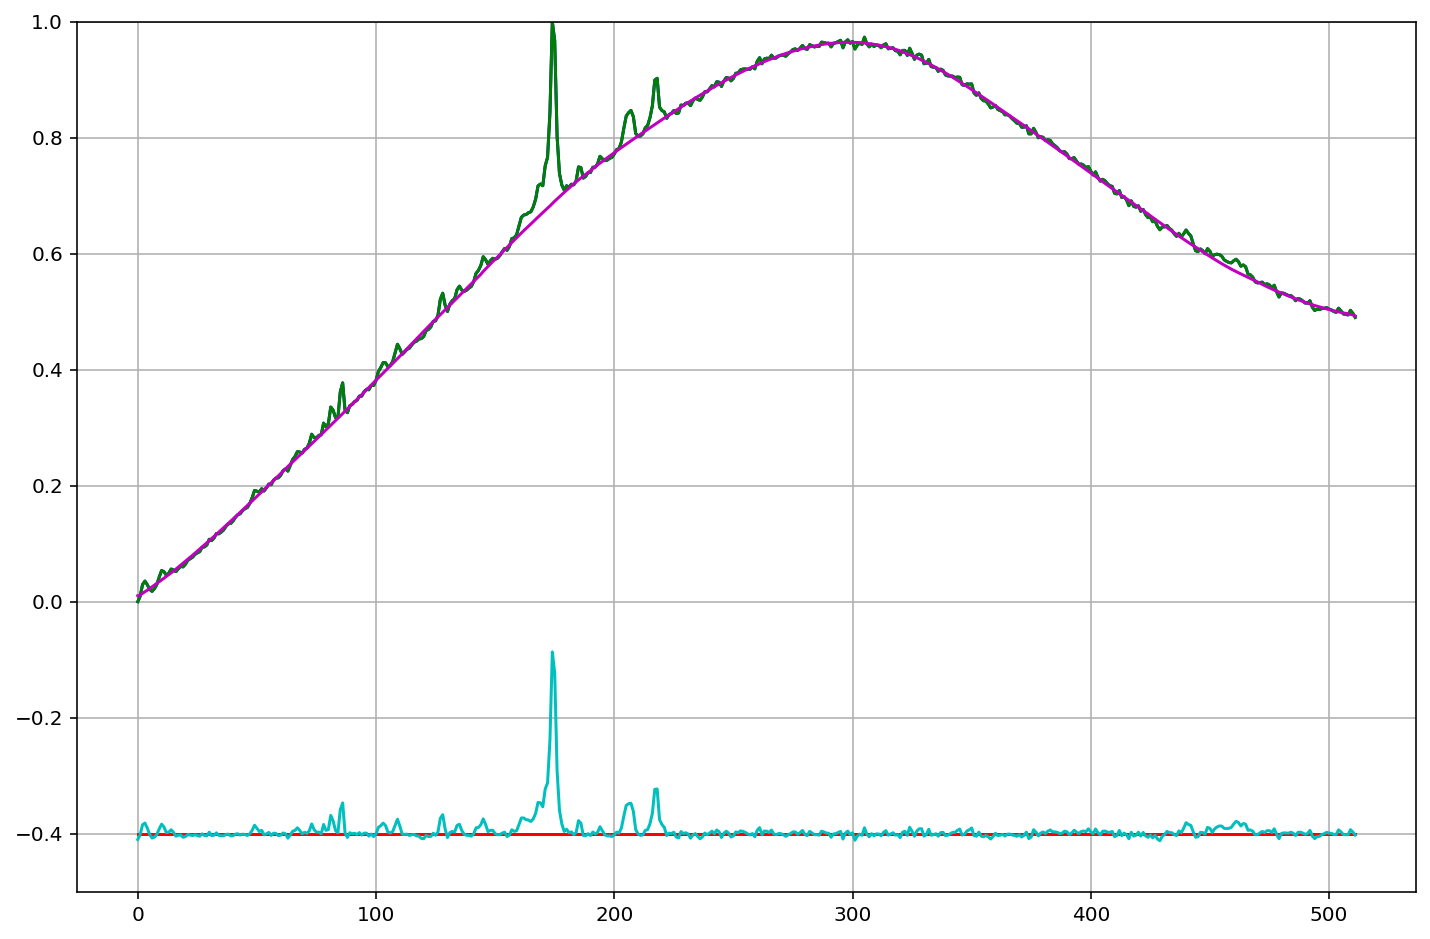

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.signal import savgol_filter
from scipy.signal import decimate

data=np.loadtxt('ExplosiveX.txt')
(dataSize, dataLen) = data.shape
print(f'dataSize : {dataSize}, dataLen : {dataLen}')

data2 =np.empty((dataSize,dataLen//2), dtype=np.float32)
dataLen //= 2
for x,y in zip(data,data2):
#    x[0] = x[1]
#    x[:] = savgol_filter(x, window_length=13, polyorder=4)
    z = decimate(x,2,ftype='iir')  # make data length to 512
    mindata, maxdata = z.min(), z.max()
    y[:] = (z - mindata) / (maxdata - mindata)  # make data be in the range [0,1] 

dataX = torch.tensor(data2, dtype=torch.float32)
#plt.plot(np.array(dataX[1]),'b')
with torch.no_grad():
    for i, inX in enumerate(dataX):

        # dataXX[:] = torch.as_tensor(savgol_filter(x.numpy(), window_length=13, polyorder=4))  
        #dataXXX = dataXX.view(1,dataLen)
        if useGPU: inX = inX.cuda()
        
        outY = myNet(inX).cpu().numpy()
        outY = outY.reshape(dataLen)
        plt.figure(figsize=(12,8))
        plt.ylim(-0.5,1)
        plt.plot(data2[i,:],'b')
        plt.plot(inX.cpu().numpy(),'g')
        plt.plot(outY,'m')
        plt.plot(np.ones((len(outY),1))*(-0.4),'r')
        plt.plot(data2[i,:]-outY-0.4,'c')
        plt.grid(True)
